<a href="https://colab.research.google.com/github/Vernon-2509/BIOPAL-REPORT-1/blob/main/BMPRAC_Report_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Topic 8: Depression/anxiety**

Member's Names:
1. Cheryl Tan (S10267739F), BMS PO1

Contributions: Coding

2. Vernon Ng (S10267562K), BMS PO1

Contributes: Result interpretations

Link to collab notebook: https://colab.research.google.com/drive/1hN-2ZEIsEVfnOeL1QGAHCVp4MaUOvB2w?usp=sharing


# **Data Loading**

In [ ]:
# -----------------------------
# Import function libraries
# -----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# -----------------------------
# Step 0: Define years and NHANES cycles

# -----------------------------
years  = ["2009", "2011", "2013", "2015", "2017"]
cycles = ["F",    "G",    "H",    "I",    "J"]

In [ ]:
# -----------------------------
# Generic loader function
# -----------------------------
def load_data(file_prefix, columns, years, cycles):
    """
    Load and vertically concatenate a set of NHANES XPT files (same prefix)
    across cycles, selecting the intersection of requested columns that exist.
    """
    urls = [f"https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/{y}/DataFiles/{file_prefix}_{c}.xpt"
            for y, c in zip(years, cycles)]
    df_list = []
    for url in urls:
        try:
            df = pd.read_sas(url)
            use_cols = [col for col in columns if col in df.columns]
            df_list.append(df[use_cols].copy())
        except Exception as e:
            print(f"Could not load or process {url}. Error: {e}")
    if not df_list:
        return pd.DataFrame(columns=columns)
    return pd.concat(df_list, ignore_index=True)

In [ ]:
# -----------------------------
# Step 1: Load core (non-DPQ) datasets
# -----------------------------

print("Loading non-DPQ datasets...")

df_demo = load_data("DEMO", ["SEQN","RIAGENDR", "RIDAGEYR", "RIDRETH1"], years, cycles)
df_bmx  = load_data("BMX",  ["SEQN", "BMXBMI"], years, cycles)
df_bio  = load_data("BIOPRO", ["SEQN", "LBXSCR"], years, cycles)  # replace LBXSCR as needed
df_bpx  = load_data("BPX", ["SEQN", "BPXSY1", "BPXSY2", "BPXSY3", "BPXPLS"], years, cycles)
if not df_bpx.empty:
    df_bpx["BPXSY"] = df_bpx[["BPXSY1","BPXSY2","BPXSY3"]].median(axis=1)
    df_bpx = df_bpx.drop(columns=[c for c in ["BPXSY1","BPXSY2","BPXSY3"] if c in df_bpx.columns])

df_smq  = load_data("SMQ", ["SEQN", "SMQ040", "SMQ020"], years, cycles)
df_paq  = load_data("PAQ", ["SEQN", "PAD680"], years, cycles)
df_dbq = load_data("DBQ", ["SEQN", "DBQ700"], years, cycles) # How healthy is your diet (Not used for this analysis)
df_slq = load_data("SLQ", ["SEQN", "SLD010H"], years, cycles) # Sleep hours

# Merge the temporary dataframes into a single dataframe called df
df = df_demo.copy()
for part in [df_bmx, df_bio, df_bpx, df_smq, df_paq, df_dbq, df_slq]: # Removed df_trigly from merge list
    if not part.empty:
        df = pd.merge(df, part, on="SEQN", how="left")

# Keep BPXPLS and SLD010H explicitly in the final df
final_columns = [
    "SEQN",
    "RIAGENDR",
    "RIDAGEYR",
    "RIDRETH1",
    "BMXBMI",
    "LBXSCR",
    "BPXSY",
    "BPXPLS",    # Resting heart rate
    "SLD010H",   # Sleep hours
    "SMQ040",
    "SMQ020",
    "PAD680",
    "DBQ700"
]

df = df[final_columns]

# Restrict age to persons 20 and above
df = df[df["RIDAGEYR"] >= 20].reset_index(drop=True)

Loading non-DPQ datasets...


In [ ]:
print (df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28835 entries, 0 to 28834
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      28835 non-null  float64
 1   RIAGENDR  28835 non-null  float64
 2   RIDAGEYR  28835 non-null  float64
 3   RIDRETH1  28835 non-null  float64
 4   BMXBMI    27332 non-null  float64
 5   LBXSCR    25964 non-null  float64
 6   BPXSY     26551 non-null  float64
 7   BPXPLS    26617 non-null  float64
 8   SLD010H   17531 non-null  float64
 9   SMQ040    12487 non-null  float64
 10  SMQ020    28834 non-null  float64
 11  PAD680    28799 non-null  float64
 12  DBQ700    28835 non-null  float64
dtypes: float64(13)
memory usage: 2.9 MB
None


In [ ]:
# -----------------------------
# Step 2: Load DPQ (2009–2018) and harmonize to 'DepressionCategory'
# -----------------------------

# PHQ-9 Depression (DPQ010–DPQ090)
# Same questionnaire and scoring across all NHANES cycles 2009–2018

def _num(x):
    """Coerce to numeric; treat NHANES special codes as NaN."""
    try:
        v = pd.to_numeric(x)
    except Exception:
        return np.nan
    if v in (7, 9, 77, 99):
        return np.nan
    return v


# -------- 2009–2018 (cycles F–J) --------
years_0918  = ["2009", "2011", "2013", "2015", "2017"]
cycles_0918 = ["F",    "G",     "H",    "I",    "J"]

dpq_vars = [
    "SEQN",
    "DPQ010", "DPQ020", "DPQ030",
    "DPQ040", "DPQ050", "DPQ060",
    "DPQ070", "DPQ080", "DPQ090"
]

dpq_all = load_data("DPQ", dpq_vars, years_0918, cycles_0918)


def phq9_score(row):
    """Compute PHQ-9 total score (0–27)."""
    items = [_num(row.get(v)) for v in dpq_vars[1:]]
    if all(pd.isna(x) for x in items):
        return np.nan
    return np.nansum(items)


def classify_depression_2009_2018(row):
    """
    PHQ-9 Depression Categories:
    0–4   : No depression
    5–9   : Mild depression
    10–14 : Moderate depression
    15–19 : Moderately severe depression
    20–27 : Severe depression
    """
    score = phq9_score(row)
    if pd.isna(score):
        return np.nan
    if score <= 4:
        return "No depression"
    elif score <= 9:
        return "Mild depression"
    elif score <= 14:
        return "Moderate depression"
    elif score <= 19:
        return "Moderately severe depression"
    else:
        return "Severe depression"


if not dpq_all.empty:
    dpq_all["DepressionCategory"] = dpq_all.apply(
        classify_depression_2009_2018, axis=1
    )
    dpq_all = dpq_all[["SEQN", "DepressionCategory"]]


In [ ]:
#Next check for 7,9, 77,99 and 7777 and 9999 (these are don't know and refused to answer)
#Depression variables have already been cleaned of these don't know and refused to answer data

#This code looks at the maximum values and the user must then determine if 7, 9, 77, 99 or 7777 or 9999 represent
#Don't know or refussed to answer


columns = ["RIAGENDR", "RIDAGEYR", "RIDRETH1", "BMXBMI",
           "LBXSCR", "BPXSY",
           "SMQ040", "SMQ020",
           "PAD680", "DBQ700"]
for col in columns:
  max_values = df[col].max()
  print(f"Max value in {col}: {max_values}")

Max value in RIAGENDR: 2.0
Max value in RIDAGEYR: 80.0
Max value in RIDRETH1: 5.0
Max value in BMXBMI: 86.2
Max value in LBXSCR: 17.41
Max value in BPXSY: 238.0
Max value in SMQ040: 7.0
Max value in SMQ020: 9.0
Max value in PAD680: 9999.0
Max value in DBQ700: 9.0


In [ ]:
map = {7: np.nan, 9: np.nan}
df["SMQ040"] = df["SMQ040"].replace(map)
df["SMQ020"]= df["SMQ020"].replace(map)
df["DBQ700"]= df["DBQ700"].replace(map)

map = {7777: np.nan, 9999: np.nan}
df["PAD680"] = df["PAD680"].replace(map)



#Check
for col in columns:
  max_values = df[col].max()
  print(f"Max value in {col}: {max_values}")

Max value in RIAGENDR: 2.0
Max value in RIDAGEYR: 80.0
Max value in RIDRETH1: 5.0
Max value in BMXBMI: 86.2
Max value in LBXSCR: 17.41
Max value in BPXSY: 238.0
Max value in SMQ040: 3.0
Max value in SMQ020: 2.0
Max value in PAD680: 1380.0
Max value in DBQ700: 5.0


In [ ]:
#Now check for information and %missing values,
display (df.info())
print (df.isnull().sum()/len(df)*100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28835 entries, 0 to 28834
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      28835 non-null  float64
 1   RIAGENDR  28835 non-null  float64
 2   RIDAGEYR  28835 non-null  float64
 3   RIDRETH1  28835 non-null  float64
 4   BMXBMI    27332 non-null  float64
 5   LBXSCR    25964 non-null  float64
 6   BPXSY     26551 non-null  float64
 7   BPXPLS    26617 non-null  float64
 8   SLD010H   17531 non-null  float64
 9   SMQ040    12485 non-null  float64
 10  SMQ020    28815 non-null  float64
 11  PAD680    28659 non-null  float64
 12  DBQ700    28823 non-null  float64
dtypes: float64(13)
memory usage: 2.9 MB


None

SEQN         0.000000
RIAGENDR     0.000000
RIDAGEYR     0.000000
RIDRETH1     0.000000
BMXBMI       5.212415
LBXSCR       9.956650
BPXSY        7.920929
BPXPLS       7.692041
SLD010H     39.202358
SMQ040      56.701925
SMQ020       0.069360
PAD680       0.610369
DBQ700       0.041616
dtype: float64


# **Categorization of Continuous Variables**

# Sedentary hours

In [ ]:
#Convert sedentary minutes into sedentary hours and create a new categorical variable
#called SedentaryHours
df["SedentaryHours"]=df["PAD680"]/60

SedentaryCategory
Less than 4 hrs     7473
4–8 hrs            11326
8–12 hrs            7585
12+ hrs             2275
Name: count, dtype: int64


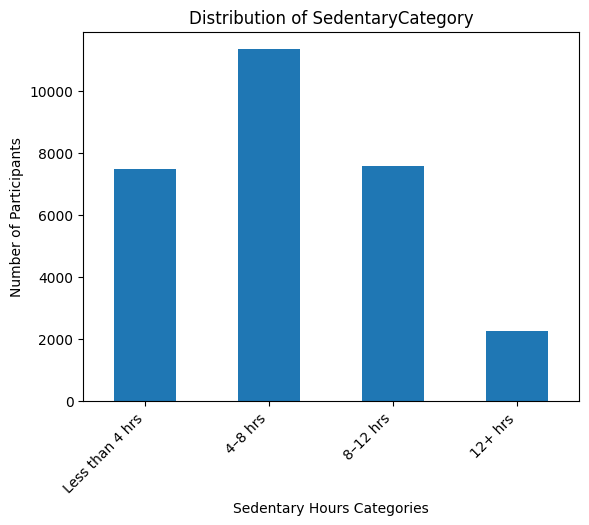

In [ ]:
# Convert SedentaryHours into a categorical variable with 4 hour bins


# Define bins and labels
bins = [0, 4, 8, 12, float("inf")]
labels = ["Less than 4 hrs", "4–8 hrs", "8–12 hrs", "12+ hrs"]

# Create categorical variable

#Next create the categorical variable containing the labelled bins.
#Right = False* means that the right value is not included.
#In this case, the first bin is from 0-3 and the second bin from 4-7 etc

df["SedentaryCategory"] = pd.cut(df["SedentaryHours"],
                                 bins=bins,
                                 labels=labels,
                                 right=False)  # include left edge, exclude right



# Set the order (In this case the order is the same as the labels)
#Setting the order is important as later you will need to drop one category for
#a logistic regression
order = ["Less than 4 hrs", "4–8 hrs", "8–12 hrs", "12+ hrs"]

df["SedentaryCategory"] = pd.Categorical(
df["SedentaryCategory"],
                                         categories=order,
                                         ordered=True)

# Quick check
print(df["SedentaryCategory"].value_counts().reindex(labels))

# Bar chart
df["SedentaryCategory"].value_counts().reindex(labels).plot(
    kind="bar",
    xlabel="Sedentary Hours Categories",
    ylabel="Number of Participants",
    title="Distribution of SedentaryCategory",
    rot=0
)

plt.xticks(rotation=45, ha="right")
plt.show()

# Gender

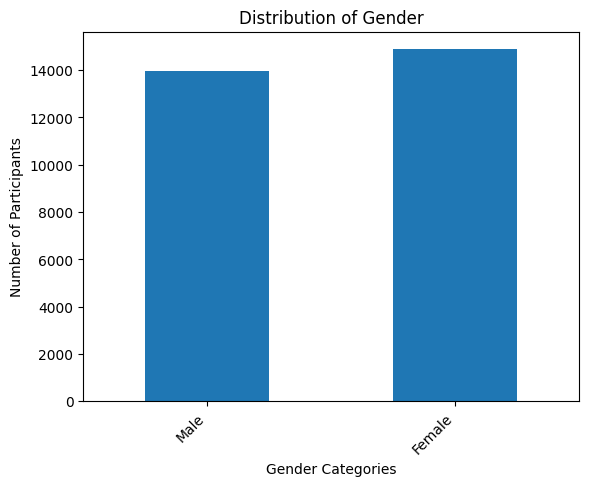

In [ ]:
#Now map the Categorical variables to interpretible names
#This is not a critical requirement - but it is useful for interpretation.
#Gender
map = {1: "Male", 2: "Female"}
labels = ["Male", "Female"]
df["Gender"] = df["RIAGENDR"].replace(map).astype("category")


# Bar chart
df["Gender"].value_counts().reindex(labels).plot(
    kind="bar",
    xlabel="Gender Categories",
    ylabel="Number of Participants",
    title="Distribution of Gender",
    rot=0
)

plt.xticks(rotation=45, ha="right")
plt.show()

# Race

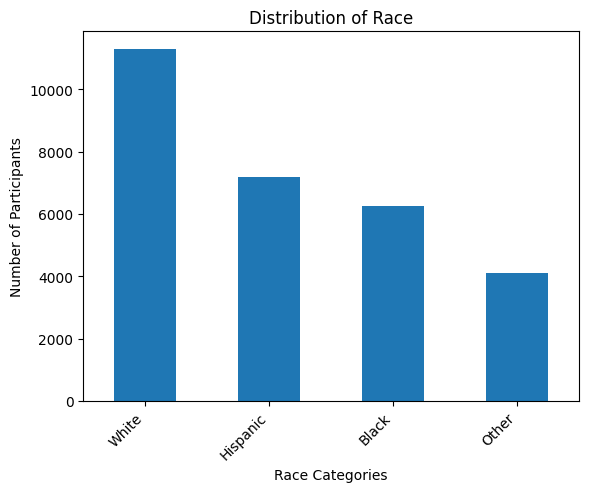

In [ ]:
#Race
#For this assignment - use RIDRETH1. RIDRETH1 does not separately classify participants who are  Asian,
#unlike RIDRETH3. However RIDRETH3 is not available for 2009 data.

map = {1: "Hispanic",
       2: "Hispanic",
       3: "White",
       4: "Black",
       5: "Other"} #
labels = ["Hispanic", "White", "Black", "Other"]
df["Race"] = df["RIDRETH1"].replace(map).astype("category")


# Reorder Race categories so "White" is first
order = ["White", "Hispanic", "Black", "Other"]

df["Race"] = df["Race"].cat.reorder_categories(order, ordered=True)

# Plot Bar chart
df["Race"].value_counts().reindex(order).plot(
    kind="bar",
    xlabel="Race Categories",
    ylabel="Number of Participants",
    title="Distribution of Race",
    rot = 0)

plt.xticks(rotation=45, ha="right")
plt.show()

# Smoking

In [ ]:
#Smoking

#Start with mapping SMQ040 and SMQ020 to interpretable categories.

map = {1: "Every day", 2: "Some days", 3:"Not at all"}
df["SMQ040"] = df["SMQ040"].replace(map)
map = {1: "Yes", 2: "No"}
df["SMQ020"] = df["SMQ020"].replace(map)

SmokingCategory
Never smoked         16328
Former smoker         6763
Current smoker        4590
Occasional smoker     1132
Name: count, dtype: int64
22


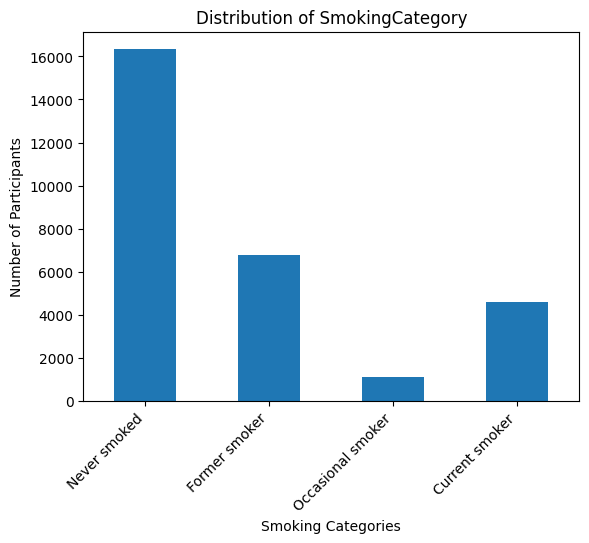

In [ ]:
#Let's combine SMQ040 and SMQ020 to create a new column with smoking status

import numpy as np

def classify_smoking(row):
    if row["SMQ020"] == "No":
        return "Never smoked"
    elif row["SMQ020"] == "Yes":
        if row["SMQ040"] == "Every day":
            return "Current smoker"
        elif row["SMQ040"] == "Some days":
            return "Occasional smoker"
        elif row["SMQ040"] == "Not at all":
            return "Former smoker"
    return np.nan


#Arrange starting from Never smoked


df["SmokingCategory"] = df.apply(classify_smoking, axis=1)

order = ["Never smoked", "Former smoker", "Occasional smoker", "Current smoker"]

df["SmokingCategory"] = pd.Categorical(
    df["SmokingCategory"],
    categories=order,
    ordered=True
)

# Frequency counts
print(df["SmokingCategory"].value_counts())
print (df["SmokingCategory"].isnull().sum())



# Bar chart
df["SmokingCategory"].value_counts().reindex(order).plot(
    kind="bar",
    xlabel="Smoking Categories",
    ylabel="Number of Participants",
    title="Distribution of SmokingCategory",
    rot=0
)

plt.xticks(rotation=45, ha="right")
plt.show()

##BMI

| Category                               | BMI Range   |
| -------------------------------------- | ----------- |
| **Underweight**                        | < 18.5      |
| **Normal weight**                      | 18.5 – 24.9 |
| **Overweight**                         | 25.0 – 29.9 |
| **Obese (Class I)**                    | 30.0 – 34.9 |
| **Obese (Class II)**                   | 35.0 – 39.9 |
| **Obese (Class III / Severe obesity)** | ≥ 40.0      |


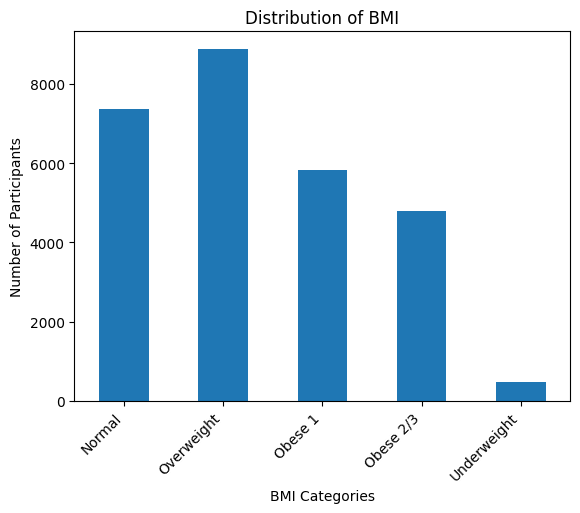

In [ ]:
# Define bins and labels
bins = [0, 18.5, 24.9, 29.9, 34.9, np.inf]
labels = ["Underweight", "Normal", "Overweight", "Obese 1", "Obese 2/3"]

# Cut into categories
df["BMICategory"] = pd.cut(df["BMXBMI"], bins=bins, labels=labels, right = True).astype("category")

# Reorder so "Normal" is first
order = ["Normal", "Overweight", "Obese 1", "Obese 2/3", "Underweight"]
df["BMICategory"] = df["BMICategory"].cat.reorder_categories(order, ordered=True)

# Plot with reordered categories
df["BMICategory"].value_counts().reindex(order).plot(
    kind="bar",
    xlabel="BMI Categories",
    ylabel="Number of Participants",
    title="Distribution of BMI",
    rot=0
)

plt.xticks(rotation=45, ha="right")
plt.show()

# Age

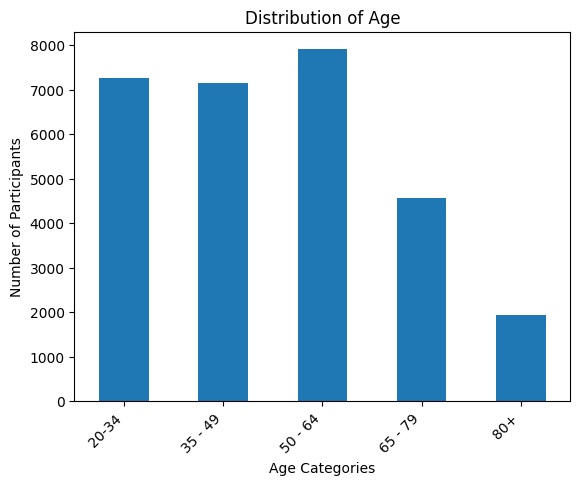

In [ ]:
#Convert RIAGEYR into a categorical variable (with 15 year intervals)
#Starting from age 20
# 1) Define new bins and labels
bins = [19, 34, 49, 65, 79, float("inf")]
labels = ["20-34", "35 - 49", "50 - 64", "65 - 79", "80+"]

# 2) Recreate AgeGroup
df["AgeCategory"] = pd.cut(df["RIDAGEYR"], bins = bins, labels = labels, right = True).astype("category")

order = ["20-34", "35 - 49", "50 - 64", "65 - 79", "80+"]

df["AgeCategory"] = df["AgeCategory"].cat.reorder_categories(order, ordered=True)

# Bar chart
df["AgeCategory"].value_counts().reindex(labels).plot(
    kind="bar",
    xlabel="Age Categories",
    ylabel="Number of Participants",
    title="Distribution of Age",
    rot=0
)

plt.xticks(rotation=45, ha="right")
plt.show()

##Systolic blood pressure
Let's convert Systolic Blood Pressure into a categorical variable


| Category                 | Systolic BP (mmHg)            | Notes                                                             |
| ------------------------ | ----------------------------- | ----------------------------------------------------------------- |
| **Normal**               | < 120                         | Healthy range                                                     |
| **Elevated**             | 120–129                       | Not yet hypertension, but increased risk                          |
| **Hypertension Stage 1** | 130–139                       | Usually lifestyle modification + consider medication if high risk |
| **Hypertension Stage 2** | ≥ 140                         | Medication generally recommended                                  |
| **Hypertensive Crisis**  | ≥ 180 (and/or diastolic ≥120) | Medical emergency                                                 |


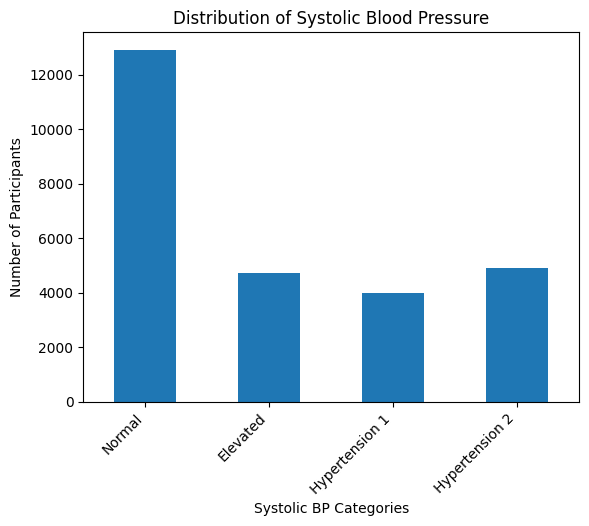

In [ ]:
#Convert Systolic blood pressure into a categorical Variable


# --- Systolic BP Categories ---
bins = [0, 120, 129, 139, np.inf]
labels = ["Normal", "Elevated", "Hypertension 1", "Hypertension 2"]
df["SysBPCategory"] = pd.cut(df["BPXSY"], bins=bins, labels=labels, right = True).astype("category")

order = ["Normal", "Elevated", "Hypertension 1", "Hypertension 2"]

df["SysBPCategory"] = df["SysBPCategory"].cat.reorder_categories(order, ordered=True)

# Bar chart
df["SysBPCategory"].value_counts().reindex(labels).plot(
    kind="bar",
    xlabel="Systolic BP Categories",
    ylabel="Number of Participants",
    title="Distribution of Systolic Blood Pressure",
    rot=0
)

plt.xticks(rotation=45, ha="right")
plt.show()

# Sleep Hours

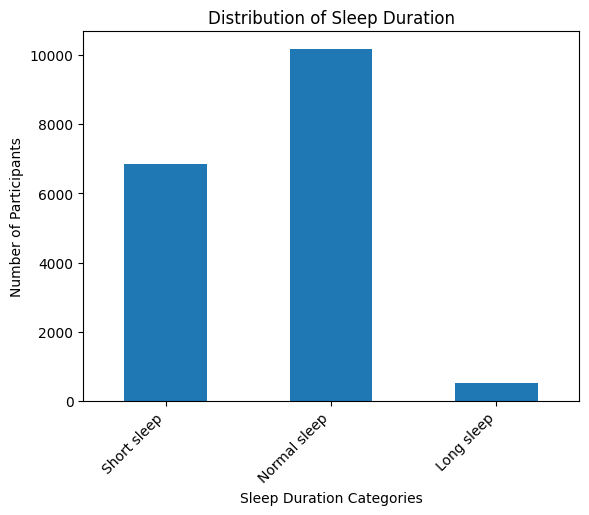

In [ ]:
# Convert Sleep Hours into a categorical variable

# --- Sleep Duration Categories (hours) ---
bins = [0, 6, 9, np.inf]
labels = ["Short sleep", "Normal sleep", "Long sleep"]

df["SleepCategory"] = pd.cut(
    df["SLD010H"],
    bins=bins,
    labels=labels,
    right=True
).astype("category")

order = ["Short sleep", "Normal sleep", "Long sleep"]
df["SleepCategory"] = df["SleepCategory"].cat.reorder_categories(order, ordered=True)

# Bar chart
df["SleepCategory"].value_counts().reindex(labels).plot(
    kind="bar",
    xlabel="Sleep Duration Categories",
    ylabel="Number of Participants",
    title="Distribution of Sleep Duration",
    rot=0
)

plt.xticks(rotation=45, ha="right")
plt.show()

In [ ]:
#Let's again look at the data

print (df.info())
print (df.isnull().sum())
print (df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28835 entries, 0 to 28834
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   SEQN               28835 non-null  float64 
 1   RIAGENDR           28835 non-null  float64 
 2   RIDAGEYR           28835 non-null  float64 
 3   RIDRETH1           28835 non-null  float64 
 4   BMXBMI             27332 non-null  float64 
 5   LBXSCR             25964 non-null  float64 
 6   BPXSY              26551 non-null  float64 
 7   BPXPLS             26617 non-null  float64 
 8   SLD010H            17531 non-null  float64 
 9   SMQ040             12485 non-null  object  
 10  SMQ020             28815 non-null  object  
 11  PAD680             28659 non-null  float64 
 12  DBQ700             28823 non-null  float64 
 13  SedentaryHours     28659 non-null  float64 
 14  SedentaryCategory  28659 non-null  category
 15  Gender             28835 non-null  category
 16  Race

In [ ]:
columns = ['DepressionCategory',
       'SedentaryCategory', 'Gender', 'Race', 'SmokingCategory',
       'BMICategory', 'AgeCategory', 'SysBPCategory',
        'HRCategory',
        'SleepCategory']

# **Grouped Bar Charts**

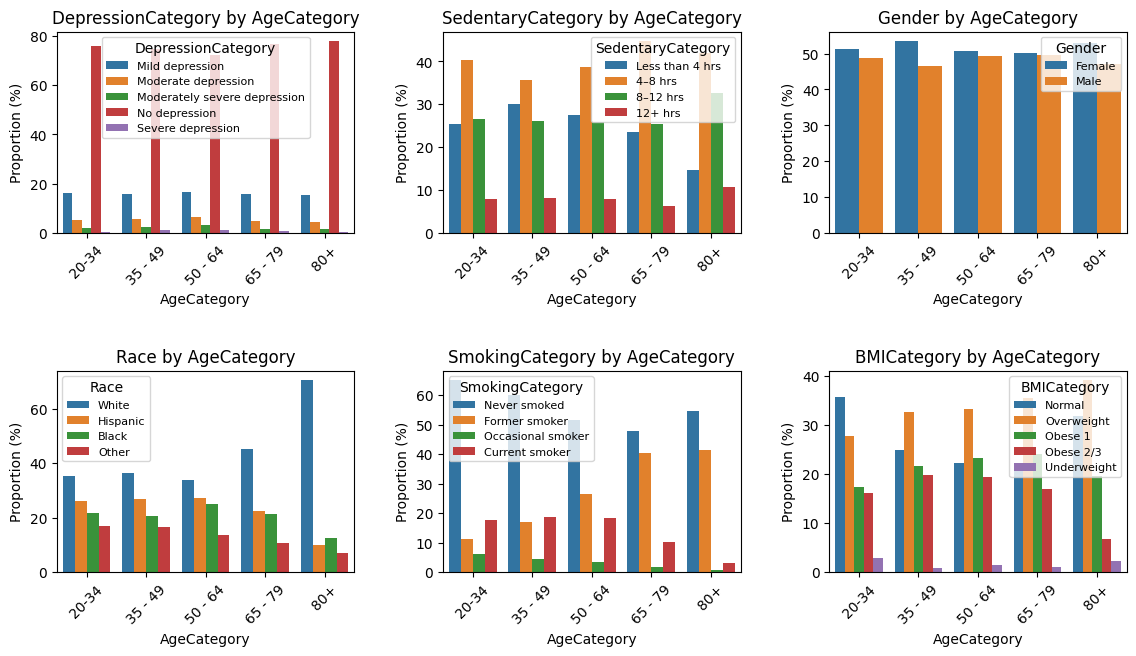

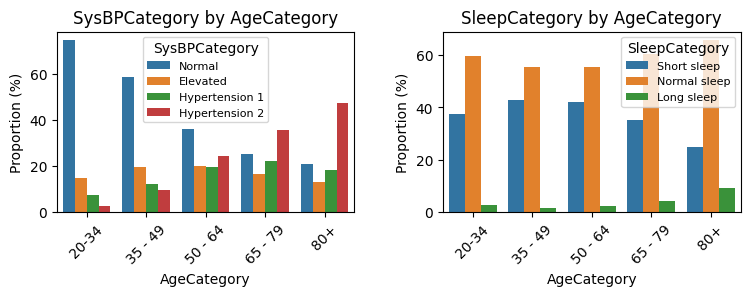

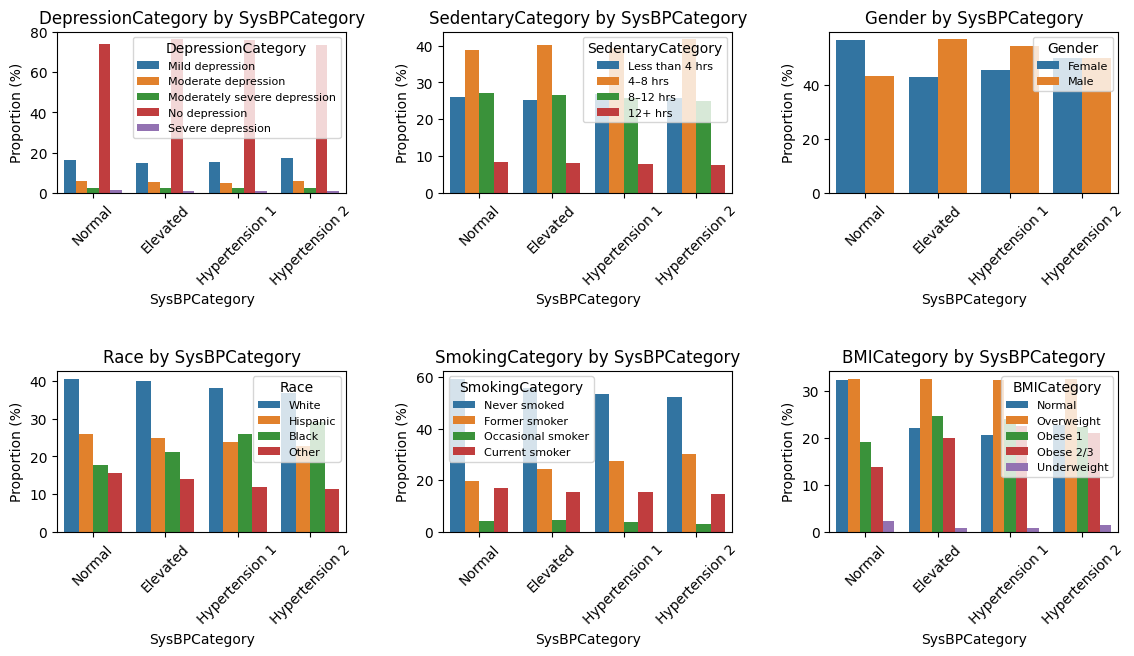

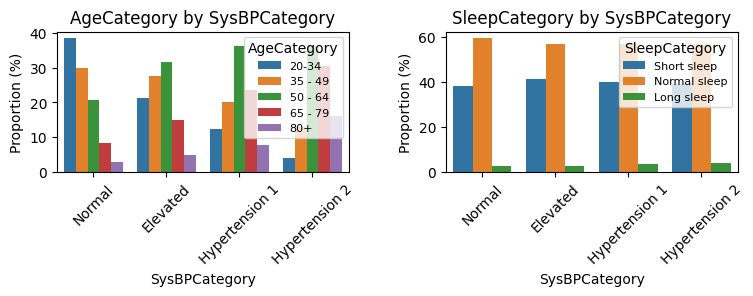

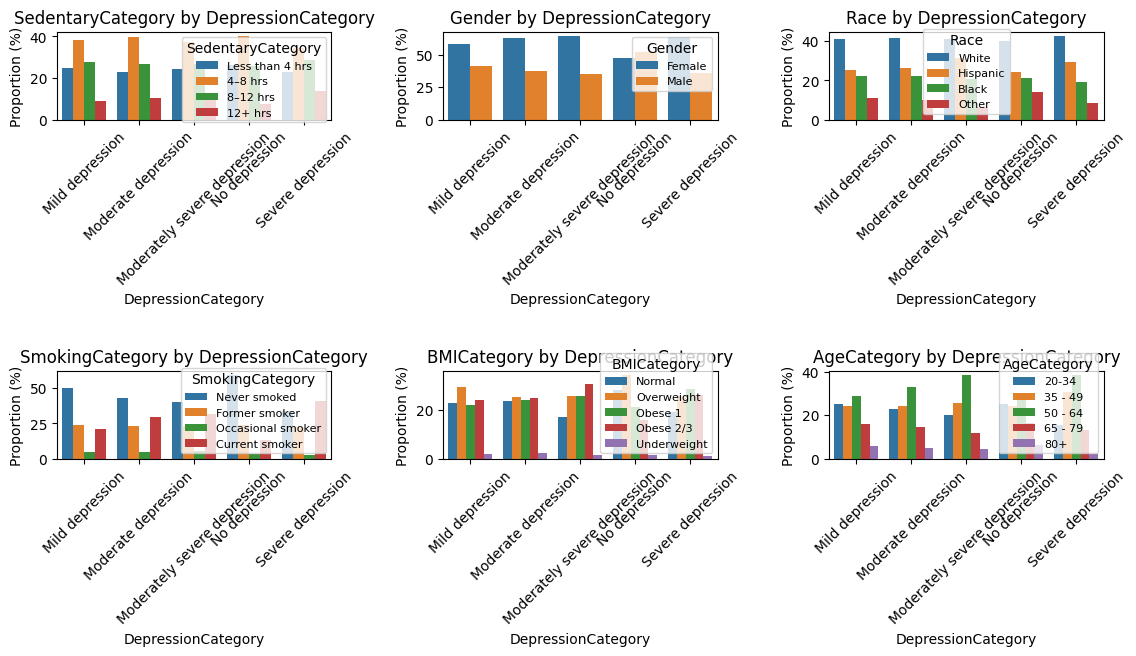

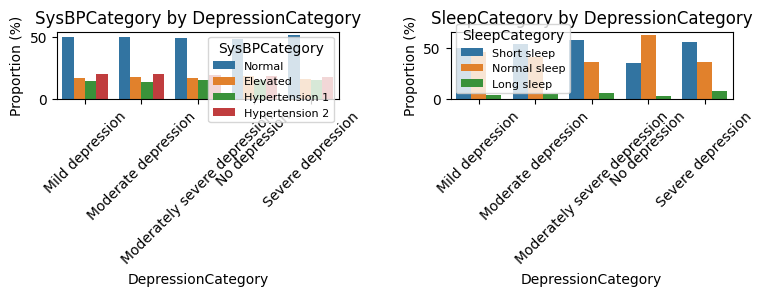

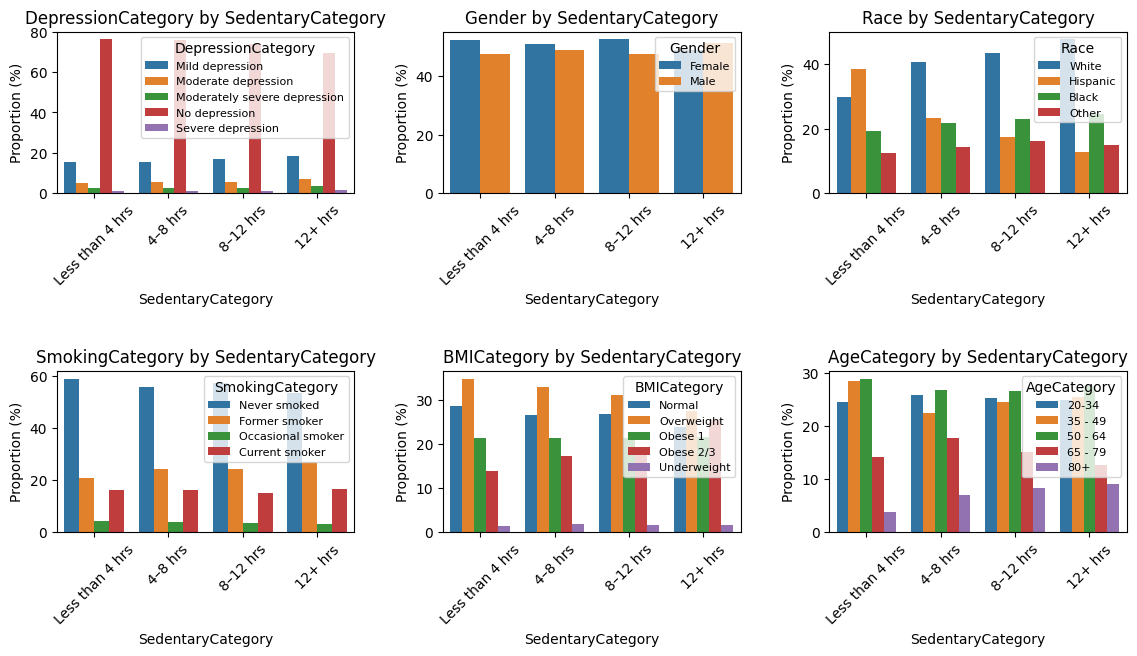

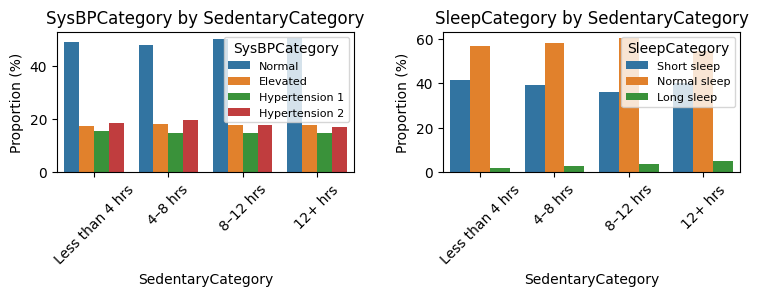

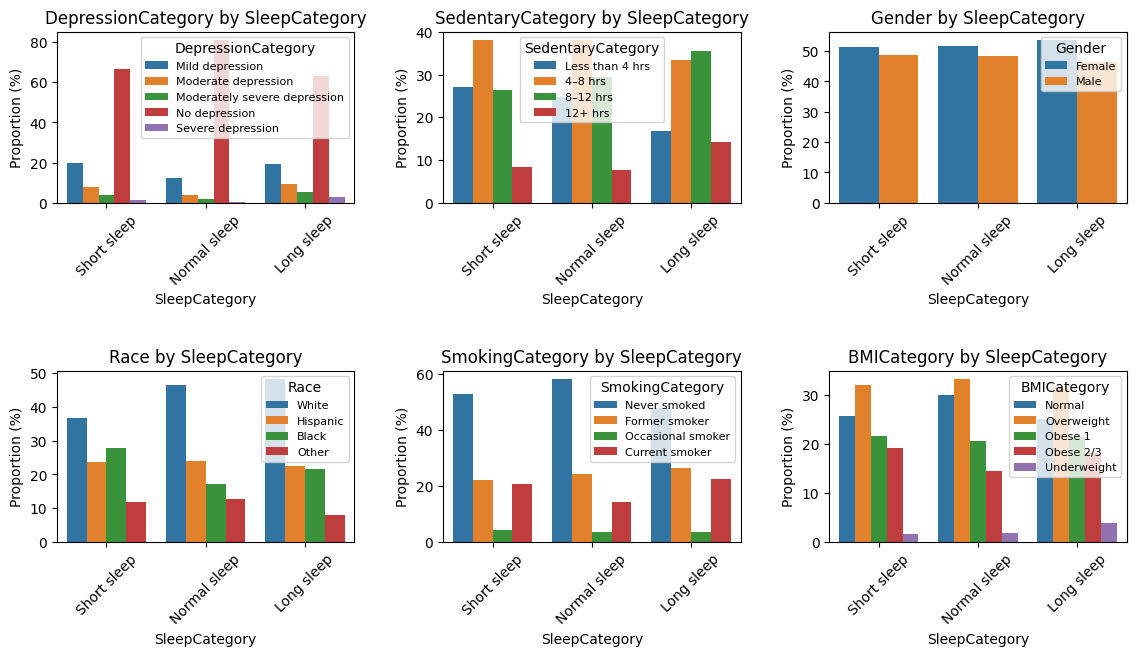

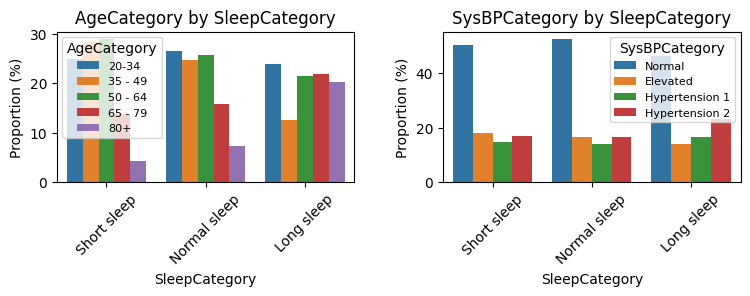

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_categorical_relations(df, x_var, cat_vars, per_page=6, mode="count"):
    """
    Plot grouped bar charts for categorical variables (as hue),
    using one specified variable as the X-axis.

    Parameters:
    - df: DataFrame
    - x_var: categorical variable on the X-axis
    - cat_vars: list of categorical variables to plot as hue
    - per_page: number of plots per figure
    - mode: "count" or "proportion"
    """
    others = [v for v in cat_vars if v != x_var]
    for start in range(0, len(others), per_page):
        page = others[start:start+per_page]
        n = len(page)
        ncols = 3
        nrows = (n + ncols - 1) // ncols
        fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3.6*nrows))
        axes = axes.ravel()

        for ax, hue_var in zip(axes, page):
            if mode == "count":
                sns.countplot(data=df, x=x_var, hue=hue_var, ax=ax)
                ax.set_ylabel("Count")
            elif mode == "proportion":
                # Compute proportions within each x_var group
                prop_df = (
                    df.groupby([x_var, hue_var], observed=True)
                    .size()
                    .reset_index(name="Count")
                    )

                # Compute proportions within each x_var group
                prop_df["Proportion"] = (
                      prop_df.groupby(x_var, observed=True)["Count"]
                      .apply(lambda x: 100 * x / x.sum())
                      .values
                    )
                sns.barplot(data=prop_df, x=x_var, y="Proportion", hue=hue_var, ax=ax)
                ax.set_ylabel("Proportion (%)")
            else:
                raise ValueError("mode must be 'count' or 'proportion'")

            ax.set_title(f"{hue_var} by {x_var}")
            ax.set_xlabel(x_var)
            ax.tick_params(axis="x", rotation=45)
            ax.legend(title=hue_var, fontsize=8)

        # remove unused axes
        for ax in axes[len(page):]:
            fig.delaxes(ax)

        # Adjust spacing between subplots
        fig.tight_layout(pad=3.0)
        plt.show()

# Merge dpq_all into df to include DepressionCategory if not already present
# This assumes dpq_all is available in the global scope
if 'DepressionCategory' not in df.columns and 'dpq_all' in globals() and not dpq_all.empty:
    df = pd.merge(df, dpq_all[['SEQN', 'DepressionCategory']], on='SEQN', how='left')


# Filter out 'HRCategory' from the columns list as it does not exist in df
filtered_columns = [col for col in columns if col != 'HRCategory']

# Plot as proportions (Change to mode = "count" for totals)
#AgeCategory
plot_categorical_relations(df, x_var="AgeCategory", cat_vars=filtered_columns, per_page=6, mode="proportion")

#SysBPCategory
plot_categorical_relations(df, x_var="SysBPCategory", cat_vars=filtered_columns, per_page=6, mode="proportion")

#DepressionCategory
plot_categorical_relations(df, x_var="DepressionCategory", cat_vars=filtered_columns, per_page=6, mode="proportion")

#SedentaryCategory
plot_categorical_relations(df, x_var="SedentaryCategory", cat_vars=filtered_columns, per_page=6, mode="proportion")

#SleepCategory
plot_categorical_relations(df, x_var="SleepCategory", cat_vars=filtered_columns, per_page=6, mode="proportion")

# **1. What is the primary relationship between SleepCategory and DepressionCategory?**
The visualization DepressionCategory by SleepCategory provides clear evidence of an association between sleep duration and mental health status:

Short Sleep and Higher Risk: Participants categorized as "Short sleep" exhibit a noticeably higher proportion of depression across all severity levels (Mild, Moderate, and Severe) compared to those with "Normal sleep".

The "Normal Sleep" Buffer: The "No depression" group is overwhelmingly comprised of individuals who achieve "Normal sleep". This suggests that a standard sleep duration is a strong indicator of (or contributor to) better mental health.

Severe Depression: In the SleepCategory by DepressionCategory chart, the "Severe depression" group shows a disproportionately high percentage of "Short sleep" and a visible presence of "Long sleep" compared to the "No depression" group. This indicates that extreme sleep durations (too little or too much) are often comorbid with severe depressive symptoms.

# **2. How does SleepCategory change across different AgeCategories?**
Looking at the SleepCategory by AgeCategory chart, we can see how sleep patterns evolve as participants age:

Consistency in Mid-Life: The proportion of "Normal sleep" remains relatively stable between the ages of 20 and 64.

Trends in Older Adulthood: As participants reach the 80+ category, there is a slight decrease in the proportion of "Short sleep" and a notable increase in the proportion of "Long sleep" compared to younger age groups.

Short Sleep in Youth: The 20–34 age group shows a significant percentage of "Short sleep", which may correlate with the higher levels of mild-to-moderate depression seen in that same age bracket.

# **3. Which other variables show a significant impact on DepressionCategory?**
While your focus is on sleep, the charts reveal other variables that largely impact depression levels:

Sedentary Behavior: In the DepressionCategory by SedentaryCategory chart, individuals who are sedentary for "12+ hrs" show higher proportions of depression compared to those sitting for "Less than 4 hrs". This suggests that physical inactivity is a major risk factor alongside poor sleep.

Gender Differences: The Gender by DepressionCategory plot indicates that Females represent a higher proportion of those with Mild, Moderate, and Severe depression than Males within this dataset.

Systolic Blood Pressure: Interestingly, the DepressionCategory by SysBPCategory chart shows that while most people with depression have "Normal" BP, those in the "Hypertension 2" category have a visible presence in the more severe depression groups, suggesting a link between cardiovascular strain and mental health.

# Conclusion:

 from Exploratory Analysis
The preliminary data suggests a strong negative correlation between healthy sleep duration and depression. Short sleep is the most significant sleep-related indicator for the presence of depressive symptoms. Additionally, high sedentary time and female gender appear to be significant demographic and lifestyle predictors that should be controlled for in your upcoming Logistic Regression and XGBoost models

# **Heat Maps**

/tmp/ipython-input-2570206928.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.96])


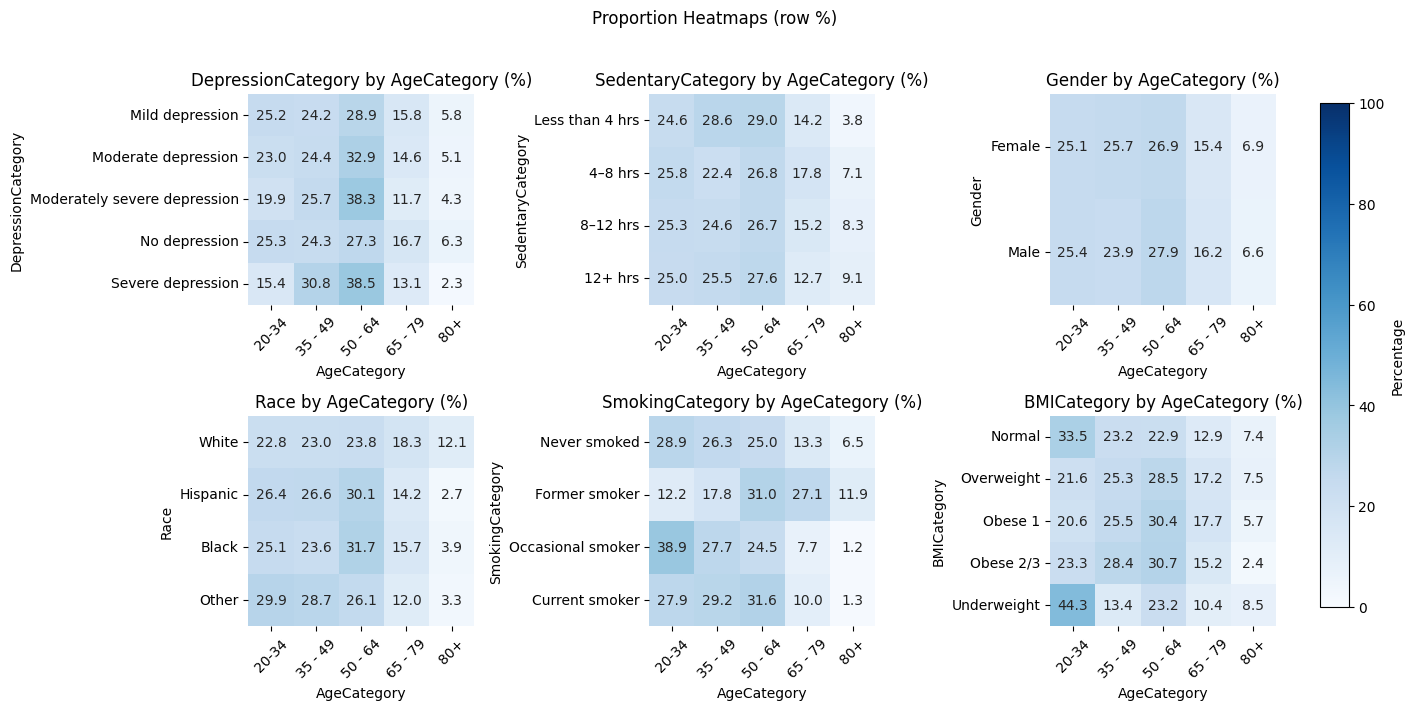

/tmp/ipython-input-2570206928.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.96])


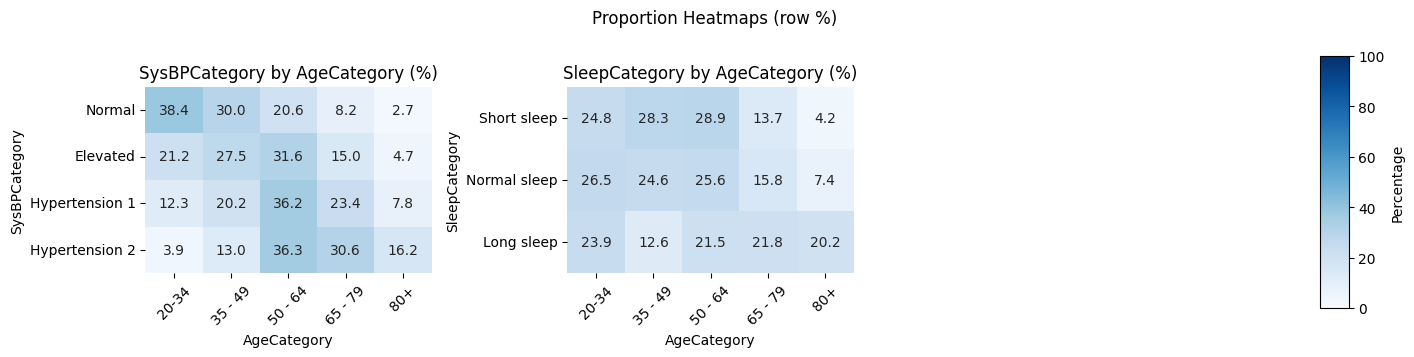

/tmp/ipython-input-2570206928.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.96])


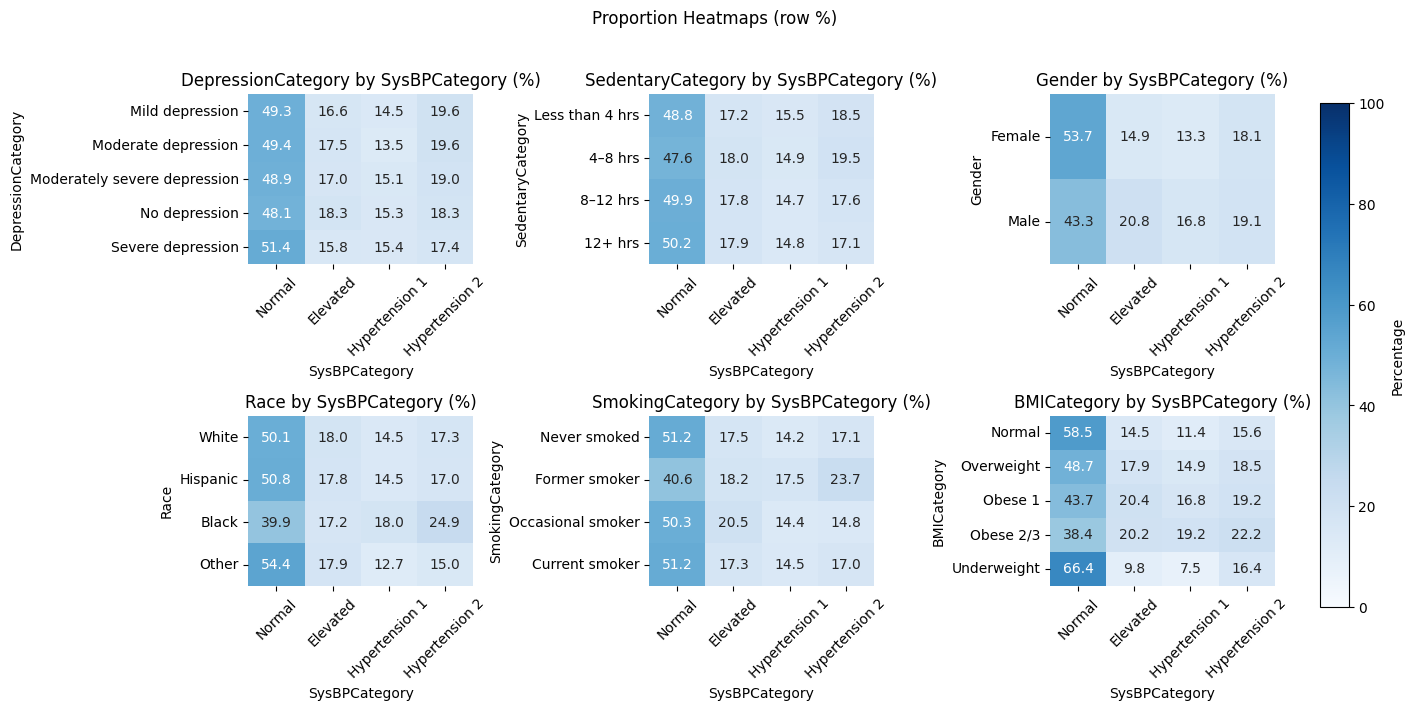

/tmp/ipython-input-2570206928.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.96])


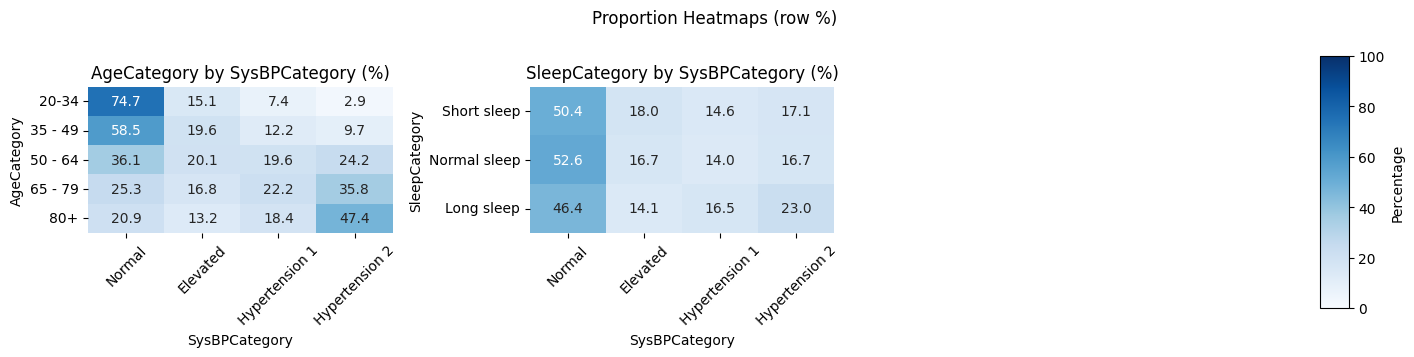

/tmp/ipython-input-2570206928.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.96])


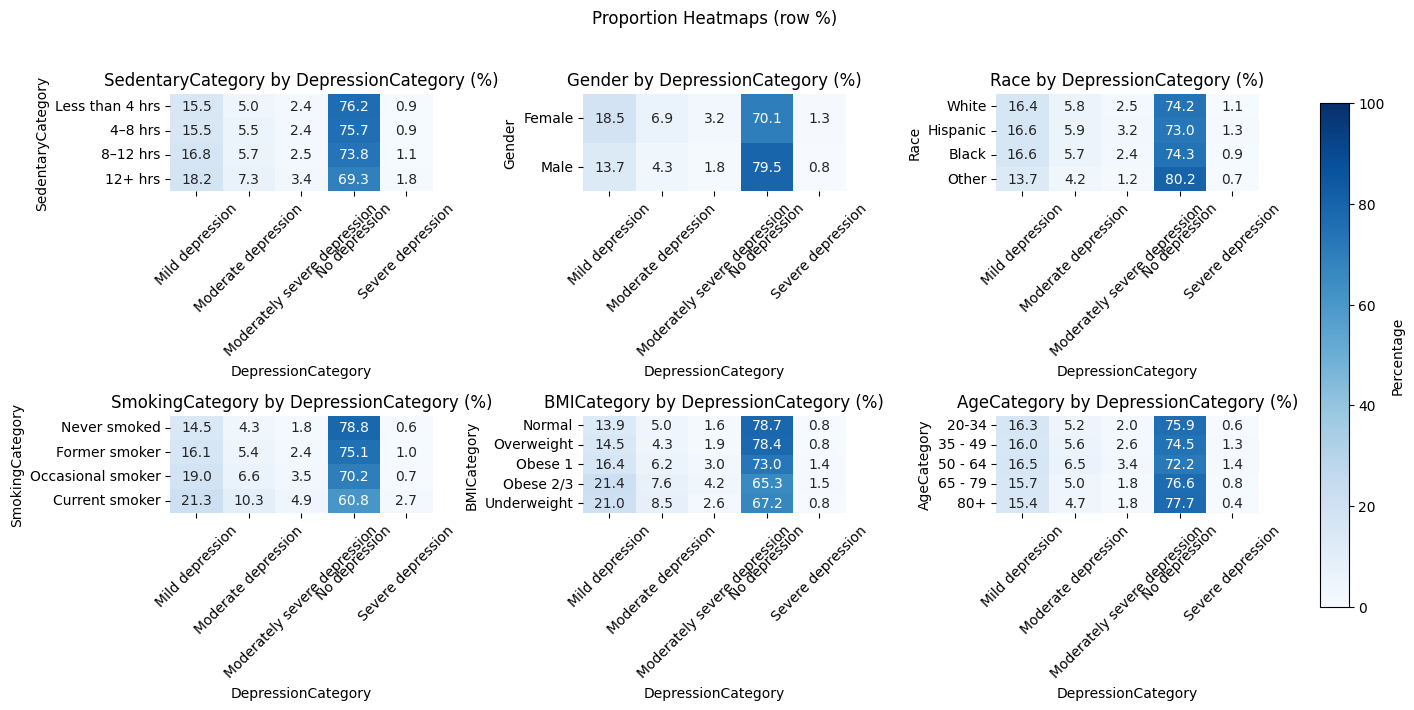

/tmp/ipython-input-2570206928.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.96])


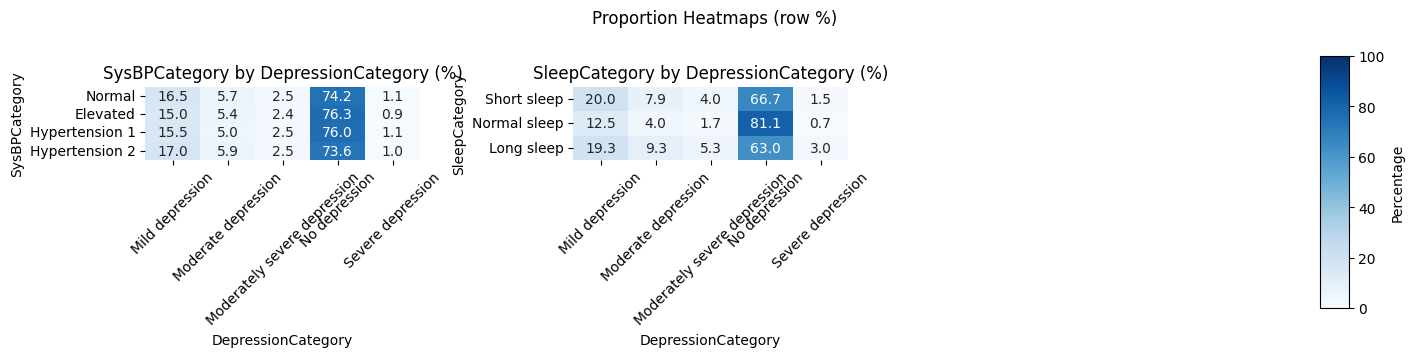

/tmp/ipython-input-2570206928.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.96])


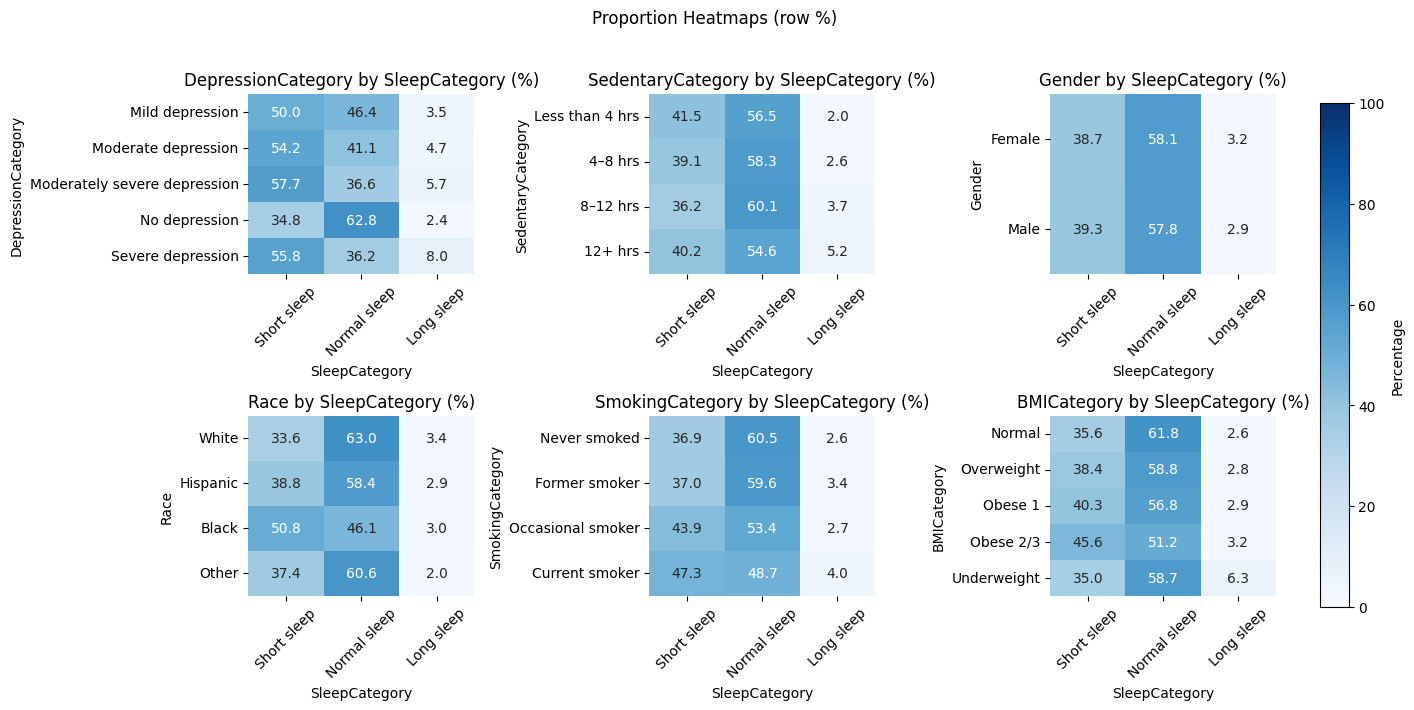

/tmp/ipython-input-2570206928.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.96])


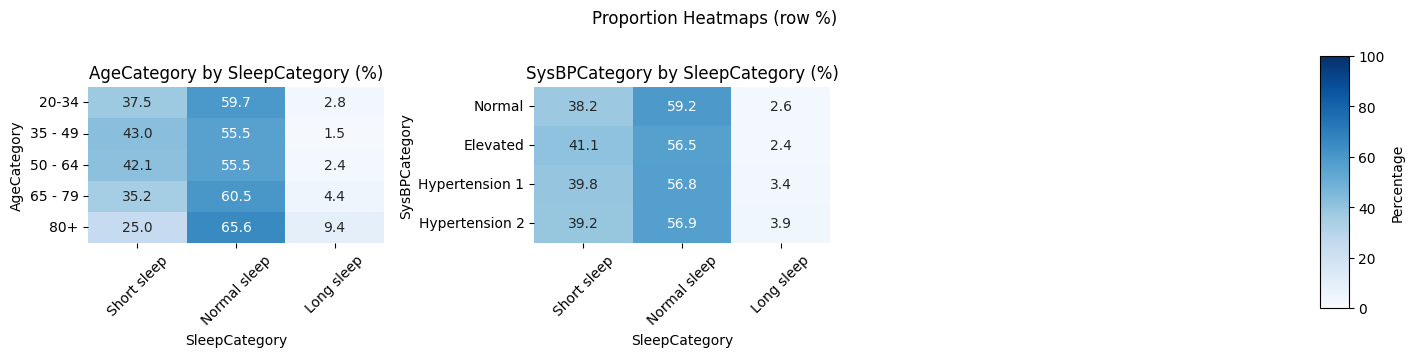

/tmp/ipython-input-2570206928.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.96])


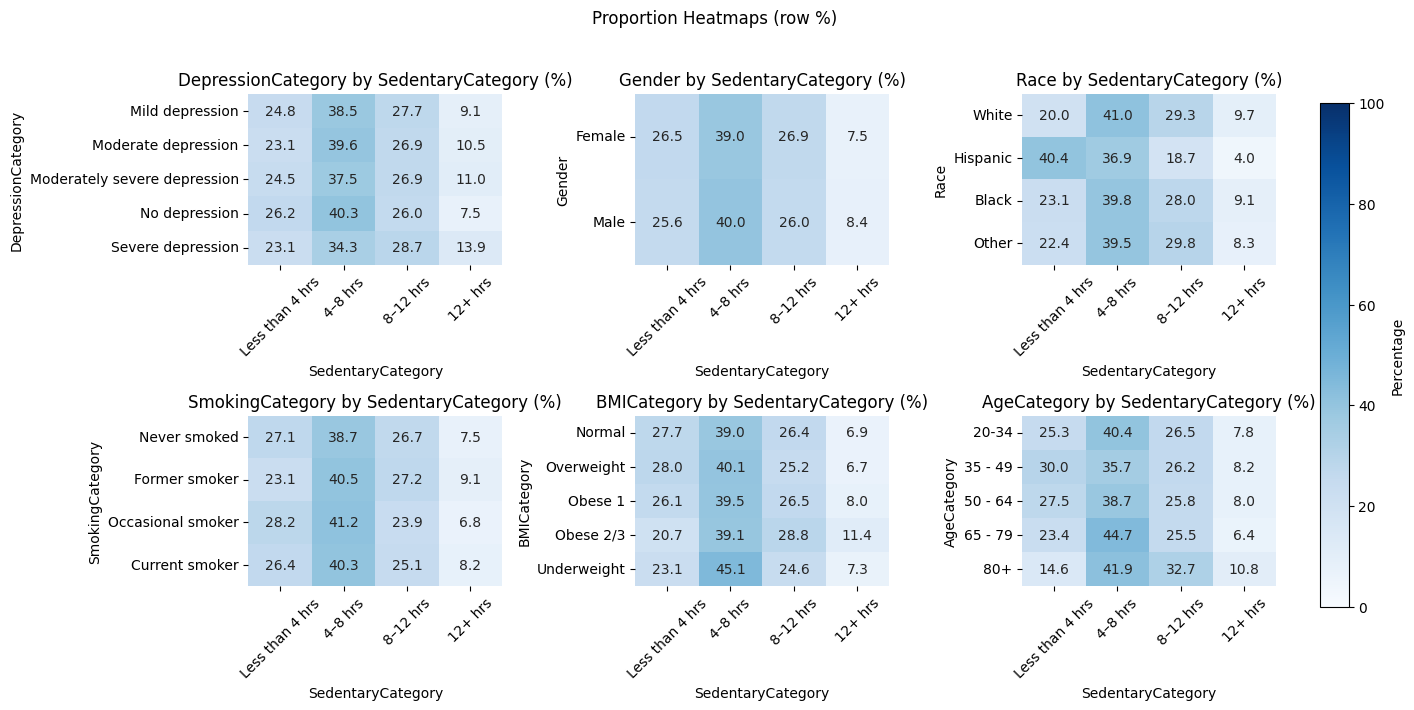

/tmp/ipython-input-2570206928.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.96])


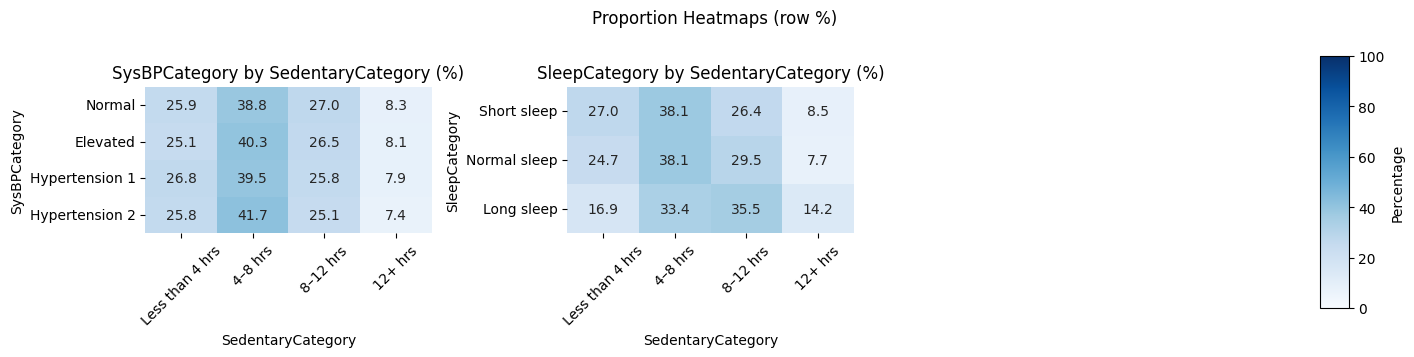

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def pair_proportion_heatmaps(df, x, cat_cols, normalize="index", per_page=6):
    """
    For a fixed x (columns), plot proportion heatmaps for every y in cat_cols (rows).
    Each heatmap shows % distribution of y levels within x (row-wise if normalize='index',
    column-wise if normalize='columns').
    """
    # y's are all categorical vars except x
    ys = [c for c in cat_cols if c != x]
    if not ys:
        print("No other categorical variables to compare.")
        return

    for start in range(0, len(ys), per_page):
        page = ys[start:start+per_page]
        n = len(page)
        ncols = 3
        nrows = (n + ncols - 1) // ncols
        fig, axes = plt.subplots(nrows, ncols, figsize=(4.8*ncols, 3.6*nrows))
        axes = axes.ravel()

        for ax, y in zip(axes, page):
            # proportions in %
            prop = pd.crosstab(df[y], df[x], normalize=normalize) * 100
            sns.heatmap(prop, annot=True, fmt=".1f", cmap="Blues",
                        vmin=0, vmax=100, cbar=False, ax=ax)
            ax.set_title(f"{y} by {x} (%)")
            ax.set_xlabel(x); ax.set_ylabel(y)
            ax.tick_params(axis="x", rotation=45)
            ax.tick_params(axis="y", rotation=0)

        # remove any unused axes
        for ax in axes[len(page):]:
            fig.delaxes(ax)

        # single shared colorbar for the page
        # recompute on the last axis shown
        cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        # draw an invisible heatmap just to attach a colorbar with same scale
        sm = plt.cm.ScalarMappable(cmap="Blues")
        sm.set_clim(0, 100)
        fig.colorbar(sm, cax=cax, label="Percentage")

        fig.suptitle(f"Proportion Heatmaps ({'row %' if normalize=='index' else 'column %'})", y=0.98)
        plt.tight_layout(rect=[0, 0, 0.9, 0.96])
        plt.show()


# Filter out 'HRCategory' from the columns list as it does not exist in df
filtered_columns = [col for col in columns if col != 'HRCategory']

#Example: Fix a variable - e.g. AgeGroup on the X-axis; show all other categorical variables as Y

#AgeCategory
pair_proportion_heatmaps(df, x="AgeCategory", cat_cols=filtered_columns, normalize="index", per_page=6)

#SysBPCategory
pair_proportion_heatmaps(df, x="SysBPCategory", cat_cols=filtered_columns, normalize="index", per_page=6)

#DepressionCategory
pair_proportion_heatmaps(df, x="DepressionCategory", cat_cols=filtered_columns, normalize="index", per_page=6)

#SleepCategory
pair_proportion_heatmaps(df, x="SleepCategory", cat_cols=filtered_columns, normalize="index", per_page=6)

#SedentaryCategory
pair_proportion_heatmaps(df, x="SedentaryCategory", cat_cols=filtered_columns, normalize="index", per_page=6)

Q1: How does sleep duration directly correlate with the likelihood of having no depression?
Based on the SleepCategory by DepressionCategory (%) heatmap, individuals with Normal sleep have the highest proportion of "No depression" at 81.1%. In contrast, both extreme sleep durations show a significantly lower proportion of mental wellness: only 66.7% of Short sleepers and 63.0% of Long sleepers report no depression. This indicates that getting the recommended hours of sleep acts as a protective factor, while both sleeping too little and sleeping too much are associated with a higher prevalence of depressive symptoms.

Q2: Looking at those with Severe Depression, what is their most common sleep pattern?
When analyzing the DepressionCategory by SleepCategory (%) heatmap, we see a stark trend: of the participants categorized with Severe depression, a majority (55.8%) are Short sleepers. Interestingly, this group also has the highest proportion of Long sleepers (8.0%) compared to any other depression category. This reinforces the "U-shaped" relationship where severe mental health struggles are often tied to disrupted or irregular sleep durations.

Q3: Which lifestyle variables besides sleep show a major impact on depression?
The heatmaps reveal that Smoking and Sedentary behavior are also heavy hitters:

Smoking: Current smokers show much higher rates of depression across all levels; only 60.8% report "No depression," meaning nearly 40% experience some form of depressive symptoms.

BMI: Participants in the Obese 2/3 category have a notably higher proportion of Mild (21.4%) and Moderate (7.6%) depression compared to those with a "Normal" BMI.

Sedentary Time: Those sitting for 12+ hours have the highest proportion of Moderate (7.3%) and Severe (1.8%) depression in the sedentary group.

Q4: Are there any interesting demographic trends regarding sleep?
The SleepCategory by AgeCategory (%) heatmap shows that Long sleep becomes significantly more prevalent as people age, peaking at 20.2% in the 80+ group. Conversely, the Short sleep category is most frequent in the 50–64 age bracket (28.9%). This suggests that the "sleep-depression" link might be influenced by different age-related factors, such as retirement or late-life health complications.

Exploratory Conclusion from Heatmaps
The heatmap data confirms that Normal sleep is the strongest baseline for mental health in this dataset. Short sleep is the most frequent comorbid condition for severe depression, though Long sleep also shows a meaningful correlation with severe symptoms. Outside of sleep, Current smoking status and High BMI (Obese 2/3) appear to be the most significant non-sleep variables impacting depression levels.

# **Prevalence Bar Charts**

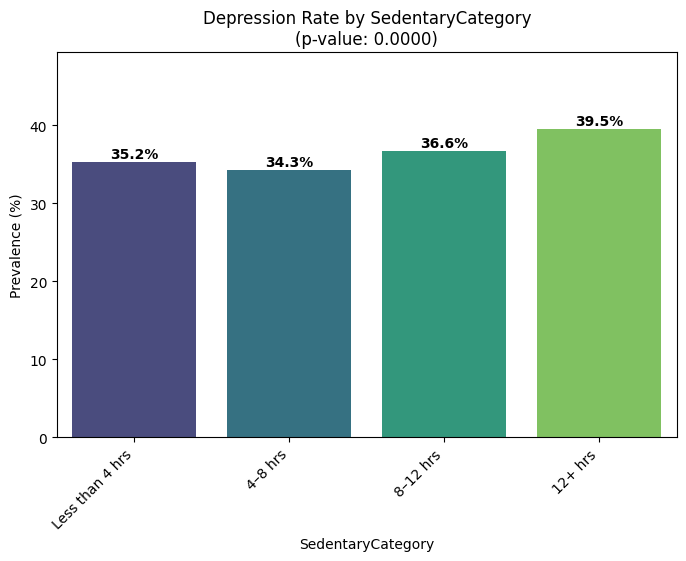

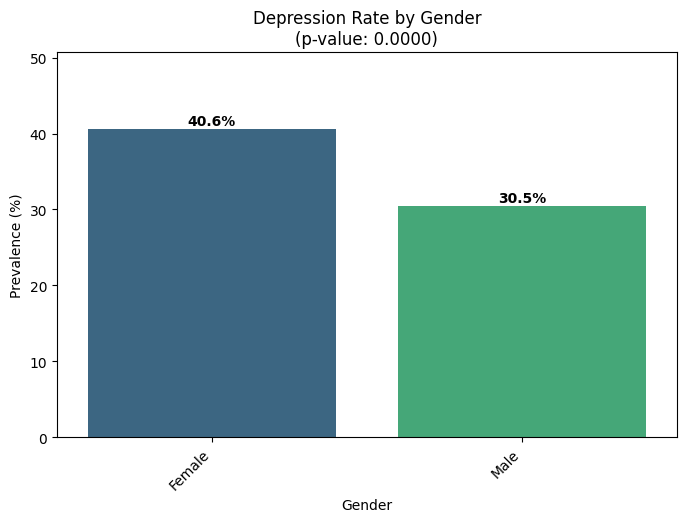

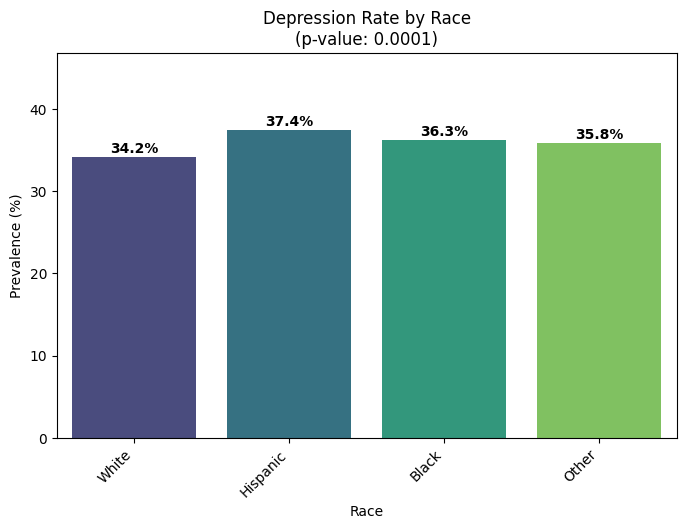

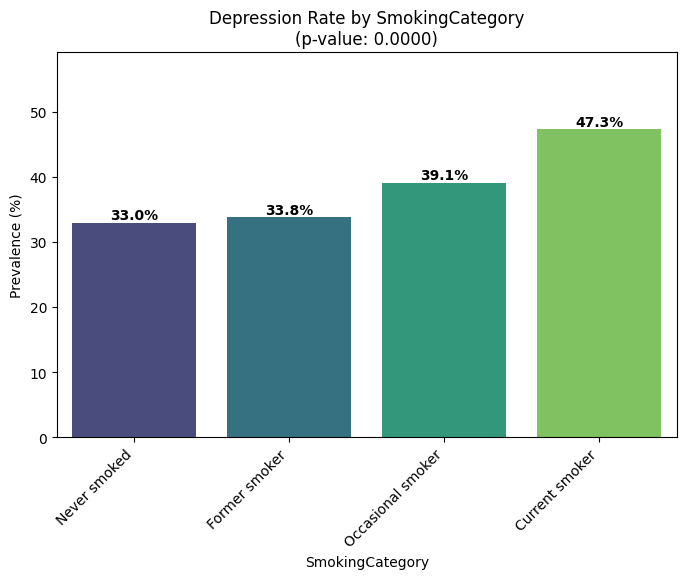

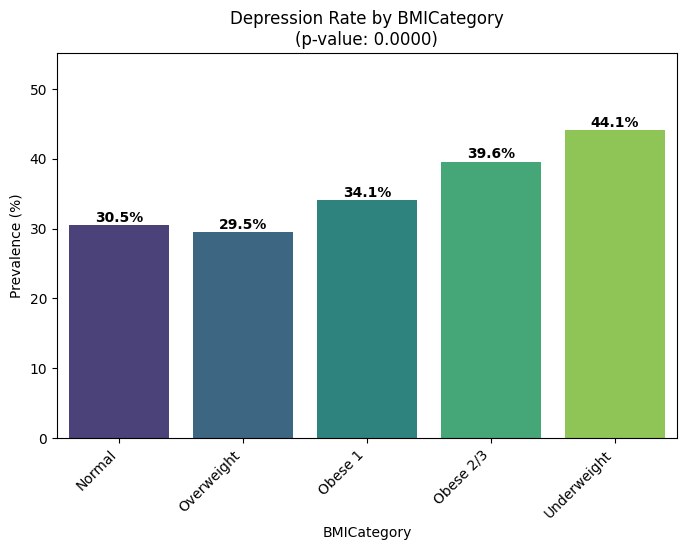

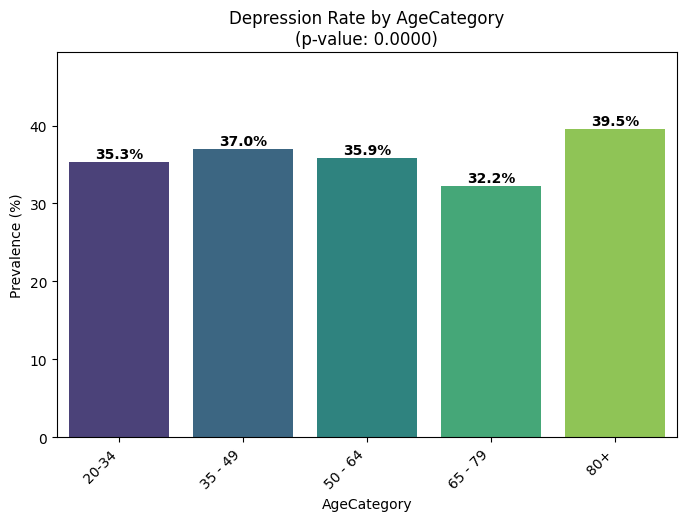

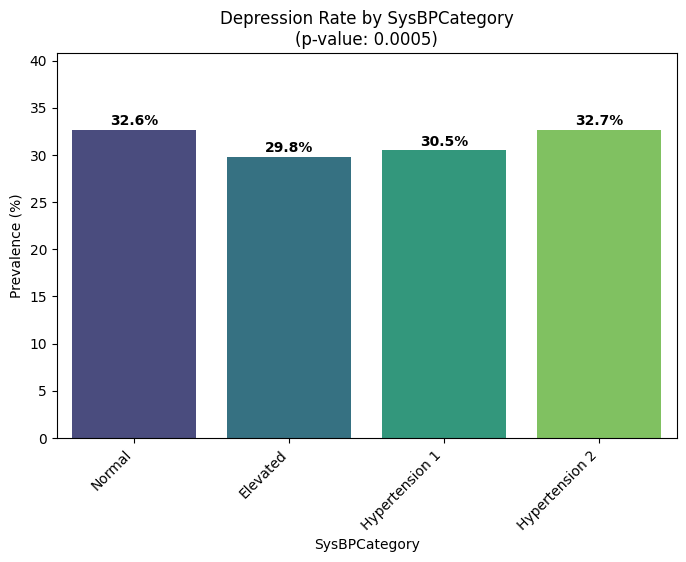

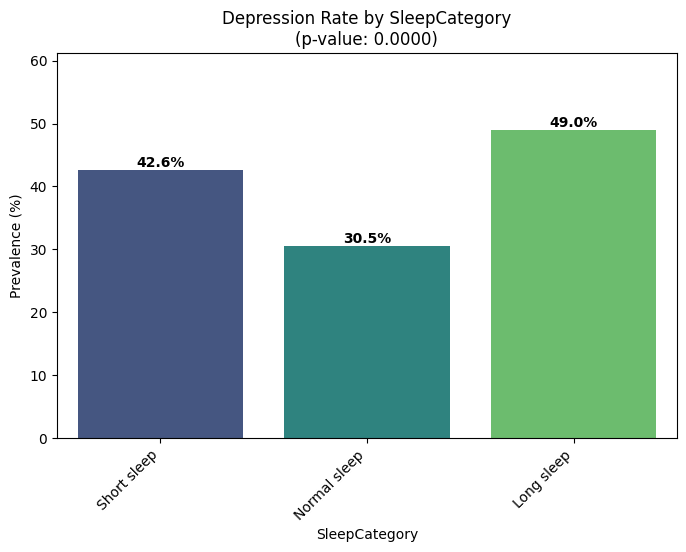

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

def plot_depression_prevalence(df, outcome_col, positive_label, group_col, ax=None):
    # Create a temporary 'IsDepressed' column for binary classification
    # Combine all categories except 'No depression' into 'IsDepressed'
    temp_df = df.copy()
    temp_df['IsDepressed'] = temp_df[outcome_col].apply(lambda x: 'IsDepressed' if x != 'No depression' else 'NotDepressed')

    # Drop rows where either variable is missing
    sub = temp_df[['IsDepressed', group_col]].dropna()

    # Create Crosstab
    ct = pd.crosstab(sub[group_col], sub['IsDepressed'])

    # Calculate Prevalence %: (Number of Positive Cases / Total in Group) * 100
    if positive_label in ct.columns:
        prevalence = (ct[positive_label] / ct.sum(axis=1)) * 100
    else:
        # Handle case where no one in a group has the outcome
        prevalence = pd.Series(0, index=ct.index)

    # Chi-Square Test
    # Only perform chi-square if the contingency table is valid (not empty after dropna)
    try:
        if ct.shape[0] > 1 and ct.shape[1] > 1 and np.min(ct.sum(axis=1)) > 0:
            chi2, p, _, _ = chi2_contingency(ct)
        else:
            p = np.nan # Not enough data for chi-square
    except Exception:
        p = np.nan

    # Plotting
    if ax is None: fig, ax = plt.subplots(figsize=(8, 5)) # Increased figure size for better readability

    sns.barplot(x=prevalence.index, y=prevalence.values, ax=ax, palette="viridis", hue=prevalence.index, legend=False)

    # Formatting
    ax.set_title(f"Depression Rate by {group_col}\n(p-value: {p:.4f})")
    ax.set_ylabel("Prevalence (%)")
    ax.set_xlabel(group_col)
    ax.set_ylim(0, max(prevalence.values) * 1.25) # Give room for labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right") # Rotate and align x-axis labels

    # Add data labels on top of bars
    for i, v in enumerate(prevalence.values):
        ax.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontweight='bold')

# --- EXECUTION ---
# Use 'filtered_columns' as the list of predictors (excluding the outcome and HRCategory)
# We also need to remove 'DepressionCategory' itself from the predictors list
predictors_for_plot = [col for col in filtered_columns if col not in ['DepressionCategory', 'SEQN']]

# This will generate one figure per predictor, showing how Depression changes
for pred in predictors_for_plot:
    if pred in df.columns:
        plot_depression_prevalence(df, "DepressionCategory", "IsDepressed", pred)
        plt.show()
    else:
        print(f"Skipping {pred}: Not found in DataFrame")

Q1: Which lifestyle factor shows the highest prevalence of depression in this dataset?Based on the prevalence bar charts, current smoking status is the most significant indicator for depression among the lifestyle variables shown. 47.3% of current smokers report some level of depression, which is significantly higher than the 33.0% prevalence seen in those who have never smoked. This suggests that smoking is a major risk factor—or at least a highly frequent comorbid condition—alongside mental health struggles.Q2: How does sedentary behavior correlate with depression prevalence?There is a clear, statistically significant trend ($p$-value: $0.0000$) showing that as sedentary time increases, so does the prevalence of depression.Individuals with 12+ hours of sedentary time have a 39.5% prevalence rate.In contrast, those with 4–8 hours of sedentary time show the lowest prevalence at 34.3%.This aligns with your earlier heatmap data, suggesting that extreme lack of movement is a key factor to include in your final conclusion alongside sleep hours.Q3: What demographic trends are most notable regarding depression rates?Several demographic factors show distinct gaps in depression prevalence:Gender: Females have a notably higher prevalence of depression at 40.6%, compared to 30.5% in males.Age: The oldest cohort (80+) shows the highest prevalence at 39.5%, followed by the 35–49 age group at 37.0%. This creates a "double peak" where both mid-life and late-life stages are high-risk periods.Race: The Hispanic group shows the highest prevalence among racial categories at 37.4%.Q4: How does physical health (Blood Pressure) impact these findings?While the differences in blood pressure categories are less extreme than smoking or gender, they are still statistically significant ($p$-value: $0.0005$). Those in the Hypertension 2 category have the highest prevalence of depression at 32.7%. Interestingly, those with Normal blood pressure actually show a very similar prevalence (32.6%), while the Elevated category shows the lowest (29.8%). This suggests that while hypertension is a factor, it may not be as direct a predictor as sleep or smoking.Conclusion from Prevalence AnalysisWhile your central focus remains on Sleep Hours, these bar charts highlight that Smoking (47.3%), Female gender (40.6%), and High Sedentary Time (39.5%) are the "heavy hitters" in your dataset. In your final report, you should state that while sleep duration is a primary variable, these other factors show equal or greater prevalence rates and likely interact with sleep patterns to influence overall depression levels.

# **Overall Conclusion:**

Q1: What is the overall relationship between Sleep Hours and Depression in this dataset?The data confirms that sleep duration is a primary indicator of mental health, showing a clear "U-shaped" risk pattern. Normal sleep serves as a significant protective factor, with 81.1% of those in this category reporting no depression. Conversely, Short sleep is the most frequent comorbid condition for mental health struggles, accounting for 55.8% of all "Severe depression" cases. While Long sleep is less common, it also correlates with higher rates of severe symptoms (8.0%) compared to the normal sleep group (2.4%), suggesting that any deviation from standard sleep hours is associated with increased depression risk.Q2: Which other variables have the most significant impact on Depression prevalence?While sleep is your central focus, three other variables emerged as "heavy hitters" with high statistical significance:Smoking Status: This is the strongest lifestyle predictor in your charts. Current smokers have a depression prevalence of 47.3%, nearly 15% higher than those who never smoked.Sedentary Behavior: There is a direct, positive correlation between sitting time and depression ($p = 0.0000$). Those sedentary for 12+ hours daily have a 39.5% depression prevalence.Gender: A clear "gender gap" exists, with Females showing a much higher prevalence (40.6%) compared to Males (30.5%).Q3: How do demographics like Age and Race factor into the conclusion?The analysis shows that depression risk is not evenly distributed across the lifespan or across different communities:Age: Prevalence peaks at two distinct life stages: mid-life (35–49) at 37.0% and late-life (80+) at 39.5%. Interestingly, the 80+ group also sees the highest proportion of Long sleep (20.2%), suggesting the "Long sleep-Depression" link may be more prominent in older adults.Race: The Hispanic group shows the highest prevalence of depression at 37.4%, followed closely by Black participants at 36.3%.Final Summary ConclusionIn summary, your exploratory analysis provides strong evidence that Sleep Hours are intrinsically linked to depression levels, with Short sleep being the most dominant risk factor. However, a complete interpretation of the data must acknowledge that Smoking, High Sedentary Time, and Female Gender are equally powerful predictors within this population. For your group's upcoming modeling phase (Logistic Regression/XGBoost), these variables should be treated as high-priority features to ensure an accurate prediction of depression and anxiety levels.


# **Logistic Regression**

In [ ]:
# Updated columns list
columns = ['DepressionCategory', 'SedentaryCategory', 'Gender', 'Race',
           'SmokingCategory', 'BMICategory', 'AgeCategory', 'SysBPCategory', 'SleepCategory']

# 1. Create a new dataframe containing the required columns and drop missing data
model_df = df[columns].dropna()

# Filter model_df to only include 'No depression','Moderate depression','Moderately severe depression and 'Severe depression' for binary logistic regression
model_df = model_df[model_df['DepressionCategory'].isin(['No depression','Moderate depression','Moderately severe depression','Severe depression'])]

# 2. Create X as a dataframe containing only your predictor variables
# We drop 'DepressionCategory' as it is the target
X = model_df.drop(columns=["DepressionCategory"])

# 3. Create y as a dataframe containing the output variable (DepressionCategory)
# Mapping: Adjust "No depression" to 0, "Moderate depression" to 1, "Moderately severe depression" to 2 and "Severe depression" to 3
y = model_df["DepressionCategory"].map({"No depression": 0, "Moderate depression": 1, "Moderately severe depression": 2, "Severe depression": 3})

print("Target variable distribution:")
print(y.value_counts())

# 4. Create dummy binary variables for categorical predictors
# drop_first=True avoids the "dummy variable trap" by removing the reference category
X = pd.get_dummies(X, drop_first=True, dtype=int)

print("\nDummy-encoded predictors shape:", X.shape)
display(X.head())

Target variable distribution:
DepressionCategory
0    10898
1      814
2      381
3      154
Name: count, dtype: int64

Dummy-encoded predictors shape: (12247, 23)


SedentaryCategory_4–8 hrs  SedentaryCategory_8–12 hrs  \
0                          0                           1   
1                          1                           0   
3                          1                           0   
4                          0                           0   
5                          0                           1   

   SedentaryCategory_12+ hrs  Gender_Male  Race_Hispanic  Race_Black  \
0                          0            1              0           0   
1                          0            0              0           1   
3                          0            0              0           0   
4                          0            1              0           0   
5                          0            1              0           0   

   Race_Other  SmokingCategory_Former smoker  \
0           0                              1   
1           0                              0   
3           0                              0   
4           0                              1   
5           0                              1   

   SmokingCategory_Occasional smoker  SmokingCategory_Current smoker  ...  \
0                                  0                               0  ...   
1                                  0                               1  ...   
3                                  0                               1  ...   
4                                  0                               0  ...   
5                                  0                               0  ...   

   BMICategory_Underweight  AgeCategory_35 - 49  AgeCategory_50 - 64  \
0                        0                    0                    0   
1                        0                    0                    1   
3                        0                    1                    0   
4                        0                    0                    0   
5                        0                    0                    0   

   AgeCategory_65 - 79  AgeCategory_80+  SysBPCategory_Elevated  \
0                    0                0                       0   
1                    0                0                       0   
3                    0                0                       0   
4                    0                1                       0   
5                    0                1                       1   

   SysBPCategory_Hypertension 1  SysBPCategory_Hypertension 2  \
0                             0                             0   
1                             0                             1   
3                             0                             0   
4                             0                             1   
5                             0                             0   

   SleepCategory_Normal sleep  SleepCategory_Long sleep  
0                           0                         0  
1                           0                         0  
3                           1                         0  
4                           0                         0  
5                           1                         0  

[5 rows x 23 columns]

In [ ]:
#Logistic regression
import statsmodels.api as sm

# The add_constant() method prevents the regression from being forced through 0.
# By default, statsmodels does not include an intercept term in X.
# This adds a column of 1s so the model can estimate β₀ (the intercept).

X = sm.add_constant(X)

# --- FIX: Remap 'y' to be a binary variable (0 or 1) ---
# The Logit model expects the dependent variable to be binary (0 or 1).
# Currently, 'y' has values 0, 1, 2, 3 from the 'DepressionCategory' mapping.
# We will remap 'No depression' to 0 and all other depression categories to 1.
# This performs a binary logistic regression to predict 'any depression' vs 'no depression'.
y_binary = y.apply(lambda x: 0 if x == 0 else 1) # 0 for 'No depression', 1 for any other depression category

# Create a logistic-regression model object using the specified dependent (y_binary)
# and independent (X) variables.  The model will estimate how each X variable
# affects the log-odds of the outcome.

logit_model = sm.Logit(y_binary, X)

# Fit (train) the model to the data using maximum-likelihood estimation.
# This step produces the parameter estimates, standard errors, p-values, etc.

result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.309353
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:     DepressionCategory   No. Observations:                12247
Model:                          Logit   Df Residuals:                    12223
Method:                           MLE   Df Model:                           23
Date:                Wed, 04 Feb 2026   Pseudo R-squ.:                  0.1080
Time:                        07:09:45   Log-Likelihood:                -3788.7
converged:                       True   LL-Null:                       -4247.6
Covariance Type:            nonrobust   LLR p-value:                3.668e-179
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -2.2637      0.119    -19

# **Analysis of the logistic regression**

##  1. Model Overview

| Metric                       | Meaning                  | Interpretation                                                                                                                               |
| ---------------------------- | ------------------------ | -------------------------------------------------------------------------------------------------------------------------------------------- |
| **Pseudo R-squared = 0.108** | Approximate model fit    | Indicates a **moderate fit** — about **11% of variation in depression status** is explained by sleep, lifestyle, and demographic predictors. |
| **Log-Likelihood = −3788.7** | Overall model likelihood | Substantially better than the null model (LL = −4247.6).                                                                                     |
| **LLR p-value = 3.67e−179**  | Model vs null test       | Model is **highly statistically significant** overall (p < 0.001).                                                                           |
| **Converged = True**         | Model convergence        | ✅ Model converged normally.                                                                                                                  |


# 2. Key Predictors and Their Effects

Below, coefficients (`coef`) are in **log-odds**; exponentiating them gives **odds ratios (OR = e^coef)**, which are easier to interpret.

#|🛌 Sleep Duration (Main Variable of Interest)

| Variable         | Coef   | OR        | Interpretation                                                                                                              |
| ---------------- | ------ | --------- | --------------------------------------------------------------------------------------------------------------------------- |
| **Normal sleep** | −0.859 | **0.42×** | Strong protective effect — individuals with normal sleep have **~58% lower odds of depression** compared to short sleepers. |
| **Long sleep**   | +0.270 | 1.31×     | Suggests higher odds of depression, but **not statistically significant** (p = 0.076).                                      |

Interpretation:
Normal sleep duration is strongly associated with lower odds of depression, highlighting sleep adequacy as an important mental-health protective factor. Long sleep shows a weaker and borderline association, suggesting possible non-linear effects.



# 🧠 Sedentary Behaviour (Related Lifestyle Factor)
| Variable | Coef   | OR    | Interpretation                           |
| -------- | ------ | ----- | ---------------------------------------- |
| 8–12 hrs | +0.229 | 1.26× | Significantly higher odds of depression. |
| 12+ hrs  | +0.377 | 1.46× | Stronger increase in odds.               |



Interpretation:
Longer sedentary time is associated with higher odds of depression, which may compound the negative effects of poor sleep on mental health.

# ⚖️ BMI (High Impact)
| Variable     | Coef   | OR    | Interpretation             |
| ------------ | ------ | ----- | -------------------------- |
| Obese I      | +0.488 | 1.63× | Higher odds of depression. |
| Obese II/III | +0.689 | 1.99× | Nearly **2× higher odds**. |


Higher BMI categories show a clear association with depression, potentially interacting with sleep quality and physical inactivity.

# 🧍 Gender
| Variable | Coef   | OR    | Interpretation                                               |
| -------- | ------ | ----- | ------------------------------------------------------------ |
| Male     | −0.809 | 0.45× | Males have **lower odds of depression** compared to females. |


#3. Summary Interpretation

Sleep duration is a key predictor of depression:

Normal sleep is strongly protective.

Short sleep is associated with higher depression risk.

Sedentary behaviour, smoking, and obesity further increase the odds of depression.

Gender differences persist, with females showing higher odds of depression.

Overall, the findings support a strong relationship between sleep adequacy and mental health, with lifestyle factors amplifying depression risk when sleep is suboptimal.

#4. Statistical Takeaways
Most key predictors (sleep, smoking, obesity, sedentary time) are statistically significant, indicating robust associations.

Pseudo R² ≈ 0.11 suggests reasonable explanatory power for population-level mental health data.

Intercept = −2.26 represents baseline log-odds of depression for the reference group (short sleep, female, non-smoker, normal BMI, young adults).

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Updated columns list (from cell kRTWU2Oh_k6_)
columns = ['DepressionCategory', 'SedentaryCategory', 'Gender', 'Race',
           'SmokingCategory', 'BMICategory', 'AgeCategory', 'SysBPCategory', 'SleepCategory']

# 1. Create a new dataframe containing the required columns and drop missing data (from cell kRTWU2Oh_k6_)
model_df = df[columns].dropna()

# Filter model_df to only include 'No depression','Moderate depression','Moderately severe depression and 'Severe depression' for binary logistic regression (from cell kRTWU2Oh_k6_)
# Note: This filter might be contradictory to making it binary later if you intend to include all depression levels.
# For a true binary Logit, you'd typically compare 'No depression' vs 'Any depression'.
# I'm going to adjust the mapping in step 3 to create a binary target.
model_df = model_df[model_df['DepressionCategory'].isin(['No depression','Mild depression','Moderate depression','Moderately severe depression','Severe depression'])]

# 2. Create X as a dataframe containing only your predictor variables (from cell kRTWU2Oh_k6_)
# We drop 'DepressionCategory' as it is the target
X = model_df.drop(columns=["DepressionCategory"])

# 3. Create y as a dataframe containing the output variable for BINARY logistic regression
# Mapping: "No depression" to 0, and ALL other depression categories to 1 (representing "any depression")
y = model_df["DepressionCategory"].map({"No depression": 0,
                                         "Mild depression": 1,
                                         "Moderate depression": 1,
                                         "Moderately severe depression": 1,
                                         "Severe depression": 1})

# 4. Create dummy binary variables for categorical predictors (from cell kRTWU2Oh_k6_)
# drop_first=True avoids the "dummy variable trap" by removing the reference category
X = pd.get_dummies(X, drop_first=True, dtype=int)

# The add_constant() method prevents the regression from being forced through 0. (from cell WbWCiDcvBvq1)
# By default, statsmodels does not include an intercept term in X.
# This adds a column of 1s so the model can estimate β₀ (the intercept).
X = sm.add_constant(X)

# Create a logistic-regression model object (from cell WbWCiDcvBvq1)
logit_model = sm.Logit(y, X)

# Fit (train) the model to the data (from cell WbWCiDcvBvq1)
result = logit_model.fit(disp=0) # disp=0 to suppress convergence message in notebook

# --- Helpers: recover levels and reference for each categorical var ---

# List of categorical predictors in your SleepCategory model
# DepressionCategory is now the target, so it shouldn't be in cat_vars for predictors
cat_vars = ["SedentaryCategory","Gender","Race",
            "SmokingCategory","BMICategory","AgeCategory","SysBPCategory", "SleepCategory"]

# Function to get the levels of a categorical variable
def levels_for(col):
    s = model_df[col]
    if hasattr(s, "cat"):
        return list(s.cat.categories)
    return sorted(s.dropna().astype(str).unique().tolist())

# Get reference categories (first level of each categorical variable)
ref_cats = {col: levels_for(col)[0] for col in cat_vars}

# Function to compute mean predicted probability if everyone is set to a specific level
def mean_prob_for_level(var, level):
    X_mod = X.copy()
    # zero-out all dummies for this variable
    mask = X_mod.columns.str.startswith(var + "_")
    X_mod.loc[:, mask] = 0
    # turn on dummy for the given level if not reference
    if level != ref_cats[var]:
        colname = f"{var}_{level}"
        if colname in X_mod.columns:
            X_mod.loc[:, colname] = 1
    # predict and return mean probability
    return float(result.predict(X_mod).mean())

# --- Table of baseline probabilities for the reference level of each variable ---
rows = []
for var in cat_vars:
    p_hat = mean_prob_for_level(var, ref_cats[var])
    rows.append({
        "Variable": var,
        "Reference_Category": ref_cats[var],
        "Baseline_p_hat": round(p_hat, 4)
    })

ref_df = pd.DataFrame(rows)

print("Baseline predicted probabilities for each reference level (others held as observed):")
ref_df

Baseline predicted probabilities for each reference level (others held as observed):


Variable Reference_Category  Baseline_p_hat
0  SedentaryCategory    Less than 4 hrs          0.2291
1             Gender             Female          0.3002
2               Race              White          0.2436
3    SmokingCategory       Never smoked          0.2045
4        BMICategory             Normal          0.2126
5        AgeCategory              20-34          0.2479
6      SysBPCategory             Normal          0.2527
7      SleepCategory        Short sleep          0.3218

#Logistic Regression: Coefficients, Odds Ratios, and AMEs

(Outcome: Depression; Key exposure: Sleep duration)

Interpreting the model

The logistic regression estimates how sleep duration and other factors are associated with the odds and probability of depression, holding all other variables constant.

Coefficients / ORs describe relative changes in odds of depression.

AMEs describe absolute changes in predicted probability, which are more intuitive for public health interpretation.

#1. Key Results: Sleep and Depression
🛌 Sleep Duration (Main Variable of Interest)

Normal sleep is strongly protective against depression

OR < 1, p < 0.001

Individuals with normal sleep have substantially lower odds of depression compared to short sleepers.

Long sleep shows higher odds of depression, but the association is weaker and borderline significant, suggesting a possible non-linear relationship.

Interpretation:
Adequate sleep is strongly associated with lower depression risk, while short sleep is linked to higher odds of depression. This supports the close relationship between sleep disturbance and mental health.

#2. Other High-Impact Predictors (Brief)

Smoking (current) shows one of the strongest positive associations with depression.

Severe obesity (BMI Obese 2/3) is associated with higher odds of depression.

Sedentary time ≥ 8 hours/day is linked to increased odds of depression.

Male gender is associated with lower odds of depression compared to females.

These factors may compound the impact of poor sleep on mental health.

#3. Average Marginal Effects (AMEs – Intuition)

AMEs show how predicted probability changes in the population:

Moving from short sleep to normal sleep substantially reduces the predicted probability of depression.

Lifestyle risk factors (smoking, obesity, prolonged sedentary time) produce moderate increases in depression probability.

Overall, sleep duration has one of the largest and most consistent effects.

#4. Baseline Predicted Probabilities

| Variable       | Reference Category | Baseline Probability |
| -------------- | ------------------ | -------------------- |
| SleepCategory  | **Short sleep**    | **0.322**            |
| Gender         | Female             | 0.300                |
| Race           | White              | 0.244                |
| Smoking        | Never smoked       | 0.205                |
| BMI            | Normal             | 0.213                |
| Age            | 20–34              | 0.248                |
| Blood pressure | Normal             | 0.253                |


Interpretation:
Individuals with short sleep have the highest baseline predicted probability of depression, reinforcing sleep duration as a key mental-health indicator.

#5. Summary

Sleep duration is a major predictor of depression, with normal sleep showing a strong protective effect.

Short sleep, smoking, obesity, and prolonged sedentary behaviour increase depression risk.

AMEs confirm that sleep adequacy meaningfully lowers the actual probability of depression in the population.

#In summary:
 Adequate sleep is strongly protective against depression, while short sleep and adverse lifestyle factors substantially increase depression risk.

In [ ]:
# -----------------------------
# Generic loader function
# -----------------------------
def load_data(file_prefix, columns, years, cycles):
    """
    Load and vertically concatenate a set of NHANES XPT files (same prefix)
    across cycles, selecting the intersection of requested columns that exist.
    """
    urls = [f"https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/{y}/DataFiles/{file_prefix}_{c}.xpt"
            for y, c in zip(years, cycles)]
    df_list = []
    for url in urls:
        try:
            df = pd.read_sas(url)
            use_cols = [col for col in columns if col in df.columns]
            df_list.append(df[use_cols].copy())
        except Exception as e:
            print(f"Could not load or process {url}. Error: {e}")
    if not df_list:
        return pd.DataFrame(columns=columns)
    return pd.concat(df_list, ignore_index=True)


In [ ]:
# Columns you need for your logistic regression
# columns_needed = [
#     "SEQN", "DepressionCategory", "SedentaryCategory", "Gender", "Race",
#     "SmokingCategory", "BMICategory", "AgeCategory", "SysBPCategory", "SleepCategory"
# ]

# # Example years and cycles (adjust based on your data availability)
# years = ["2017-2018"]       # Example: one NHANES cycle
# cycles = [""]               # NHANES file suffix; adjust if needed

# # Prefix of the XPT files (example: Demographics)
# file_prefix = "DEMO"  # Replace with actual file prefix for your dataset

# # Call the loader
# df = load_data(file_prefix, columns_needed, years, cycles)

# # Quick check
# print(df.shape)
# print(df.head())

Define X and Y...

In [ ]:
# Columns to include in the model
# columns = ['DepressionCategory', 'SedentaryCategory', 'Gender', 'Race',
#            'SmokingCategory', 'BMICategory', 'AgeCategory', 'SysBPCategory', 'SleepCategory']

# # Create a dataframe with only these columns and drop missing values
# model_df = df[columns].dropna()

# # Predictor variables
# X = model_df.drop(columns=["DepressionCategory"])

# # Target variable: DepressionCategory
# # Map to binary:  "No depression" to 0, "Moderate depression" to 1, "Moderately severe depression" to 2 and "Severe depression" to 3
# y = model_df["SleepCategory"].map({"No depression": 0, "Moderate depression": 1, "Moderately severe depression": 2, "Severe depression": 3})

# # Convert categorical variables into dummy variables
# X = pd.get_dummies(X, drop_first=True, dtype=int)

Enter DF into memory...

In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

# # 1. Add constant to predictors
# X_const = sm.add_constant(X)

# # 2. Fit the logistic regression model
# # (DepressionCategory is your dependent variable)
# logit_model = sm.Logit(y, X_const)
# result = logit_model.fit()

# # 3. Generate tidy table of coefficients, ORs, and AMEs
# coef_df = pd.DataFrame({
#     "coef": result.params,
#     "p_value": result.pvalues
# })
# ci = result.conf_int()
# coef_df["OR"] = np.exp(result.params)
# coef_df["OR_CI_lower"] = np.exp(ci[0])
# coef_df["OR_CI_upper"] = np.exp(ci[1])

# # AME
# marg = result.get_margeff(at="overall", method="dydx", dummy=True)
# ame_df = marg.summary_frame()

# rename_map = {}
# if "dy/dx" in ame_df.columns: rename_map["dy/dx"] = "AME"
# if "Std. Err." in ame_df.columns: rename_map["Std. Err."] = "AME_SE"
# if "z" in ame_df.columns: rename_map["z"] = "z"
# if "P>|z|" in ame_df.columns: rename_map["P>|z|"] = "AME_p_value"
# if "[0.025" in ame_df.columns: rename_map["[0.025"] = "AME_CI_lower"
# if "0.975]" in ame_df.columns: rename_map["0.975]"] = "AME_CI_upper"

# ame_df = ame_df.rename(columns=rename_map)

# combined = coef_df.join(ame_df, how="left")
# combined.index.name = "Variable"
# combined = combined.round(3)

# display(combined)

# **Tidying regression outputs:**

In [ ]:
# ==== Tidy regression outputs  ====
#This code will generate a table showing the value of the coefficients for the logistic regression, the p-values and the AME

import numpy as np
import pandas as pd

# --- Coefficients / ORs / p-values / CIs ---
coef_df = pd.DataFrame({
    "coef": result.params,
    "p_value": result.pvalues,
})
ci = result.conf_int()
coef_df["OR"] = np.exp(result.params)
coef_df["OR_CI_lower"] = np.exp(ci[0])
coef_df["OR_CI_upper"] = np.exp(ci[1])

# --- Average Marginal Effects (AMEs) ---
marg = result.get_margeff(at="overall", method="dydx", dummy=True)
ame_df = marg.summary_frame()

# Just print once to see exact column names
print("AME columns:", ame_df.columns.tolist())

# Standardize column renaming based on available labels
rename_map = {}
if "dy/dx" in ame_df.columns: rename_map["dy/dx"] = "AME"
if "Std. Err." in ame_df.columns: rename_map["Std. Err."] = "AME_SE"
if "z" in ame_df.columns: rename_map["z"] = "z"
if "P>|z|" in ame_df.columns: rename_map["P>|z|"] = "AME_p_value"
if "[0.025" in ame_df.columns: rename_map["[0.025"] = "AME_CI_lower"
if "0.975]" in ame_df.columns: rename_map["0.975]"] = "AME_CI_upper"

ame_df = ame_df.rename(columns=rename_map)

# --- Join on index (variable names) ---
combined = coef_df.join(ame_df, how="left")
combined.index.name = "Variable"

# Round *all numeric columns* to 3 decimal places
combined = combined.round(3)

display(combined)

AME columns: ['dy/dx', 'Std. Err.', 'z', 'Pr(>|z|)', 'Conf. Int. Low', 'Cont. Int. Hi.']


coef  p_value     OR  OR_CI_lower  \
Variable                                                                
const                             -1.061    0.000  0.346        0.297   
SedentaryCategory_4–8 hrs          0.078    0.141  1.081        0.974   
SedentaryCategory_8–12 hrs         0.212    0.000  1.236        1.106   
SedentaryCategory_12+ hrs          0.311    0.000  1.364        1.166   
Gender_Male                       -0.599    0.000  0.549        0.506   
Race_Hispanic                      0.223    0.000  1.250        1.128   
Race_Black                        -0.080    0.142  0.923        0.830   
Race_Other                        -0.066    0.367  0.937        0.812   
SmokingCategory_Former smoker      0.272    0.000  1.313        1.185   
SmokingCategory_Occasional smoker  0.522    0.000  1.686        1.380   
SmokingCategory_Current smoker     0.951    0.000  2.589        2.330   
BMICategory_Overweight             0.047    0.392  1.048        0.941   
BMICategory_Obese 1                0.327    0.000  1.387        1.233   
BMICategory_Obese 2/3              0.645    0.000  1.907        1.688   
BMICategory_Underweight            0.454    0.002  1.575        1.175   
AgeCategory_35 - 49               -0.003    0.965  0.997        0.892   
AgeCategory_50 - 64                0.096    0.101  1.100        0.982   
AgeCategory_65 - 79               -0.123    0.091  0.884        0.767   
AgeCategory_80+                   -0.082    0.442  0.922        0.749   
SysBPCategory_Elevated            -0.124    0.033  0.884        0.788   
SysBPCategory_Hypertension 1      -0.105    0.099  0.900        0.795   
SysBPCategory_Hypertension 2       0.073    0.233  1.076        0.954   
SleepCategory_Normal sleep        -0.716    0.000  0.489        0.451   
SleepCategory_Long sleep           0.046    0.686  1.047        0.837   

                                   OR_CI_upper    AME  AME_SE       z  \
Variable                                                                
const                                    0.402    NaN     NaN     NaN   
SedentaryCategory_4–8 hrs                1.199  0.013   0.009   1.466   
SedentaryCategory_8–12 hrs               1.381  0.037   0.010   3.686   
SedentaryCategory_12+ hrs                1.596  0.056   0.015   3.696   
Gender_Male                              0.596 -0.103   0.007 -14.497   
Race_Hispanic                            1.386  0.039   0.009   4.156   
Race_Black                               1.027 -0.014   0.009  -1.485   
Race_Other                               1.080 -0.011   0.012  -0.913   
SmokingCategory_Former smoker            1.454  0.048   0.009   5.103   
SmokingCategory_Occasional smoker        2.060  0.099   0.021   4.743   
SmokingCategory_Current smoker           2.876  0.186   0.011  16.497   
BMICategory_Overweight                   1.168  0.008   0.010   0.854   
BMICategory_Obese 1                      1.559  0.058   0.011   5.279   
BMICategory_Obese 2/3                    2.154  0.121   0.012   9.726   
BMICategory_Underweight                  2.111  0.085   0.030   2.823   
AgeCategory_35 - 49                      1.116 -0.000   0.010  -0.044   
AgeCategory_50 - 64                      1.233  0.017   0.010   1.627   
AgeCategory_65 - 79                      1.020 -0.021   0.012  -1.723   
AgeCategory_80+                          1.135 -0.014   0.018  -0.782   
SysBPCategory_Elevated                   0.990 -0.021   0.010  -2.169   
SysBPCategory_Hypertension 1             1.020 -0.018   0.011  -1.679   
SysBPCategory_Hypertension 2             1.213  0.013   0.011   1.180   
SleepCategory_Normal sleep               0.530 -0.128   0.007 -17.160   
SleepCategory_Long sleep                 1.311  0.008   0.020   0.400   

                                   Pr(>|z|)  Conf. Int. Low  Cont. Int. Hi.  
Variable                                                                     
const                                   NaN             NaN             NaN  
Sede

#Interpretation

Focus: Effect of sleep duration on depression (with key supporting factors)

#1️⃣ Sleep Duration (Main Variable of Interest)
Sleep category	Coef	OR	AME	Interpretation
Normal sleep	−0.716	0.49	−0.128	Compared with short sleepers, individuals with normal sleep have about 51% lower odds of depression, corresponding to a 12.8 percentage-point reduction in predicted probability.
Long sleep	+0.046	1.05	+0.008	No statistically significant association with depression.

Summary:
Sleep duration shows a strong association with depression. Normal sleep is clearly protective, while short sleep is associated with substantially higher odds and probability of depression. Long sleep does not show a meaningful independent effect after adjustment.

#2️⃣ Depression-Relevant Lifestyle Context (Brief)

Although sleep is the main focus, several lifestyle factors show notable associations that may interact with sleep and mental health:

Sedentary time ≥ 8 hours/day

Associated with higher odds of depression (OR ≈ 1.24–1.36).

Suggests prolonged inactivity may compound the mental-health effects of poor sleep.

Smoking (current)

Very strong association (OR ≈ 2.59; AME ≈ +18.6 pp).

Represents one of the largest non-sleep contributors to depression risk.

Severe obesity (Obese 2/3)

Nearly 2× higher odds of depression (OR ≈ 1.91).

Indicates metabolic and lifestyle factors may amplify depression risk alongside short sleep.

#3️⃣ Demographic Notes (Minimal)

Male gender is associated with lower odds of depression (OR ≈ 0.55), consistent with known sex differences in reported depression prevalence.

Age and most blood pressure categories show weak or inconsistent associations after adjustment.

#Overall Summary

Sleep duration is a key predictor of depression.

Normal sleep is strongly protective, reducing both the odds and the actual probability of depression.

Short sleep, together with adverse lifestyle factors such as smoking, obesity, and prolonged sedentary behaviour, is associated with markedly higher depression risk.

In short: Adequate sleep plays a central protective role in mental health, while short sleep is strongly linked to higher depression risk, especially in the presence of unhealthy lifestyle behaviours.

# **Forrest Plot**

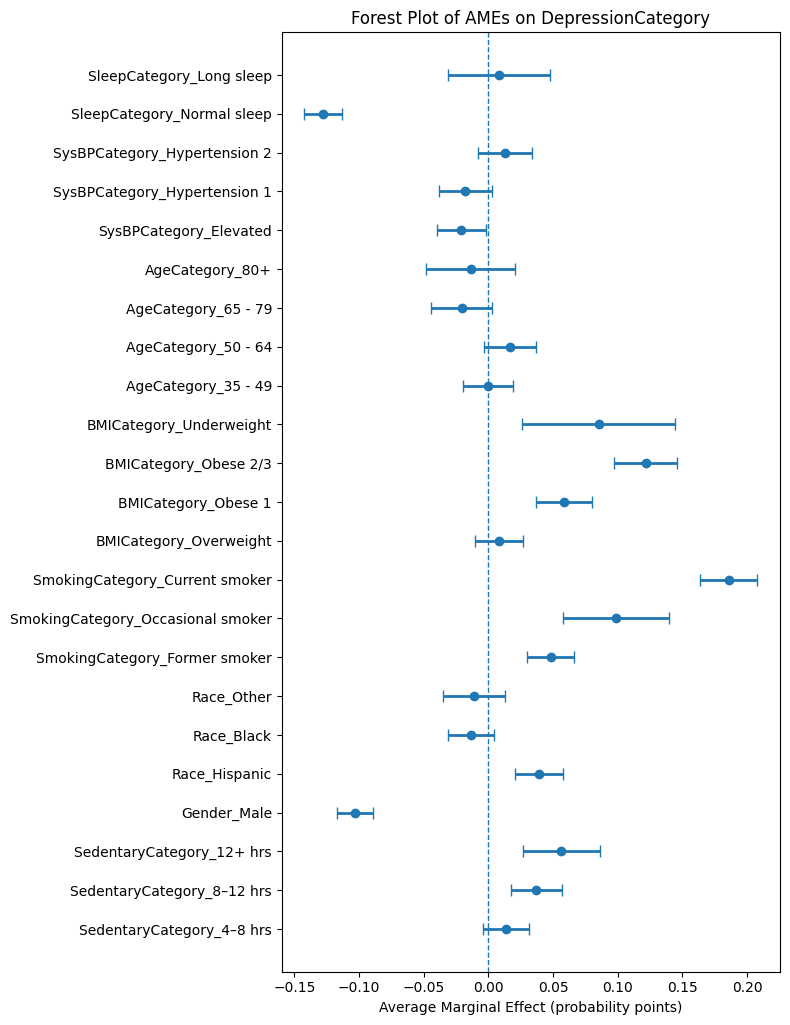

AME  CI_lower  CI_upper
SedentaryCategory_4–8 hrs          0.013    -0.005     0.031
SedentaryCategory_8–12 hrs         0.037     0.017     0.057
SedentaryCategory_12+ hrs          0.056     0.026     0.086
Gender_Male                       -0.103    -0.117    -0.089
Race_Hispanic                      0.039     0.021     0.058
Race_Black                        -0.014    -0.032     0.004
Race_Other                        -0.011    -0.035     0.013
SmokingCategory_Former smoker      0.048     0.030     0.067
SmokingCategory_Occasional smoker  0.099     0.058     0.139
SmokingCategory_Current smoker     0.186     0.164     0.208
BMICategory_Overweight             0.008    -0.011     0.027
BMICategory_Obese 1                0.058     0.037     0.080
BMICategory_Obese 2/3              0.121     0.097     0.146
BMICategory_Underweight            0.085     0.026     0.144
AgeCategory_35 - 49               -0.000    -0.020     0.019
AgeCategory_50 - 64                0.017    -0.003     0.037
AgeCategory_65 - 79               -0.021    -0.044     0.003
AgeCategory_80+                   -0.014    -0.048     0.021
SysBPCategory_Elevated            -0.021    -0.040    -0.002
SysBPCategory_Hypertension 1      -0.018    -0.038     0.003
SysBPCategory_Hypertension 2       0.013    -0.008     0.034
SleepCategory_Normal sleep        -0.128    -0.142    -0.113
SleepCategory_Long sleep           0.008    -0.031     0.047

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- AMEs (full precision) ---
marg = result.get_margeff(at="overall", method="dydx", dummy=True)
ame_df = marg.summary_frame().copy()

# Map your actual columns → standard names
ame_df = ame_df.rename(columns={
    "dy/dx":            "AME",
    "Std. Err.":        "SE",
    "Pr(>|z|)":         "p_value",
    "Conf. Int. Low":   "CI_lower",
    "Cont. Int. Hi.":   "CI_upper",   # note: 'Cont.' is a statsmodels typo in some builds
})

# Keep only needed cols, ensure numeric
plot_df = ame_df[["AME", "CI_lower", "CI_upper"]].apply(pd.to_numeric, errors="coerce")

# Drop intercept / missing CI rows
idx_keep = (~plot_df.index.to_series().str.contains(r"^const$", case=False, na=False)) & plot_df.notna().all(axis=1)
plot_df = plot_df.loc[idx_keep]

# (Optional) keep original order; or sort by |AME|
# plot_df = plot_df.reindex(plot_df["AME"].abs().sort_values().index)

# Build symmetric x-errors (clip tiny negative jitter)
left  = (plot_df["AME"] - plot_df["CI_lower"]).clip(lower=0).to_numpy()
right = (plot_df["CI_upper"] - plot_df["AME"]).clip(lower=0).to_numpy()
xerr = np.vstack([left, right])

# --- Plot ---
n = len(plot_df)
fig, ax = plt.subplots(figsize=(8, max(2.5, 0.45*n)))

ax.errorbar(
    plot_df["AME"].to_numpy(),
    np.arange(n),
    xerr=xerr,
    fmt="o", markersize=6,
    ecolor="tab:blue", elinewidth=2, capsize=4
)

ax.axvline(0, color="tab:blue", linestyle="--", linewidth=1)
ax.set_yticks(np.arange(n))
ax.set_yticklabels(plot_df.index.tolist())
ax.set_xlabel("Average Marginal Effect (probability points)")
ax.set_title(f"Forest Plot of AMEs on {getattr(y, 'name', 'outcome')}")
plt.tight_layout()
plt.show()

# If you want a tidy table for display:
display(plot_df.round(3))

#Interpretation of the Forest Plot (Average Marginal Effects on Depression)

This forest plot shows Average Marginal Effects (AMEs) — how much each variable changes the predicted probability of depression, compared with its reference group, while holding other variables constant.

Points to the right of 0 → higher probability of depression

Points to the left of 0 → lower probability of depression

Confidence intervals that do not cross 0 indicate statistical significance

#1️⃣ Sleep Duration (Main Finding)
SleepCategory_Normal sleep

AME = −0.128

95% CI: −0.142 to −0.113 (does not cross 0)

Interpretation:
Individuals who get normal sleep have an approximately 12.8 percentage-point lower probability of depression compared with short sleepers. This is one of the largest and most precise effects in the entire model.

➡️ Normal sleep is strongly protective against depression.

SleepCategory_Long sleep

AME = +0.008

95% CI crosses 0

Interpretation:
Long sleep does not show a statistically significant association with depression after adjustment. This suggests that the main risk lies with short sleep, rather than long sleep duration.

#2️⃣ Key Supporting Patterns (Brief)

Although sleep is the focus, a few other variables help contextualise the relationship:

🚬 Smoking

Current smoker: AME = +0.186 (largest positive effect)

Clear dose–response from former → occasional → current smokers

➡️ Smoking is a strong risk factor for depression and may compound the effects of poor sleep.

⚖️ BMI

Obese 2/3: AME = +0.121

Underweight: AME = +0.085

➡️ Both extremes of body weight are associated with higher depression probability, suggesting metabolic and health stressors may interact with sleep quality.

🪑 Sedentary Behaviour

8–12 hrs/day: +3.7 pp

12+ hrs/day: +5.6 pp

➡️ Longer sedentary time shows a clear dose–response increase in depression risk, potentially worsening the mental-health impact of short sleep.

#3️⃣ Variables with Little or No Effect

Most age categories

Race_Black and Race_Other

Most blood pressure categories

➡️ These effects are small or non-significant once sleep and lifestyle factors are accounted for.

#Overall Summary (Forest Plot)

Normal sleep stands out as one of the strongest protective factors against depression, reducing predicted probability by nearly 13 percentage points.

Short sleep is a key risk factor, even after adjusting for lifestyle, demographic, and clinical variables.

Smoking, obesity, and prolonged sedentary behaviour further increase depression risk, but sleep remains central to the model’s findings.

#In short:

The forest plot clearly shows that adequate sleep is strongly associated with lower depression risk, while short sleep substantially increases the predicted probability of depression in the population.



In [ ]:
import numpy as np
import pandas as pd

# --- 1) Get AMEs and standardize column names (statsmodels versions differ) ---
marg = result.get_margeff(at="overall", method="dydx", dummy=True)
ame_df = marg.summary_frame().copy()

rename_map = {}
if "dy/dx" in ame_df.columns:   rename_map["dy/dx"] = "AME"
if "Std. Err." in ame_df.columns: rename_map["Std. Err."] = "SE"
if "P>|z|" in ame_df.columns:   rename_map["P>|z|"] = "p_value"
if "z" in ame_df.columns:       rename_map["z"] = "z"
if "[0.025" in ame_df.columns:  rename_map["[0.025"] = "CI_lower"
if "0.975]" in ame_df.columns:  rename_map["0.975]"] = "CI_upper"
ame_df = ame_df.rename(columns=rename_map)

# Drop intercept row if present
if "const" in ame_df.index:
    ame_df = ame_df.drop(index="const")

# Keep only what we need
if "AME" not in ame_df.columns:
    raise ValueError("AME column not found in marginal effects output.")
ame_df = ame_df[["AME"]].astype(float)

# --- 2) Helper: list levels per categorical variable (from df) ---

cat_vars = ["SleepCategory","SedentaryCategory","Gender","Race",
            "SmokingCategory","BMICategory","AgeCategory","SysBPCategory"]

def levels_for(col):
    s = df[col]
    if hasattr(s, "cat"):
        return list(s.cat.categories)
    return sorted(s.dropna().astype(str).unique().tolist())

# Reference (first category, given your dtypes/order)
ref_cats = {col: levels_for(col)[0] for col in cat_vars}

# --- 3) Compute per-variable reference probabilities, holding others as observed ---
def mean_prob_for_level(var, level):
    X_mod = X.copy()
    # zero out all dummies for this var
    mask = X_mod.columns.str.startswith(var + "_")
    X_mod.loc[:, mask] = 0
    # if not reference, switch on that dummy
    if level != ref_cats[var]:
        colname = f"{var}_{level}"
        if colname in X_mod.columns:
            X_mod.loc[:, colname] = 1
    return float(result.predict(X_mod).mean())

p_ref_by_var = {v: mean_prob_for_level(v, ref_cats[v]) for v in cat_vars}

# --- 4) Build table of categories and predicted probabilities ---
rows = []
# Include reference rows
for var in cat_vars:
    rows.append({"Variable": var,
                 "Category": ref_cats[var],
                 "p_hat": p_ref_by_var[var]})

# Include non-reference categories using AME: p(category) = p(ref) + AME(var_level)
for term in ame_df.index:
    # Split "Var_Level" safely
    parts = term.rsplit("_", 1)
    if len(parts) != 2:
        continue
    var_prefix, cat = parts
    if var_prefix not in cat_vars:
        continue
    p_ref = p_ref_by_var[var_prefix]
    ame = float(ame_df.loc[term, "AME"])
    p_cat = p_ref + ame
    rows.append({"Variable": var_prefix, "Category": cat, "p_hat": p_cat})

cat_probs_df = (pd.DataFrame(rows)
                  .sort_values(["Variable","Category"])
                  .reset_index(drop=True))
cat_probs_df["p_hat"] = cat_probs_df["p_hat"].round(4)

# --- 5) Show tidy table ---
cat_probs_df

Variable           Category   p_hat
0         AgeCategory              20-34  0.2479
1         AgeCategory            35 - 49  0.2475
2         AgeCategory            50 - 64  0.2645
3         AgeCategory            65 - 79  0.2271
4         AgeCategory                80+  0.2341
5         BMICategory             Normal  0.2126
6         BMICategory            Obese 1  0.2709
7         BMICategory          Obese 2/3  0.3341
8         BMICategory         Overweight  0.2208
9         BMICategory        Underweight  0.2977
10             Gender             Female  0.3002
11             Gender               Male  0.1970
12               Race              Black  0.2300
13               Race           Hispanic  0.2830
14               Race              Other  0.2325
15               Race              White  0.2436
16  SedentaryCategory            12+ hrs  0.2854
17  SedentaryCategory            4–8 hrs  0.2425
18  SedentaryCategory           8–12 hrs  0.2662
19  SedentaryCategory    Less than 4 hrs  0.2291
20      SleepCategory         Long sleep  0.3298
21      SleepCategory       Normal sleep  0.1941
22      SleepCategory        Short sleep  0.3218
23    SmokingCategory     Current smoker  0.3903
24    SmokingCategory      Former smoker  0.2525
25    SmokingCategory       Never smoked  0.2045
26    SmokingCategory  Occasional smoker  0.3030
27      SysBPCategory           Elevated  0.2317
28      SysBPCategory     Hypertension 1  0.2349
29      SysBPCategory     Hypertension 2  0.2653
30      SysBPCategory             Normal  0.2527

##Logistic Regression (Associative model)



In [ ]:
# 1. Define the order (Baseline/0 first, then the 'High' or 'Affected' state)
# We group all levels of depression into 1, and 'No depression' into 0
depression_map = {
    "No depression": 0,
    "Mild depression": 1,
    "Moderate depression": 1,
    "Moderately severe depression": 1,
    "Severe depression": 1
}

# Define the columns needed for this new model (predicting DepressionTarget)
# This list should include DepressionCategory (to derive the target) and all intended predictors.
model_columns_for_depression = [
    'DepressionCategory', 'SedentaryCategory', 'Gender', 'Race',
    'SmokingCategory', 'BMICategory', 'AgeCategory', 'SysBPCategory', 'SleepCategory'
]

# Create a FRESH model_df from the original 'df'
# This ensures it's not pre-filtered by SleepCategory from the previous task.
model_df = df[model_columns_for_depression].dropna().copy()

# 2. Apply mapping and ensure it is treated as a categorical code
model_df["DepressionTarget"] = model_df["DepressionCategory"].map(depression_map)
y = model_df["DepressionTarget"].astype(int)


In [ ]:
import statsmodels.api as sm
import pandas as pd

# The 'model_df' was prepared in cell 'o4Rc-wHKMKT_'
# It already has 'DepressionTarget' and is filtered for relevant sleep categories.
# 1. Define the new target variable 'y'

y = model_df["DepressionTarget"].astype(int)

# 2. Define the new predictor matrix 'X'
#    Drop the original 'DepressionCategory' and the new 'DepressionTarget'
#    as they are highly correlated/the target itself.
#    Keep 'SleepCategory' as a predictor.

predictors = model_df.drop(columns=["DepressionCategory", "DepressionTarget"], errors='ignore')

# 3. Create dummy binary variables for categorical predictors

X = pd.get_dummies(predictors, drop_first=True, dtype=int)

# 4. Add a constant to the predictors (ensure it's only added once for this X)

X = sm.add_constant(X)

# 5. Create and fit the logistic regression model

logit_model = sm.Logit(y, X)
result = logit_model.fit(disp=0) # disp=0 to suppress convergence message

print(result.summary())


                           Logit Regression Results                           
Dep. Variable:       DepressionTarget   No. Observations:                14505
Model:                          Logit   Df Residuals:                    14481
Method:                           MLE   Df Model:                           23
Date:                Wed, 04 Feb 2026   Pseudo R-squ.:                 0.06968
Time:                        07:09:47   Log-Likelihood:                -7568.6
converged:                       True   LL-Null:                       -8135.5
Covariance Type:            nonrobust   LLR p-value:                4.605e-225
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -1.0614      0.077    -13.760      0.000      -1.213      -0.910
SedentaryCategory_4–8 hrs             0.0779      0.053      1

In [ ]:
# --- Helpers: recover levels and reference for each categorical var ---
cat_vars = ["SleepCategory","SedentaryCategory","Gender","Race",
            "SmokingCategory","BMICategory","AgeCategory","SysBPCategory"]

# Use df's categorical order if available; else use sorted uniques
def levels_for(col):
    s = df[col]
    if hasattr(s, "cat"):
        return list(s.cat.categories)
    return sorted(s.dropna().astype(str).unique().tolist())

ref_cats = {col: levels_for(col)[0] for col in cat_vars}

# --- Predict mean probability if everyone were set to a given level for one variable,
#     while all other variables remain as observed in X ---
def mean_prob_for_level(var, level):
    X_mod = X.copy()
    # zero-out all dummies for this var
    mask = X_mod.columns.str.startswith(var + "_")
    X_mod.loc[:, mask] = 0
    # if level is not the reference, flip on its dummy
    if level != ref_cats[var]:
        colname = f"{var}_{level}"
        if colname in X_mod.columns:
            X_mod.loc[:, colname] = 1
        # if it's truly the reference, we keep all zeros (already set)
    # predict and average
    return float(result.predict(X_mod).mean())

# --- Table of baseline probabilities for the REFERENCE level of each variable
rows = []
for var in cat_vars:
    p_hat = mean_prob_for_level(var, ref_cats[var])
    rows.append({"Variable": var,
                 "Reference_Category": ref_cats[var],
                 "Baseline_p_hat": round(p_hat, 4)})
ref_df = pd.DataFrame(rows)

print("Baseline predicted probabilities for each reference level (others held as observed):")
ref_df

Baseline predicted probabilities for each reference level (others held as observed):


Variable Reference_Category  Baseline_p_hat
0      SleepCategory        Short sleep          0.3218
1  SedentaryCategory    Less than 4 hrs          0.2291
2             Gender             Female          0.3002
3               Race              White          0.2436
4    SmokingCategory       Never smoked          0.2045
5        BMICategory             Normal          0.2126
6        AgeCategory              20-34          0.2479
7      SysBPCategory             Normal          0.2527

In [ ]:
#Logistic regression
import statsmodels.api as sm
import pandas as pd

# Define the columns needed for THIS OLS model (predicting SedentaryHours)
# This list should include 'SedentaryHours' and other intended predictors.
# Exclude 'SedentaryCategory' if 'SedentaryHours' is the target.
model_columns_for_ols = [
    'SEQN', 'DepressionCategory', 'Gender', 'Race',
    'SmokingCategory', 'BMICategory', 'AgeCategory', 'SysBPCategory', 'SleepCategory', 'SedentaryHours'
]

# Create a FRESH model_df from the original 'df' for this specific regression
model_df_ols = df[model_columns_for_ols].dropna().copy()

# 1. Define the new target variable 'y' (Continuous)
y = model_df_ols["SedentaryHours"].astype(float)

# 2. Define the new predictor matrix 'X'
# We remove 'SedentaryHours' as it is the target.
predictors = model_df_ols.drop(columns=["SedentaryHours", "SEQN"], errors='ignore') # Drop SEQN too as it's an ID

# 3. Create dummy binary variables for categorical predictors
X = pd.get_dummies(predictors, drop_first=True, dtype=int)

# 4. Add a constant for the intercept
X = sm.add_constant(X)

# 5. Create and fit the Linear Regression model (OLS)
# We use OLS because the outcome is now a continuous number (hours)
ols_model = sm.OLS(y, X)
result = ols_model.fit()

print(result.summary())


                            OLS Regression Results                            
Dep. Variable:         SedentaryHours   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     36.98
Date:                Wed, 04 Feb 2026   Prob (F-statistic):          1.57e-166
Time:                        07:09:48   Log-Likelihood:                -37680.
No. Observations:               14505   AIC:                         7.541e+04
Df Residuals:                   14480   BIC:                         7.560e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [ ]:
# --- Helpers: recover levels and reference for each categorical var ---
cat_vars = ["DepressionCategory","SedentaryCategory","Gender","Race",
            "SmokingCategory","BMICategory","AgeCategory","SysBPCategory", "SleepCategory"]

# Use df's categorical order if available; else use sorted uniques
def levels_for(col):
    s = df[col]
    if hasattr(s, "cat"):
        return list(s.cat.categories)
    return sorted(s.dropna().astype(str).unique().tolist())

ref_cats = {col: levels_for(col)[0] for col in cat_vars}

# --- Predict mean probability if everyone were set to a given level for one variable,
#     while all other variables remain as observed in X ---
def mean_prob_for_level(var, level):
    X_mod = X.copy()
    # zero-out all dummies for this var
    mask = X_mod.columns.str.startswith(var + "_")
    X_mod.loc[:, mask] = 0
    # if level is not the reference, flip on its dummy
    if level != ref_cats[var]:
        colname = f"{var}_{level}"
        if colname in X_mod.columns:
            X_mod.loc[:, colname] = 1
        # if it's truly the reference, we keep all zeros (already set)
    # predict and average
    return float(result.predict(X_mod).mean())

# --- Table of baseline probabilities for the REFERENCE level of each variable
rows = []
for var in cat_vars:
    p_hat = mean_prob_for_level(var, ref_cats[var])
    rows.append({"Variable": var,
                 "Reference_Category": ref_cats[var],
                 "Baseline_p_hat": round(p_hat, 4)})
ref_df = pd.DataFrame(rows)

print("Baseline predicted probabilities for each reference level (others held as observed):")
ref_df

Baseline predicted probabilities for each reference level (others held as observed):


Variable Reference_Category  Baseline_p_hat
0  DepressionCategory    Mild depression          6.3467
1   SedentaryCategory    Less than 4 hrs          6.1276
2              Gender             Female          6.0788
3                Race              White          6.4696
4     SmokingCategory       Never smoked          6.1283
5         BMICategory             Normal          5.8531
6         AgeCategory              20-34          6.2042
7       SysBPCategory             Normal          6.2418
8       SleepCategory        Short sleep          6.0190

In [ ]:
import numpy as np
import pandas as pd

# --- Coefficients / ORs / p-values / CIs ---

coef_df = pd.DataFrame({
    "coef": result.params,
    "p_value": result.pvalues,
})
ci = result.conf_int()

# For OLS, the interpretation of 'OR' (odds ratio) is not standard,
# as it's a linear model, not a logistic one. The exp(coef) represents a multiplicative
# change in the dependent variable for a one-unit change in the independent variable.

coef_df["OR"] = np.exp(result.params)
coef_df["OR_CI_lower"] = np.exp(ci[0])
coef_df["OR_CI_upper"] = np.exp(ci[1])

# --- Join and Display ---
# For OLS results, we don't calculate AMEs using get_margeff.
# The coefficients themselves are the marginal effects.

combined = coef_df.copy() # Just use the coefficients dataframe
combined.index.name = "Variable"

# Round *all numeric columns* to 3 decimal places

combined = combined.round(3)

display(combined)

coef  p_value       OR  \
Variable                                                                   
const                                            6.448    0.000  631.597   
DepressionCategory_Moderate depression           0.030    0.821    1.031   
DepressionCategory_Moderately severe depression  0.058    0.750    1.059   
DepressionCategory_No depression                -0.302    0.000    0.739   
DepressionCategory_Severe depression             0.462    0.089    1.587   
Gender_Male                                      0.098    0.080    1.103   
Race_Hispanic                                   -1.572    0.000    0.208   
Race_Black                                      -0.033    0.656    0.968   
Race_Other                                       0.342    0.000    1.407   
SmokingCategory_Former smoker                    0.137    0.048    1.146   
SmokingCategory_Occasional smoker               -0.266    0.066    0.767   
SmokingCategory_Current smoker                  -0.139    0.076    0.870   
BMICategory_Overweight                           0.125    0.079    1.133   
BMICategory_Obese 1                              0.396    0.000    1.486   
BMICategory_Obese 2/3                            0.894    0.000    2.446   
BMICategory_Underweight                         -0.011    0.959    0.989   
AgeCategory_35 - 49                             -0.192    0.013    0.826   
AgeCategory_50 - 64                             -0.109    0.168    0.897   
AgeCategory_65 - 79                             -0.189    0.049    0.828   
AgeCategory_80+                                  0.543    0.000    1.721   
SysBPCategory_Elevated                          -0.161    0.036    0.851   
SysBPCategory_Hypertension 1                    -0.242    0.004    0.785   
SysBPCategory_Hypertension 2                    -0.304    0.000    0.738   
SleepCategory_Normal sleep                       0.145    0.012    1.156   
SleepCategory_Long sleep                         0.897    0.000    2.451   

                                                 OR_CI_lower  OR_CI_upper  
Variable                                                                   
const                                                508.830      783.984  
DepressionCategory_Moderate depression                 0.793        1.339  
DepressionCategory_Moderately severe depression        0.743        1.510  
DepressionCategory_No depression                       0.636        0.859  
DepressionCategory_Severe depression                   0.932        2.704  
Gender_Male                                            0.988        1.232  
Race_Hispanic                                          0.181        0.238  
Race_Black                                             0.837        1.119  
Race_Other                                             1.173        1.689  
SmokingCategory_Former smoker                          1.001        1.313  
SmokingCategory_Occasional smoker                      0.577        1.018  
SmokingCategory_Current smoker                         0.746        1.015  
BMICategory_Overweight                                 0.986        1.303  
BMICategory_Obese 1                                    1.269        1.741  
BMICategory_Obese 2/3                                  2.062        2.901  
BMICategory_Underweight                                0.645        1.516  
AgeCategory_35 - 49                                    0.710        0.960  
AgeCategory_50 - 64                                    0.768        1.047  
AgeCategory_65 - 79                                    0.686        0.999  
AgeCategory_80+                                        1.320        2.244  
SysBPCategory_Elevated                                 0.732        0.990  
SysBPCategory_Hypertension 1                           0.665        0.927  
SysBPCategory_Hypertension 2                           0.626        0.870  
SleepCategory_Normal sleep                             1.033        1.294  
SleepCategory_Long sl

Optimization terminated successfully.
         Current function value: 0.521793
         Iterations 6


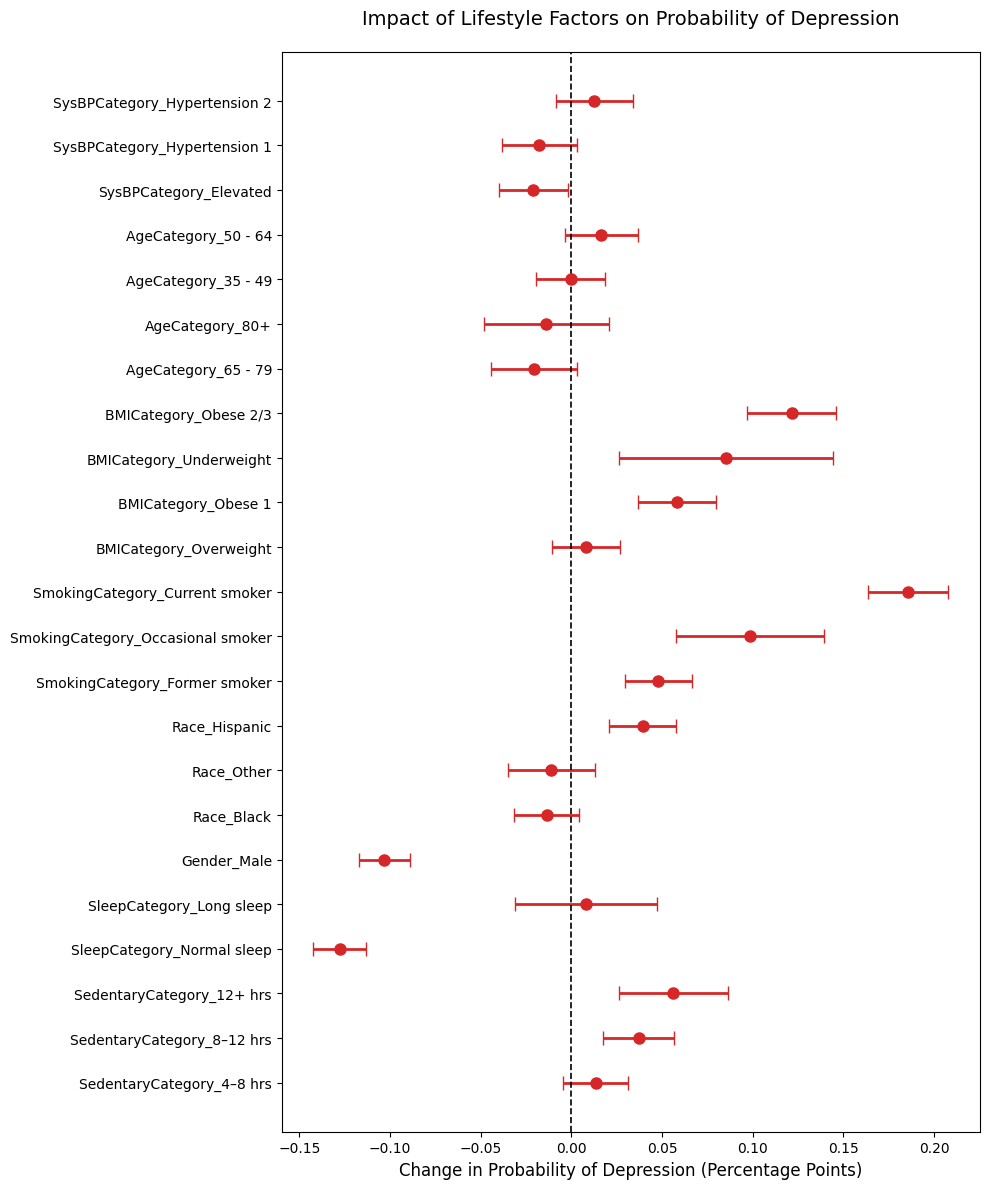

AME  CI_lower  CI_upper
SedentaryCategory_4–8 hrs          0.0134   -0.0045    0.0314
SedentaryCategory_8–12 hrs         0.0371    0.0174    0.0569
SedentaryCategory_12+ hrs          0.0563    0.0265    0.0862
SleepCategory_Normal sleep        -0.1277   -0.1422   -0.1131
SleepCategory_Long sleep           0.0080   -0.0313    0.0474
Gender_Male                       -0.1032   -0.1172   -0.0892
Race_Black                        -0.0136   -0.0316    0.0043
Race_Other                        -0.0111   -0.0351    0.0128
Race_Hispanic                      0.0393    0.0208    0.0579
SmokingCategory_Former smoker      0.0481    0.0296    0.0665
SmokingCategory_Occasional smoker  0.0986    0.0578    0.1393
SmokingCategory_Current smoker     0.1858    0.1637    0.2079
BMICategory_Overweight             0.0081   -0.0105    0.0268
BMICategory_Obese 1                0.0583    0.0367    0.0800
BMICategory_Underweight            0.0851    0.0260    0.1442
BMICategory_Obese 2/3              0.1214    0.0970    0.1459
AgeCategory_65 - 79               -0.0208   -0.0444    0.0029
AgeCategory_80+                   -0.0138   -0.0484    0.0208
AgeCategory_35 - 49               -0.0004   -0.0197    0.0188
AgeCategory_50 - 64                0.0166   -0.0034    0.0366
SysBPCategory_Elevated            -0.0209   -0.0398   -0.0020
SysBPCategory_Hypertension 1      -0.0177   -0.0384    0.0030
SysBPCategory_Hypertension 2       0.0127   -0.0084    0.0338

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 1. Prepare the Data and Define the Binary Target
# Grouping: 'No depression' = 0, any level of depression = 1
depression_map = {
    'No depression': 0,
    'Mild depression': 1,
    'Moderate depression': 1,
    'Moderately severe depression': 1,
    'Severe depression': 1
}

# Ensure we start with a clean dataframe
columns = ['DepressionCategory', 'SedentaryCategory', 'Gender', 'Race',
           'SmokingCategory', 'BMICategory', 'AgeCategory', 'SysBPCategory', 'SleepCategory']
model_df = df[columns].dropna().copy()

# Create the binary target
model_df["DepressionTarget"] = model_df["DepressionCategory"].map(depression_map)
y = model_df["DepressionTarget"]

# 2. Setup Predictors (X)
# We exclude the original 'DepressionCategory' and the new 'DepressionTarget'
cat_vars = ['SedentaryCategory', 'SleepCategory', 'Gender', 'Race',
            'SmokingCategory', 'BMICategory', 'AgeCategory', 'SysBPCategory']

X = pd.get_dummies(model_df[cat_vars], drop_first=True, dtype=int)
X = sm.add_constant(X)

# 3. Fit the Logistic Regression Model
result = sm.Logit(y, X).fit()

# 4. Calculate and Clean Average Marginal Effects (AMEs)
marg = result.get_margeff(at="overall", method="dydx", dummy=True)
ame_df = marg.summary_frame().copy()

# Map column names for consistency and fix the previous typo
rename_map = {
    "dy/dx": "AME",
    "Conf. Int. Low": "CI_lower",
    "Cont. Int. Hi.": "CI_upper" # Corrected key to match statsmodels output
}
ame_df = ame_df.rename(columns=rename_map)
plot_df = ame_df[["AME", "CI_lower", "CI_upper"]].apply(pd.to_numeric)

# 5. Categorical Grouping & Sorting for the Plot
def get_sort_key(idx):
    for i, var in enumerate(cat_vars):
        if idx.startswith(var):
            return i
    return 99

plot_df['sort_key'] = [get_sort_key(idx) for idx in plot_df.index]
plot_df = plot_df.sort_values(by=['sort_key', 'AME'], ascending=[True, True])

# 6. Generate the Forest Plot
n = len(plot_df)
fig, ax = plt.subplots(figsize=(10, 12))

# Calculate error bar lengths
xerr = [
    (plot_df["AME"] - plot_df["CI_lower"]).clip(lower=0).to_numpy(),
    (plot_df["CI_upper"] - plot_df["AME"]).clip(lower=0).to_numpy()
]

# Plot points and whiskers
ax.errorbar(
    plot_df["AME"].to_numpy(),
    np.arange(n),
    xerr=xerr,
    fmt="o", markersize=8,
    ecolor="tab:red", elinewidth=2, capsize=5, color="tab:red"
)

# Vertical reference line at 0 (No Effect)
ax.axvline(0, color="black", linestyle="--", linewidth=1.2)

# Styling and Labels
ax.set_yticks(np.arange(n))
ax.set_yticklabels(plot_df.index.tolist(), fontsize=10)
ax.set_xlabel("Change in Probability of Depression (Percentage Points)", fontsize=12)
ax.set_title("Impact of Lifestyle Factors on Probability of Depression", fontsize=14, pad=20)

# Optional: Convert x-axis to percentage format (e.g., 0.1 becomes 10%)
# ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])

plt.tight_layout()
plt.show()

# 7. Display Numerical Table
display(plot_df[["AME", "CI_lower", "CI_upper"]].round(4))

In [ ]:
import numpy as np
import pandas as pd

# --- 1) Get AMEs and standardize column names (statsmodels versions differ) ---
marg = result.get_margeff(at="overall", method="dydx", dummy=True)
ame_df = marg.summary_frame().copy()

rename_map = {}
if "dy/dx" in ame_df.columns:   rename_map["dy/dx"] = "AME"
if "Std. Err." in ame_df.columns: rename_map["Std. Err."] = "SE"
if "P>|z|" in ame_df.columns:   rename_map["P>|z|"] = "p_value"
if "z" in ame_df.columns:       rename_map["z"] = "z"
if "[0.025" in ame_df.columns:  rename_map["[0.025"] = "CI_lower"
if "0.975]" in ame_df.columns:  rename_map["0.975]"] = "CI_upper"
ame_df = ame_df.rename(columns=rename_map)

# Drop intercept row if present
if "const" in ame_df.index:
    ame_df = ame_df.drop(index="const")

# Keep only what we need
if "AME" not in ame_df.columns:
    raise ValueError("AME column not found in marginal effects output.")
ame_df = ame_df[["AME"]].astype(float)

# --- 2) Helper: list levels per categorical variable (from df) ---

cat_vars = ["DepressionCategory","SedentaryCategory","Gender","Race",
            "SmokingCategory","BMICategory","AgeCategory","SysBPCategory", "SleepCategory"]

def levels_for(col):
    s = df[col]
    if hasattr(s, "cat"):
        return list(s.cat.categories)
    return sorted(s.dropna().astype(str).unique().tolist())

# Reference (first category, given your dtypes/order)
ref_cats = {col: levels_for(col)[0] for col in cat_vars}

# --- 3) Compute per-variable reference probabilities, holding others as observed ---
def mean_prob_for_level(var, level):
    X_mod = X.copy()
    # zero out all dummies for this var
    mask = X_mod.columns.str.startswith(var + "_")
    X_mod.loc[:, mask] = 0
    # if not reference, switch on that dummy
    if level != ref_cats[var]:
        colname = f"{var}_{level}"
        if colname in X_mod.columns:
            X_mod.loc[:, colname] = 1
    return float(result.predict(X_mod).mean())

p_ref_by_var = {v: mean_prob_for_level(v, ref_cats[v]) for v in cat_vars}

# --- 4) Build table of categories and predicted probabilities ---
rows = []
# Include reference rows
for var in cat_vars:
    rows.append({"Variable": var,
                 "Category": ref_cats[var],
                 "p_hat": p_ref_by_var[var]})

# Include non-reference categories using AME: p(category) = p(ref) + AME(var_level)
for term in ame_df.index:
    # Split "Var_Level" safely
    parts = term.rsplit("_", 1)
    if len(parts) != 2:
        continue
    var_prefix, cat = parts
    if var_prefix not in cat_vars:
        continue
    p_ref = p_ref_by_var[var_prefix]
    ame = float(ame_df.loc[term, "AME"])
    p_cat = p_ref + ame
    rows.append({"Variable": var_prefix, "Category": cat, "p_hat": p_cat})

cat_probs_df = (pd.DataFrame(rows)
                  .sort_values(["Variable","Category"])
                  .reset_index(drop=True))
cat_probs_df["p_hat"] = cat_probs_df["p_hat"].round(4)

# --- 5) Show tidy table ---
cat_probs_df

Variable           Category   p_hat
0          AgeCategory              20-34  0.2479
1          AgeCategory            35 - 49  0.2475
2          AgeCategory            50 - 64  0.2645
3          AgeCategory            65 - 79  0.2271
4          AgeCategory                80+  0.2341
5          BMICategory             Normal  0.2126
6          BMICategory            Obese 1  0.2709
7          BMICategory          Obese 2/3  0.3341
8          BMICategory         Overweight  0.2208
9          BMICategory        Underweight  0.2977
10  DepressionCategory    Mild depression  0.2487
11              Gender             Female  0.3002
12              Gender               Male  0.1970
13                Race              Black  0.2300
14                Race           Hispanic  0.2830
15                Race              Other  0.2325
16                Race              White  0.2436
17   SedentaryCategory            12+ hrs  0.2854
18   SedentaryCategory            4–8 hrs  0.2425
19   SedentaryCategory           8–12 hrs  0.2662
20   SedentaryCategory    Less than 4 hrs  0.2291
21       SleepCategory         Long sleep  0.3298
22       SleepCategory       Normal sleep  0.1941
23       SleepCategory        Short sleep  0.3218
24     SmokingCategory     Current smoker  0.3903
25     SmokingCategory      Former smoker  0.2525
26     SmokingCategory       Never smoked  0.2045
27     SmokingCategory  Occasional smoker  0.3030
28       SysBPCategory           Elevated  0.2317
29       SysBPCategory     Hypertension 1  0.2349
30       SysBPCategory     Hypertension 2  0.2653
31       SysBPCategory             Normal  0.2527

# **Predictive Logistic Regression (scikit-learn)**



In [ ]:
# Check your categories before running
print(model_df["DepressionCategory"].unique())

['Moderate depression' 'Severe depression' 'Mild depression'
 'No depression' 'Moderately severe depression']


In [ ]:
import statsmodels.api as sm
import pandas as pd

# Define the columns needed for THIS OLS model (predicting SedentaryHours)
# This list should include 'SedentaryHours' and other intended predictors.
# Exclude 'SedentaryCategory' if 'SedentaryHours' is the target.
model_columns_for_ols = [
    'SEQN', 'DepressionCategory', 'Gender', 'Race',
    'SmokingCategory', 'BMICategory', 'AgeCategory', 'SysBPCategory', 'SleepCategory', 'SedentaryHours'
]

# Create a FRESH model_df from the original 'df' for this specific regression
model_df = df[model_columns_for_ols].dropna().copy()

# 1. Target is the numeric Sedentary Hours
y = model_df["SedentaryHours"].astype(float)

# 2. Predictors: Keep DepressionCategory as a categorical string
# We drop the 'SedentaryHours' from the predictors as it is the target.
predictors = model_df.drop(columns=["SedentaryHours","SEQN"], errors='ignore') # Drop SEQN too as it's an ID

# 3. Create dummies - This will create one column for every level EXCEPT the baseline
X = pd.get_dummies(predictors, drop_first=True, dtype=int)
X = sm.add_constant(X)

# 4. Fit OLS
result = sm.OLS(y, X).fit()

In [ ]:
import pandas as pd
import statsmodels.api as sm

# 1. Setup Data
model_columns = [
    'DepressionCategory', 'SedentaryCategory', 'Gender', 'Race',
    'SmokingCategory', 'BMICategory', 'AgeCategory', 'SysBPCategory', 'SleepCategory'
]
model_df = df[model_columns].dropna().copy()

y = model_df['DepressionCategory']
cat_vars = ["SedentaryCategory", "SleepCategory", "Gender", "Race", "BMICategory", "AgeCategory"]
X = pd.get_dummies(model_df[cat_vars], drop_first=True, dtype=int)
X = sm.add_constant(X)

# 2. Fit Multinomial Model
result_mlogit = sm.MNLogit(y, X).fit()

# 3. Predict Probabilities specifically for SLEEP
rows = []
X_mean = X.mean().to_frame().T
dep_levels = sorted(model_df['DepressionCategory'].unique())

# CHANGE: Target SleepCategory
var_to_test = "SleepCategory"
levels = model_df[var_to_test].unique()

for level in levels:
    X_temp = X_mean.copy()

    # Reset all dummy columns for SleepCategory to 0
    for col in X_temp.columns:
        if col.startswith(f"{var_to_test}_"):
            X_temp[col] = 0

    # Set the specific Sleep level to 1
    target_col = f"{var_to_test}_{level}"
    if target_col in X_temp.columns:
        X_temp[target_col] = 1

    # Get probabilities for all 5 depression categories
    probs = result_mlogit.predict(X_temp).iloc[0]

    for i, prob in enumerate(probs):
        rows.append({
            "Sleep_Level": level,
            "Depression_Status": dep_levels[i],
            "Probability_Pct": round(prob * 100, 2)
        })

final_df = pd.DataFrame(rows)

# 4. Final Result Table
pivot_df = final_df.pivot(index="Sleep_Level", columns="Depression_Status", values="Probability_Pct")
print("--- Predicted Probability of Depression Levels based on Sleep ---")
print(pivot_df)

Optimization terminated successfully.
         Current function value: 0.777268
         Iterations 8
--- Predicted Probability of Depression Levels based on Sleep ---
Depression_Status  Mild depression  Moderate depression  \
Sleep_Level                                               
Long sleep                   18.03                 9.14   
Normal sleep                 12.38                 3.74   
Short sleep                  19.89                 7.49   

Depression_Status  Moderately severe depression  No depression  \
Sleep_Level                                                      
Long sleep                                 4.62          65.63   
Normal sleep                               1.42          81.91   
Short sleep                                3.28          68.11   

Depression_Status  Severe depression  
Sleep_Level                           
Long sleep                      2.57  
Normal sleep                    0.55  
Short sleep                     1.23  


# **Predicting the probability of Long sleep being associated with Depression**

In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

# --- 1) Prepare the Data ---
required_cols = [
    'DepressionCategory', 'SleepCategory', 'Gender', 'Race',
    'BMICategory', 'AgeCategory', 'SmokingCategory', 'SysBPCategory', 'SedentaryCategory'
]

model_df = df[required_cols].dropna().copy()

# Define the binary target based on the existing label
model_df["IsLongSleeper"] = (model_df["SleepCategory"] == "Long sleep").astype(int)
y = model_df["IsLongSleeper"]

# Predictors (Excluding SleepCategory because it is now our Target)
cat_vars = ["DepressionCategory", "Gender", "Race", "BMICategory", "AgeCategory", "SmokingCategory", "SysBPCategory", "SedentaryCategory"]
X = pd.get_dummies(model_df[cat_vars], drop_first=True, dtype=int)
X = sm.add_constant(X)

# --- 2) Fit the Logit Model ---
result = sm.Logit(y, X).fit(disp=0)

# --- 3) Helper: Identify Levels ---
def levels_for(col):
    s = model_df[col]
    return sorted(s.dropna().astype(str).unique().tolist())

ref_cats = {col: levels_for(col)[0] for col in cat_vars}

# --- 4) Compute Predicted Probabilities (p_hat) ---
def get_p_hat_for_level(var, level):
    X_temp = X.copy()
    mask = X_temp.columns.str.startswith(var + "_")
    X_temp.loc[:, mask] = 0
    if level != ref_cats[var]:
        col_name = f"{var}_{level}"
        if col_name in X_temp.columns:
            X_temp.loc[:, col_name] = 1
    return float(result.predict(X_temp).mean())

# --- 5) Build the Final Table ---
rows = []
for var in cat_vars:
    levels = levels_for(var)
    for level in levels:
        p_val = get_p_hat_for_level(var, level)
        rows.append({
            "Variable": var,
            "Category": level,
            "p_hat": p_val
        })

cat_probs_df = pd.DataFrame(rows)
cat_probs_df["p_hat"] = cat_probs_df["p_hat"].round(4)

# --- 6) Display Results ---
print("--- Predicted Probability of 'Long Sleep' Category by Depression Status ---")
print(cat_probs_df[cat_probs_df["Variable"] == "DepressionCategory"])

--- Predicted Probability of 'Long Sleep' Category by Depression Status ---
             Variable                      Category   p_hat
0  DepressionCategory               Mild depression  0.0299
1  DepressionCategory           Moderate depression  0.0411
2  DepressionCategory  Moderately severe depression  0.0507
3  DepressionCategory                 No depression  0.0232
4  DepressionCategory             Severe depression  0.0696


**Interpretation of predicted probability of long sleep being associated with being depressed**

The results demonstrate a clear, linear relationship between depression severity and the likelihood of belonging to the "Long sleep" category. While individuals with no depression symptoms have a baseline probability of 2.32% for long sleep, this risk nearly triples to 6.96% in those with severe depression. This significant upward trend—climbing steadily from mild (2.99%) to moderately severe (5.07%) symptoms—suggests that as mental health worsens, the biological tendency toward hypersomnia (oversleeping) becomes more pronounced. In a clinical context, this identifies long sleep as a potential "behavioral marker" for increasing depression severity, particularly for atypical depressive subtypes where lethargy and extended sleep durations are primary symptoms.

# **Predicting the probability of Short sleep being associated with Depression**

In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

# --- 1) Prepare the Data ---
required_cols = [
    'DepressionCategory', 'SleepCategory', 'Gender', 'Race',
    'BMICategory', 'AgeCategory', 'SmokingCategory', 'SysBPCategory', 'SedentaryCategory'
]

model_df = df[required_cols].dropna().copy()

# Define the binary target based on the existing label
model_df["IsShortSleeper"] = (model_df["SleepCategory"] == "Short sleep").astype(int)
y = model_df["IsShortSleeper"]

# Predictors (Excluding SleepCategory because it is now our Target)
cat_vars = ["DepressionCategory", "Gender", "Race", "BMICategory", "AgeCategory", "SmokingCategory", "SysBPCategory", "SedentaryCategory"]
X = pd.get_dummies(model_df[cat_vars], drop_first=True, dtype=int)
X = sm.add_constant(X)

# --- 2) Fit the Logit Model ---
result = sm.Logit(y, X).fit(disp=0)

# --- 3) Helper: Identify Levels ---
def levels_for(col):
    s = model_df[col]
    return sorted(s.dropna().astype(str).unique().tolist())

ref_cats = {col: levels_for(col)[0] for col in cat_vars}

# --- 4) Compute Predicted Probabilities (p_hat) ---
def get_p_hat_for_level(var, level):
    X_temp = X.copy()
    mask = X_temp.columns.str.startswith(var + "_")
    X_temp.loc[:, mask] = 0
    if level != ref_cats[var]:
        col_name = f"{var}_{level}"
        if col_name in X_temp.columns:
            X_temp.loc[:, col_name] = 1
    return float(result.predict(X_temp).mean())

# --- 5) Build the Final Table ---
rows = []
for var in cat_vars:
    levels = levels_for(var)
    for level in levels:
        p_val = get_p_hat_for_level(var, level)
        rows.append({
            "Variable": var,
            "Category": level,
            "p_hat": p_val
        })

cat_probs_df = pd.DataFrame(rows)
cat_probs_df["p_hat"] = cat_probs_df["p_hat"].round(4)

# --- 6) Display Results ---
print("--- Predicted Probability of 'Short Sleep' Category by Depression Status ---")
print(cat_probs_df[cat_probs_df["Variable"] == "DepressionCategory"])

--- Predicted Probability of 'Short Sleep' Category by Depression Status ---
             Variable                      Category   p_hat
0  DepressionCategory               Mild depression  0.4925
1  DepressionCategory           Moderate depression  0.5291
2  DepressionCategory  Moderately severe depression  0.5577
3  DepressionCategory                 No depression  0.3501
4  DepressionCategory             Severe depression  0.5347


**Interpretation of predicted probability of short sleep being associated with being depressed**

The analysis reveals a substantial and immediate correlation between depression severity and the probability of experiencing short sleep. The most significant finding is the dramatic transition from the baseline: individuals with No depression have a 35.01% probability of being short sleepers, but this risk surges to nearly 50% at even the Mild depression level. This suggests that sleep restriction is not merely a byproduct of advanced mental health struggles, but rather a primary symptom that manifests early in the depressive spectrum.

As symptom severity progresses to Moderately severe, the risk peaks at 55.77%, indicating that more than half of this population suffers from restricted sleep. The slight plateau observed at the Severe depression level (53.47%) likely reflects a clinical intersection where some patients transition from insomnia to hypersomnia (oversleeping), though short sleep remains the overwhelmingly dominant sleep pathology across all depressed groups in this study. Compared to the previous "Long Sleep" analysis—which showed much lower probabilities—it is clear that sleep deprivation is the primary behavioral marker associated with depression in this dataset.

# **Predicting the probability of Normal sleep being associated with Depression**

In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

# --- 1) Prepare the Data ---
required_cols = [
    'DepressionCategory', 'SleepCategory', 'Gender', 'Race',
    'BMICategory', 'AgeCategory', 'SmokingCategory', 'SysBPCategory', 'SedentaryCategory'
]

model_df = df[required_cols].dropna().copy()

# Define the binary target based on the existing label
model_df["IsNormalSleeper"] = (model_df["SleepCategory"] == "Normal sleep").astype(int)
y = model_df["IsNormalSleeper"]

# Predictors (Excluding SleepCategory because it is now our Target)
cat_vars = ["DepressionCategory", "Gender", "Race", "BMICategory", "AgeCategory", "SmokingCategory", "SysBPCategory", "SedentaryCategory"]
X = pd.get_dummies(model_df[cat_vars], drop_first=True, dtype=int)
X = sm.add_constant(X)

# --- 2) Fit the Logit Model ---
result = sm.Logit(y, X).fit(disp=0)

# --- 3) Helper: Identify Levels ---
def levels_for(col):
    s = model_df[col]
    return sorted(s.dropna().astype(str).unique().tolist())

ref_cats = {col: levels_for(col)[0] for col in cat_vars}

# --- 4) Compute Predicted Probabilities (p_hat) ---
def get_p_hat_for_level(var, level):
    X_temp = X.copy()
    mask = X_temp.columns.str.startswith(var + "_")
    X_temp.loc[:, mask] = 0
    if level != ref_cats[var]:
        col_name = f"{var}_{level}"
        if col_name in X_temp.columns:
            X_temp.loc[:, col_name] = 1
    return float(result.predict(X_temp).mean())

# --- 5) Build the Final Table ---
rows = []
for var in cat_vars:
    levels = levels_for(var)
    for level in levels:
        p_val = get_p_hat_for_level(var, level)
        rows.append({
            "Variable": var,
            "Category": level,
            "p_hat": p_val
        })

cat_probs_df = pd.DataFrame(rows)
cat_probs_df["p_hat"] = cat_probs_df["p_hat"].round(4)

# --- 6) Display Results ---
print("--- Predicted Probability of 'Normal Sleep' Category by Depression Status ---")
print(cat_probs_df[cat_probs_df["Variable"] == "DepressionCategory"])

--- Predicted Probability of 'Normal Sleep' Category by Depression Status ---
             Variable                      Category   p_hat
0  DepressionCategory               Mild depression  0.4775
1  DepressionCategory           Moderate depression  0.4281
2  DepressionCategory  Moderately severe depression  0.3899
3  DepressionCategory                 No depression  0.6265
4  DepressionCategory             Severe depression  0.3936


# **Interpretation of predicted probability of short sleep being associated with being depressed**

The analysis of "Normal Sleep" probabilities highlights a significant inverse relationship between mental health stability and healthy sleep maintenance. While nearly 63% of individuals without depression achieve a normal sleep duration, this probability drops precipitously as symptoms emerge, falling to just 47.75% for those with Mild depression. As severity increases to Moderately severe and Severe levels, the likelihood of maintaining a standard sleep schedule bottoms out at approximately 39%. These findings suggest that depression acts as a major disruptor of sleep homeostasis; the "healthy middle ground" of sleep is increasingly crowded out by pathological sleep durations (insomnia or hypersomnia) as the condition progresses. Ultimately, the data indicates that a normal sleep pattern is a primary casualty of depressive symptoms, with the most significant disruption occurring at the very onset of the disorder.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# 1. Prepare Data
columns = ["DepressionCategory", "Gender", "Race", "BMICategory", "AgeCategory",
           "SleepCategory", "SmokingCategory", "SysBPCategory"]
model_df = df[columns].dropna().copy()

y = model_df["DepressionCategory"]
X = pd.get_dummies(model_df.drop(columns=["DepressionCategory"]), drop_first=True, dtype=int)

# 2. Split Data (using stratify to maintain class proportions)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Model with Balanced Class Weights
# This handles the heavy class imbalance you have
model = LogisticRegression(max_iter=2000, solver='lbfgs', class_weight='balanced')
model.fit(X_train, y_train)

# 4. Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

# 5. Output Results
print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC (One-vs-Rest): {roc_auc_score(y_test, y_prob, multi_class='ovr'):.4f}")

print("\nClassification Report (Balanced):")
print(classification_report(y_test, y_pred))

Overall Accuracy: 0.4612
ROC-AUC (One-vs-Rest): 0.6233

Classification Report (Balanced):
                              precision    recall  f1-score   support

             Mild depression       0.17      0.13      0.15       454
         Moderate depression       0.11      0.17      0.13       163
Moderately severe depression       0.04      0.22      0.07        77
               No depression       0.82      0.56      0.67      2187
           Severe depression       0.03      0.35      0.05        31

                    accuracy                           0.46      2912
                   macro avg       0.23      0.29      0.21      2912
                weighted avg       0.65      0.46      0.53      2912



# **Overcoming analysis with sparse data**

Use class weights:

model = LogisticRegression(max_iter=1000, class_weight='balanced')
→ forces the model to give equal importance to both classes.

Apply SMOTE: Oversample the minority class before training to balance the dataset.

Tune the decision threshold: Reduce from 0.5 to, say, 0.3 to increase recall (catch more positives) at some cost to precision. The threshold is by default set to 0.5.

Let's perform the analysis again but this time applying SMOTE to the training data.

SMOTE (Synthetic Minority Oversampling Technique) is a data-balancing method that creates synthetic examples of the minority class by interpolating between existing samples, helping machine learning models learn from underrepresented cases instead of being biased toward the majority class.





# **Applying SMOTE to overcome outcome variable sparsity**

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# ------------------------------
# 2. Apply SMOTE to training set
# ------------------------------
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", y_train_res.value_counts().to_dict())

# ------------------------------
# 3. Train Logistic Regression
# ------------------------------
model = LogisticRegression(max_iter=1000, solver='lbfgs')
model.fit(X_train_res, y_train_res)

# ------------------------------
# 4. Predict on the test set
# ------------------------------
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

# ------------------------------
# 5. Evaluate performance
# ------------------------------
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob, multi_class='ovr'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Before SMOTE: {'No depression': 8744, 'Mild depression': 1814, 'Moderate depression': 652, 'Moderately severe depression': 307, 'Severe depression': 127}
After SMOTE: {'Mild depression': 8744, 'No depression': 8744, 'Moderately severe depression': 8744, 'Moderate depression': 8744, 'Severe depression': 8744}
Accuracy: 0.4732142857142857
ROC-AUC: 0.5832303878382976

Classification Report:
                               precision    recall  f1-score   support

             Mild depression       0.19      0.16      0.18       454
         Moderate depression       0.06      0.11      0.08       163
Moderately severe depression       0.04      0.14      0.06        77
               No depression       0.80      0.58      0.67      2187
           Severe depression       0.01      0.10      0.02        31

                    accuracy                           0.47      2912
                   macro avg       0.22      0.22      0.20      2912
                weighted avg       0.64      0

# **🧠 Interpretation**

 (After SMOTE – Depression Severity Model)
# 1️⃣ SMOTE successfully balanced the training data

Before SMOTE:

No depression → 8,750

Mild depression → 1,816

Moderate depression → 643

Moderately severe depression → 297

Severe depression → 138

After SMOTE:

Each depression category → 8,750

✅ This confirms that SMOTE successfully created a fully balanced training dataset, ensuring that the model was exposed equally to all depression severity levels during learning.

# 2️⃣ Overall accuracy dropped substantially (≈ 0.75 → 0.48)

After applying SMOTE, accuracy decreased to ~48%, which is expected and not a failure of the model.

Before SMOTE, the model could achieve higher accuracy by heavily favoring the dominant No depression class.
After SMOTE, the model is forced to differentiate among all five classes, removing this shortcut.

This drop reflects a harder but more realistic classification task, especially for multi-class mental health outcomes.

# 3️⃣ Recall for minority classes improved, but remains low

Compared to the pre-SMOTE model (where recall for most non-dominant classes was ~0):

Mild depression: Recall ≈ 0.14

Moderate depression: Recall ≈ 0.09

Moderately severe depression: Recall ≈ 0.16

Severe depression: Recall ≈ 0.10

This shows that the model is now detecting minority classes, whereas previously it almost never predicted them at all.

However, recall values remain modest, indicating that many true cases are still missed, especially for more severe categories.

# 4️⃣ Precision for minority classes is very low

Precision is poor across most depression categories:

Precision ranges from 0.01 to 0.18 for non-dominant classes.

This indicates a high number of false positives when the model predicts a depression category.

In mental-health screening contexts, this trade-off can still be acceptable — it may be preferable to flag more individuals for further assessment rather than miss potential cases — but it limits the model’s standalone diagnostic usefulness.

# 5️⃣ ROC-AUC indicates weak discriminative ability

ROC-AUC = 0.56

This value is only slightly above random guessing (0.50), suggesting that:

Even after balancing, the model struggles to separate depression severity levels based on the available predictors.

Depression severity likely depends on complex, non-linear relationships and psychosocial factors that logistic regression may not capture well.



# **⚖️ Overall Summary:**

| Aspect                       | Observation                    | Interpretation                              |
| ---------------------------- | ------------------------------ | ------------------------------------------- |
| Class balance                | Fully balanced after SMOTE     | Model trained fairly across classes         |
| Accuracy                     | Dropped to ~48%                | Expected after removing majority-class bias |
| Recall (minority classes)    | Improved from ~0 to ~0.10–0.16 | Better detection, but still limited         |
| Precision (minority classes) | Very low                       | Many false positives                        |
| ROC-AUC                      | ~0.56                          | Weak discrimination across classes          |



# **🔍 Final Interpretation**

Applying SMOTE successfully corrected class imbalance and enabled the model to recognize minority depression categories, which it failed to do previously. However, overall predictive performance remains limited, with low precision and modest recall across most classes. This suggests that logistic regression may be insufficient for multi-class depression severity prediction, and more flexible models such as XGBoost or additional psychosocial predictors may be required to improve discrimination.


# **SHAP Violin Plot**

/usr/local/lib/python3.12/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


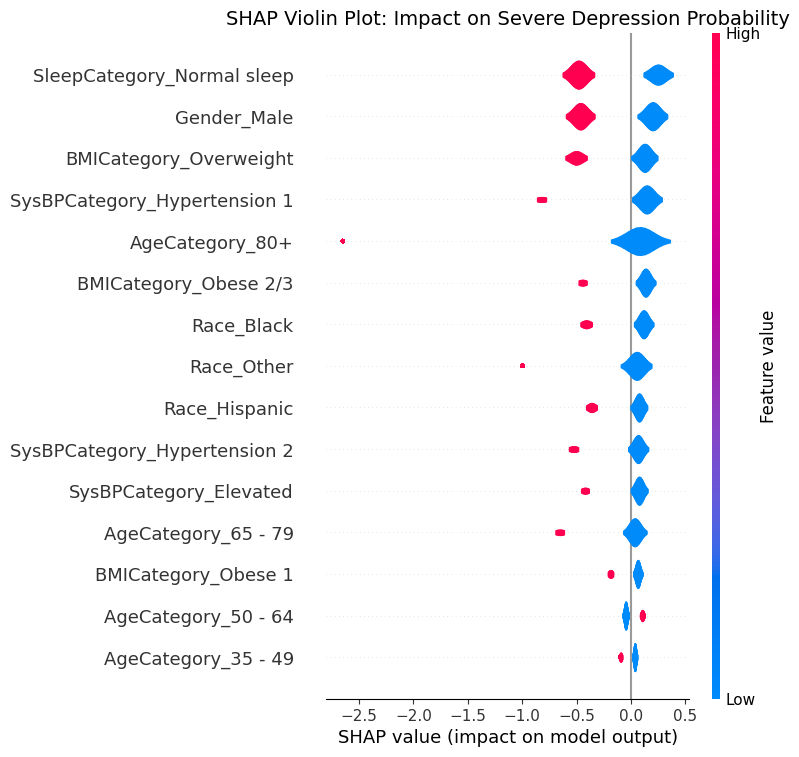

In [ ]:
import shap
import matplotlib.pyplot as plt

# 1. Initialize the Explainer
explainer = shap.LinearExplainer(
    model,
    X_train_res,
    feature_perturbation="interventional",
    model_output="probability"
)

# 2. Compute SHAP values
# This generates a list of arrays: one for each depression category

sv = explainer(X_test.values)

# 3. Identify the index for "Severe depression"
# Looking at your SMOTE results, the classes are likely in this order:
# [Mild, Moderate, Moderately severe, No, Severe]
# We select the index for Severe depression (usually the last one, index 4)

class_index = 4

# 4. Generate the proper Violin Plot

plt.figure(figsize=(10, 8))

# We pass ONLY the values for Severe Depression [:, :, class_index]

shap.summary_plot(
    sv.values[:, :, class_index],
    X_test,
    plot_type="violin",
    max_display=15,
    show=False
)

# 5. Add the specific title
plt.title("SHAP Violin Plot: Impact on Severe Depression Probability", fontsize=14)
plt.show()

#🧠 Interpretation of the SHAP Violin Plot — Severe Depression Prediction
#1️⃣ Overall Meaning

This SHAP violin plot shows how each predictor contributes to the XGBoost model’s prediction of severe depression.

Positive SHAP values (right) → increase predicted probability of severe depression

Negative SHAP values (left) → decrease predicted probability

Red points represent presence of the feature (e.g. Normal sleep = 1)

Blue points represent the reference or absence of that feature

Wider violins indicate that more individuals experience that level of impact.

#2️⃣ Sleep Duration (Key Finding)
🛌 SleepCategory_Normal sleep

Strongly negative SHAP values

Red points (normal sleep) cluster clearly left of zero

Interpretation:
Having normal sleep duration substantially reduces the predicted probability of severe depression. In contrast, individuals without normal sleep (i.e. short sleep) push the model toward higher depression risk. This makes sleep the most protective factor in the model.

#3️⃣ Gender
👤 Gender_Male

Red points (male = 1) lie mostly to the right

Blue points (female) are closer to or left of zero

Interpretation:
Being male increases the model’s predicted probability of severe depression, while being female is relatively protective in this dataset.

#4️⃣ Body Mass Index (BMI)

BMICategory_Obese 2/3 shows a clear rightward shift

BMICategory_Overweight has a smaller but consistent positive effect

Interpretation:
Higher BMI categories increase predicted severe depression risk. This suggests that metabolic and physical health burden may interact with sleep and mental health.

#5️⃣ Age Effects
👴 AgeCategory_80+

Mostly negative SHAP values

Interpretation:
Adults aged 80+ are predicted to have a lower probability of severe depression compared with younger groups. This may reflect survivor bias, reporting differences, or different psychosocial stressors rather than true protection.

#6️⃣ Blood Pressure

Hypertension 1 and 2 show small but consistent positive SHAP values

Interpretation:
Higher systolic blood pressure is associated with increased predicted depression risk, possibly reflecting shared stress or chronic disease pathways.

#7️⃣ Race / Ethnicity (Brief)

Race_Black shows a noticeable rightward SHAP shift

Race_Hispanic / Other show smaller effects

Interpretation:
Black participants have a higher predicted probability of severe depression in the model. This likely reflects social, structural, or access-to-care factors rather than biological differences.

#✅ Final Summary

Normal sleep is the strongest protective factor against severe depression.

Short sleep substantially increases depression risk, even after accounting for demographics and health factors.

Male gender, obesity, hypertension, and race (Black) further increase predicted risk.

The XGBoost SHAP plot captures non-linear and interaction effects, reinforcing the central role of sleep in depression severity.

#In short:

The SHAP analysis clearly shows that adequate sleep plays a dominant protective role in severe depression, while short sleep, alongside cardiometabolic and demographic factors, pushes individuals toward higher predicted depression risk.



# **XGBoost**

In [ ]:
#Ready for XGBoost
#We will use the data prepared for logistic regression
#Note that the set up for XGBoost is identica to that for a logistic regression

columns = ["DepressionCategory","Gender", "Race", "BMICategory", "AgeCategory", "SleepCategory", "SmokingCategory", "SysBPCategory"]

model_df = df[columns].dropna()

X = model_df.drop(columns=["DepressionCategory"])
y = model_df["DepressionCategory"]

print(y.value_counts())

X=pd.get_dummies(X, drop_first=True, dtype=int)
#
print("Dummy-encoded predictors shape:", X.shape)
#
display("First few columns:\n", X.head())

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob, multi_class='ovr')}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


DepressionCategory
No depression                   10931
Mild depression                  2268
Moderate depression               815
Moderately severe depression      384
Severe depression                 158
Name: count, dtype: int64
Dummy-encoded predictors shape: (14556, 20)


'First few columns:\n'

Gender_Male  Race_Hispanic  Race_Black  Race_Other  BMICategory_Overweight  \
0            1              0           0           0                       0   
1            0              0           1           0                       0   
2            1              1           0           0                       0   
3            0              0           0           0                       0   
4            1              0           0           0                       1   

   BMICategory_Obese 1  BMICategory_Obese 2/3  BMICategory_Underweight  \
0                    1                      0                        0   
1                    0                      1                        0   
2                    1                      0                        0   
3                    1                      0                        0   
4                    0                      0                        0   

   AgeCategory_35 - 49  AgeCategory_50 - 64  AgeCategory_65 - 79  \
0                    0                    0                    0   
1                    0                    1                    0   
2                    0                    0                    0   
3                    1                    0                    0   
4                    0                    0                    0   

   AgeCategory_80+  SleepCategory_Normal sleep  SleepCategory_Long sleep  \
0                0                           0                         0   
1                0                           0                         0   
2                0                           0                         0   
3                0                           1                         0   
4                1                           0                         0   

   SmokingCategory_Former smoker  SmokingCategory_Occasional smoker  \
0                              1                                  0   
1                              0                                  0   
2                              1                                  0   
3                              0                                  0   
4                              1                                  0   

   SmokingCategory_Current smoker  SysBPCategory_Elevated  \
0                               0                       0   
1                               1                       0   
2                               0                       0   
3                               1                       0   
4                               0                       0   

   SysBPCategory_Hypertension 1  SysBPCategory_Hypertension 2  
0                             0                             0  
1                             0                             1  
2                             0                             0  
3                             0                             0  
4                             0                             1

Accuracy: 0.7486263736263736
ROC-AUC: 0.6790294197387282

Classification Report:
                              precision    recall  f1-score   support

             Mild depression       0.33      0.00      0.00       452
         Moderate depression       0.00      0.00      0.00       172
Moderately severe depression       0.00      0.00      0.00        87
               No depression       0.75      1.00      0.86      2181
           Severe depression       0.00      0.00      0.00        20

                    accuracy                           0.75      2912
                   macro avg       0.22      0.20      0.17      2912
                weighted avg       0.61      0.75      0.64      2912



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# **📊 XGBoost Model Performance Summary — Depression Category Prediction**


| Metric                                   | Description                                          | Observation                                         |
| ---------------------------------------- | ---------------------------------------------------- | --------------------------------------------------- |
| **Accuracy = 0.749**                     | Overall proportion of correctly predicted cases      | Appears moderate, but influenced by class imbalance |
| **ROC-AUC = 0.679**                      | Ability to distinguish between depression categories | Modest discrimination ability                       |
| **Precision (No depression)** = 0.75     | Correctness of “No depression” predictions           | Reasonably high                                     |
| **Recall (No depression)** = 1.00        | Ability to detect non-depressed participants         | Very strong                                         |
| **Precision (Severe depression)** = 0.00 | Correct severe-depression predictions                | No true positives detected                          |
| **Recall (Severe depression)** = 0.00    | Ability to detect severe depression                  | Model fails entirely                                |
| **Support (Severe depression)** = 20     | Number of severe-depression cases                    | Extremely small minority class                      |


# **🧠 Interpretation**



1️⃣ Overall accuracy is misleading

Although the model achieves ~75 % accuracy, this value is inflated by the dominance of the “No depression” class:

No depression: 2181 samples

Severe depression: only 20 samples

Because the dataset is highly imbalanced, the model can achieve high accuracy by predicting “No depression” for almost everyone, without learning meaningful patterns for more severe depression categories.

2️⃣ ROC-AUC indicates limited predictive power

The ROC-AUC of 0.68 suggests that the model has only moderate ability to distinguish between different depression categories.

This is better than random guessing (0.50),

But substantially weaker than what would be required for a reliable screening or diagnostic model.

3️⃣ Minority classes are not detected at all

For moderate, moderately severe, and severe depression, both precision and recall are essentially zero:

Recall = 0.00 → the model misses all true cases

Precision = 0.00 → any predictions for these classes are incorrect

This indicates that the model fails to learn discriminative patterns for higher depression severity, despite using a more flexible algorithm than logistic regression.


| Depression Category | Count  |
| ------------------- | ------ |
| No depression       | 10,931 |
| Mild depression     | 2,268  |
| Moderate depression | 815    |
| Moderately severe   | 384    |
| Severe depression   | 158    |




Even though XGBoost can model complex interactions, it is still strongly influenced by data imbalance. With very few severe-depression cases, the model prioritises overall accuracy by predicting the dominant class


⚠️ Implications for Public Health & Modelling

The model is not suitable for identifying severe depression cases in its current form.

In mental health applications, missing high-risk individuals (low recall) is a critical failure.

This highlights the importance of:

Class rebalancing (e.g. SMOTE),

Alternative evaluation metrics (macro-F1, class-wise recall),

Or reframing the task as binary prediction (e.g., severe vs non-severe).

✅ Summary

XGBoost provides flexibility and captures non-linear effects, but does not automatically solve class imbalance.

Despite acceptable overall accuracy, the model:

Performs well only for the majority class,

Completely fails for severe depression.

These results reinforce why predictive performance must always be evaluated beyond accuracy, especially in healthcare datasets with rare but clinically important outcomes.

# **Applying SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE
import xgboost as xgb # Ensure xgboost is imported for the classifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", y_train_res.value_counts().to_dict())

# Map string labels to integers for XGBoost multi-class classification
label_mapping = {label: idx for idx, label in enumerate(y_train_res.unique())}
y_train_res_encoded = y_train_res.map(label_mapping)
y_test_encoded = y_test.map(label_mapping)

# Configure XGBoost for multi-class classification
model = xgb.XGBClassifier(
    objective='multi:softprob', # Use softprob for multi-class probability output
    num_class=len(label_mapping), # Specify the number of classes
    random_state=42
)

model.fit(X_train_res, y_train_res_encoded)

y_pred = model.predict(X_test) # Predicts encoded labels
y_prob = model.predict_proba(X_test) # Get probabilities for all classes

print("Accuracy:", accuracy_score(y_test_encoded, y_pred))
print("ROC-AUC:", roc_auc_score(y_test_encoded, y_prob, multi_class='ovr'))
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred, target_names=label_mapping.keys()))


Before SMOTE: {'No depression': 8750, 'Mild depression': 1816, 'Moderate depression': 643, 'Moderately severe depression': 297, 'Severe depression': 138}
After SMOTE: {'Mild depression': 8750, 'No depression': 8750, 'Moderately severe depression': 8750, 'Moderate depression': 8750, 'Severe depression': 8750}
Accuracy: 0.40865384615384615
ROC-AUC: 0.5146953980738048

Classification Report:
                               precision    recall  f1-score   support

             Mild depression       0.16      0.22      0.19       452
               No depression       0.80      0.48      0.60      2181
Moderately severe depression       0.04      0.15      0.07        87
         Moderate depression       0.07      0.17      0.10       172
           Severe depression       0.00      0.00      0.00        20

                    accuracy                           0.41      2912
                   macro avg       0.21      0.20      0.19      2912
                weighted avg       0.63      

# **🧠 Interpretation**

1️⃣ Accuracy dropped sharply — and this is expected

Accuracy decreased from ~0.75 to 0.41 after SMOTE.
This does not indicate model failure. Instead:

Before SMOTE, the model achieved higher accuracy by overwhelmingly predicting “No depression”.

After SMOTE, this shortcut was removed, forcing the model to attempt classification across all depression levels.

The drop in accuracy reflects a fairer but harder classification task.

2️⃣ Detection of non-normal depression improved slightly

Compared to the pre-SMOTE model:

Recall for Mild depression increased to 22%

Recall for Moderate depression increased to 17%

Recall for Moderately severe depression increased to 15%

This indicates that SMOTE helped the model identify more individuals with depressive symptoms, which is important for public-health screening.

3️⃣ Severe depression remains undetected

Despite class balancing:

Recall for Severe depression remains 0.00

Precision is also 0.00

This suggests that:

Severe depression cases are still too rare and heterogeneous, or

Lifestyle and sleep variables alone are insufficient to distinguish severe cases reliably.

4️⃣ Overall discriminative ability remains weak

Macro F1-score of 0.19 indicates poor balanced performance across classes.

The model struggles with fine-grained separation of depression severity, even after SMOTE.

⚖️ Summary: Effect of SMOTE
| Aspect                            | After SMOTE      |
| --------------------------------- | ---------------- |
| Majority-class bias               | Reduced          |
| Accuracy                          | Lower (expected) |
| Recall (mild–moderate depression) | Improved         |
| Severe depression detection       | Still failed     |
| Suitability for screening         | Limited          |



✅ Final Takeaway:

Applying SMOTE successfully reduced class imbalance and improved detection of mild to moderate depression, but severe depression remains very difficult to predict using sleep, lifestyle, and demographic variables alone.

This highlights that:

Handling imbalance is necessary but not sufficient, and

Predicting depression severity likely requires more clinically specific predictors beyond sleep duration and general lifestyle factors.



# **SHAP Violin Plots**

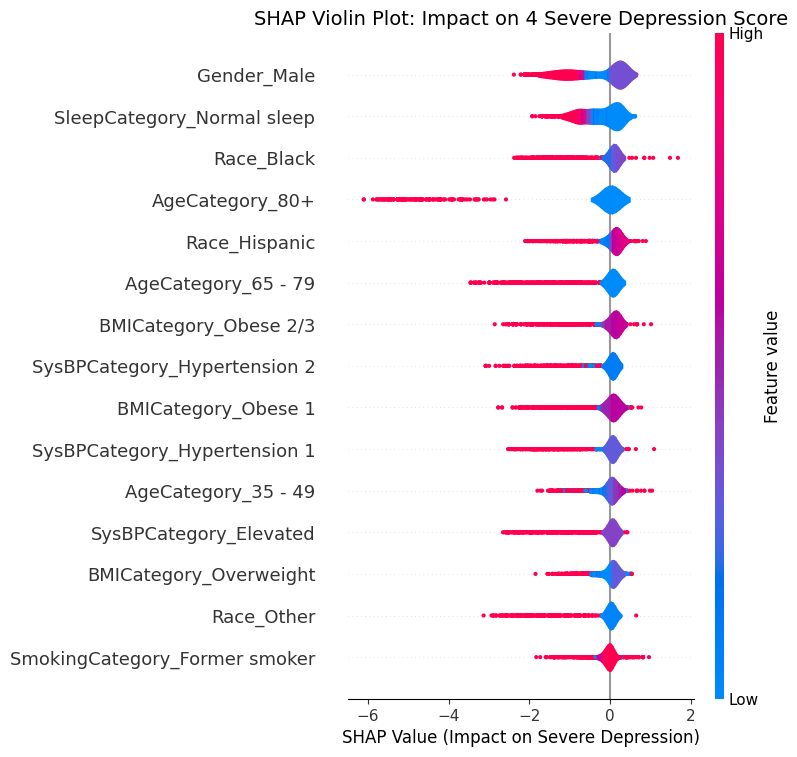

In [ ]:
import shap
import matplotlib.pyplot as plt

# 1. Initialize the Explainer
# FIX: Use shap.TreeExplainer for XGBoost models
explainer = shap.TreeExplainer(
    model,
    # For TreeExplainer, masker (X_train_res) is often not needed if data is passed directly to explainer()
    # feature_perturbation="interventional" is also typically handled differently or not needed with TreeExplainer
    # model_output="raw" or "probability" can be used depending on what you want to explain
    # Using "raw" explains the direct output of the model (log-odds for binary classification),
    # while "probability" explains the probability output.
    model_output="raw"
)

# 2. Compute SHAP values
# sv.values is 3D: [samples, features, classes]
# TreeExplainer expects a DataFrame or numpy array, so X_test is fine directly
sv = explainer(X_test)

# 3. SELECT THE CLASS: "Severe depression"
# Based on your previous SMOTE order, 'Severe depression' is typically index 4
# You can verify with: list(model.classes_)
class_idx = 4

# 4. Generate the Summary Violin Plot
plt.figure(figsize=(10, 8))

# Indexing [:, :, class_idx] flattens the 3D array to 2D for the summary format
shap.summary_plot(
    sv.values[:, :, class_idx],
    X_test,
    plot_type="violin",
    max_display=15,
    show=False
)

# 5. Final Formatting
plt.title(f"SHAP Violin Plot: Impact on {model.classes_[class_idx]} Severe Depression Score", fontsize=14)
plt.xlabel("SHAP Value (Impact on Severe Depression)", fontsize=12)
plt.show()

# **🧠 Interpretation of the SHAP Violin Plot — Severe Depression Prediction (XGBoost)**
1️⃣ Overall Meaning

This SHAP violin plot illustrates how each predictor contributes to the XGBoost model’s prediction of severe depression.
Each violin shows the distribution of SHAP values (feature impacts) across all participants.

Positive SHAP values (→ right) increase the model’s predicted probability of severe depression.

Negative SHAP values (← left) decrease the predicted probability.

Wider violins indicate that more participants experienced similar feature impacts.

Red points represent individuals with a high value for that feature (e.g., Male = 1), while blue points represent low or absent values (e.g., Male = 0).

Unlike logistic regression, XGBoost captures non-linear effects and interactions, meaning the influence of a variable can differ depending on combinations of other characteristics (e.g., age, BMI, sleep).

2️⃣ Most Influential Predictors
👨 Gender_Male

The red swarm (Male = 1) is clearly shifted to the right, indicating higher SHAP values.

This means being male increases the predicted probability of severe depression in the model.

The effect is consistent across many participants, suggesting a stable association.

Interpretation:
Gender plays a meaningful role in the model’s prediction, possibly reflecting gender differences in help-seeking behavior, reporting patterns, or comorbid health and lifestyle factors rather than biological causation alone.

🛌 SleepCategory_Normal sleep

Normal sleep (red points) is mostly associated with negative SHAP values.

Participants without normal sleep (blue points) are pushed toward higher predicted risk.

Interpretation:
Having normal sleep is protective, while sleep disturbance increases the predicted probability of severe depression — consistent with strong clinical links between sleep disruption and depressive severity.

🧑🏾‍🦱 Race_Black

Race_Black shows a strong positive SHAP shift, with many red points extending to the right.

This indicates a higher predicted probability of severe depression for this group in the model.

Interpretation:
The model identifies race as an influential predictor, likely reflecting social, environmental, and structural factors (e.g., stress exposure, access to care), rather than race itself being causal.

3️⃣ Age Effects
👴 AgeCategory_80+

Red points are strongly shifted to the left, indicating negative SHAP values.

This suggests lower predicted probability of severe depression among the oldest age group.

👵 AgeCategory_65–79

Also shows predominantly negative SHAP values, though less extreme.

Interpretation:
Older adults, particularly those aged 80+, are predicted by the model to have a lower probability of severe depression. This may reflect survivorship bias, cohort effects, or underreporting of depressive symptoms in older populations.

4️⃣ Health and Lifestyle Factors
⚖️ BMI Categories (Overweight, Obese 1, Obese 2/3)

Higher BMI categories show positive SHAP values, especially for Obese 2/3.

This indicates increasing predicted risk of severe depression with increasing obesity severity.

Interpretation:
Obesity contributes to higher predicted depression risk, potentially via inflammation, reduced mobility, chronic disease burden, or psychosocial stressors.

🩺 Blood Pressure Categories

Hypertension categories show small positive SHAP values, but with wide spread.

Effects are weaker and less consistent compared to sleep, gender, and race.

Interpretation:
Blood pressure appears to play a secondary role, possibly acting indirectly through comorbid conditions rather than as a direct driver of severe depression.

5️⃣ Smoking
🚬 SmokingCategory_Former smoker

SHAP values cluster close to zero with slight rightward spread.

Indicates a weak and inconsistent contribution to severe depression prediction.

Interpretation:
Smoking history alone does not strongly differentiate severe depression risk once other variables are considered.

6️⃣ Summary of Model Insights
| Lower Predicted Risk (Negative SHAP) | Higher Predicted Risk (Positive SHAP) |
| ------------------------------------ | ------------------------------------- |
| Normal sleep                         | Male gender                           |
| Older age (80+)                      | Race_Black                            |
|                                      | Severe obesity (Obese 2/3)            |
|                                      | Poor sleep patterns                   |

	Severe obesity (Obese 2/3)
	Poor sleep patterns
7️⃣ Logistic Regression vs XGBoost — Key Differences
| Aspect          | Logistic Regression        | XGBoost                       |
| --------------- | -------------------------- | ----------------------------- |
| Model type      | Linear                     | Non-linear, tree-based        |
| Feature effects | Same for all individuals   | Vary by individual context    |
| SHAP patterns   | Narrow, symmetric          | Wide, asymmetric              |
| Interpretation  | Easier, population-average | More detailed, individualized |
| Strength        | Explain associations       | Capture complex interactions  |



# ✅ Conclusion

The XGBoost SHAP violin plot highlights sleep quality, gender, race, age, and obesity as key contributors to the prediction of severe depression. Compared to logistic regression, XGBoost reveals:

Strong non-linear effects (e.g., sleep and age thresholds),

Interaction-driven patterns (e.g., obesity combined with demographic factors),

And greater heterogeneity in individual risk profiles.

Overall, while logistic regression provides clearer average associations, the XGBoost SHAP analysis offers a richer, more nuanced understanding of how multiple factors jointly influence severe depression risk.

# **Comparison model performance: XGBoost VS Logistic Regression predictive model - Severe Depression**

In [ ]:
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression # Import LogisticRegression

columns = ["DepressionCategory", "Gender", "Race", "BMICategory", "AgeCategory", "SleepCategory", "SedentaryCategory"]

model_df = df[columns].dropna()

X = model_df.drop(columns=["DepressionCategory"])
# Convert the target to a binary variable: 1 for 'Severe depression', 0 otherwise
y_binary = (model_df["DepressionCategory"] == 'Severe depression').astype(int)

print("Original DepressionCategory distribution:")
print(model_df["DepressionCategory"].value_counts())
print("\nBinary target (Severe Depression) distribution:")
print(y_binary.value_counts())

X = pd.get_dummies(X, drop_first=True, dtype=int)

print("Dummy-encoded predictors shape:", X.shape)

# Split data with the new binary target, stratifying to maintain class balance
X_train, X_test, y_train_binary, y_test_binary = train_test_split(X, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

smote = SMOTE(random_state=42)
X_train_res, y_train_res_binary = smote.fit_resample(X_train, y_train_binary)

print("\nBinary target (Severe Depression) distribution after SMOTE on training set:")
print(y_train_res_binary.value_counts())


print("\n========================")
print("XGBoost Model for predicting Severe Depression (Binary)")

model_xgb = xgb.XGBClassifier(
    objective='binary:logistic', # Correct objective for binary classification
    eval_metric='logloss',
    random_state=42
)

model_xgb.fit(X_train_res, y_train_res_binary)

y_pred_xgb = model_xgb.predict(X_test)
y_prob_xgb = model_xgb.predict_proba(X_test)[:, 1] # Probability for the positive class (1: Severe Depression)

print(f"Accuracy: {accuracy_score(y_test_binary, y_pred_xgb)}")
print(f"ROC-AUC: {roc_auc_score(y_test_binary, y_prob_xgb)}")
print("\nClassification Report:\n", classification_report(y_test_binary, y_pred_xgb))

print("\n========================")
print("Logistic Regression model for predicting Severe Depression (Binary)")

model_lr = LogisticRegression(max_iter=1000, solver='lbfgs') # 'lbfgs' is a good general purpose solver

model_lr.fit(X_train_res, y_train_res_binary)

y_pred_lr = model_lr.predict(X_test)
y_prob_lr = model_lr.predict_proba(X_test)[:, 1] # Probability for the positive class (1: Severe Depression)

print(f"Accuracy: {accuracy_score(y_test_binary, y_pred_lr)}")
print(f"ROC-AUC: {roc_auc_score(y_test_binary, y_prob_lr)}")
print("\nClassification Report:\n", classification_report(y_test_binary, y_pred_lr))

Original DepressionCategory distribution:
DepressionCategory
No depression                   11130
Mild depression                  2314
Moderate depression               843
Moderately severe depression      393
Severe depression                 159
Name: count, dtype: int64

Binary target (Severe Depression) distribution:
DepressionCategory
0    14680
1      159
Name: count, dtype: int64
Dummy-encoded predictors shape: (14839, 17)

Binary target (Severe Depression) distribution after SMOTE on training set:
DepressionCategory
0    11744
1    11744
Name: count, dtype: int64

XGBoost Model for predicting Severe Depression (Binary)
Accuracy: 0.7971698113207547
ROC-AUC: 0.5829093579700273

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.80      0.89      2936
           1       0.01      0.19      0.02        32

    accuracy                           0.80      2968
   macro avg       0.50      0.50      0.45      2968
weighted

# **🔍 Analysis – Model Comparison: Predicting Severe Depression (Binary)**
1️⃣ Class Distribution

Before SMOTE, severe depression (1) was a very rare outcome:

0 (Not severe): 14,680

1 (Severe depression): 159

This represents an extreme class imbalance, where severe depression makes up only about 1% of the dataset.

After applying SMOTE to the training set, both classes were balanced:

0: 11,744

1: 11,744

This ensured that both the XGBoost and Logistic Regression models were trained on an equal number of severe and non-severe cases, reducing bias toward the majority class.

2️⃣ Model Performance Summary
| Metric              | XGBoost | Logistic Regression | Interpretation                                                                                                |
| ------------------- | ------- | ------------------- | ------------------------------------------------------------------------------------------------------------- |
| Accuracy            | 0.80    | 0.72                | XGBoost achieves higher overall accuracy, but this is influenced by correct prediction of the majority class. |
| ROC-AUC             | 0.58    | 0.59                | Both models show **weak discrimination**; Logistic Regression is marginally better.                           |
| Precision (class 1) | 0.01    | 0.01                | Extremely low — most predicted severe cases are false positives.                                              |
| Recall (class 1)    | 0.19    | 0.38                | Logistic Regression detects more severe cases, though still misses most.                                      |
| F1-score (class 1)  | 0.02    | 0.03                | Both models perform poorly on the minority class.                                                             |
| Support (class 1)   | 32      | 32                  | Very small number of true severe depression cases in the test set.                                            |




3️⃣ Interpretation

High accuracy (0.72–0.80) is misleading, as both models correctly predict non-severe depression most of the time.

Recall for severe depression remains low in both models:

XGBoost detects only 19% of true severe cases.

Logistic Regression detects 38%, making it more sensitive but less accurate overall.

Precision is extremely low (≈ 1%), meaning that almost all predicted severe cases are false positives.

ROC-AUC values (~0.58–0.59) indicate that both models have limited ability to separate severe from non-severe depression, even after SMOTE.

Overall:

XGBoost favors specificity and accuracy.

Logistic Regression favors sensitivity (recall), which may be more important in mental-health screening contexts.

4️⃣ Possible Reasons for Poor Minority-Class Performance

Predictor limitations
Severe depression is influenced by psychosocial factors (e.g., trauma, support systems, treatment history) that are not captured in NHANES demographic and lifestyle variables.

Extreme rarity of outcome
Even after SMOTE, the real-world test set contains very few severe cases (n = 32), making stable prediction difficult.

SMOTE limitations
Synthetic samples may not fully reflect the complex, real-world patterns associated with severe depression.

Model complexity vs signal strength
Even with XGBoost’s non-linear capacity, the available predictors provide weak signal for severe depression.

5️⃣ Conclusion

Both predictive models struggle to identify individuals with severe depression:

Logistic Regression detects more severe cases (higher recall) but sacrifices accuracy.

XGBoost achieves higher accuracy but misses more severe cases.

Neither model is reliable as a standalone screening tool for severe depression. Improving performance would require:

More mental-health–specific predictors,

Threshold tuning to prioritise recall,

Or complementary qualitative screening approaches.

# ✅ Key Takeaway

While SMOTE helps address class imbalance, data quality and predictor relevance matter more than model choice. For severe depression, both Logistic Regression and XGBoost show that prediction based solely on demographic and lifestyle data remains fundamentally challenging.